In [1]:
# BATCH:256
# batch_size:256
# data_path:"/data2"
# decay:0.7834769413661389
# EPOCH:20
# hard_reset:true
# IMAGE_SIZE:32
# learning_rate:0.007176761798504128
# pre_spike_weight:5.165214142219577
# rate_coding:true
# TIME_STEP:9
# time_step:9
# v_decay:0.7834769413661389
# v_reset:0
# v_threshold:1
# which_data:"CIFAR10"


# BATCH:256
# batch_size:256
# data_path:"/data2"
# decay:0.38993471232202725
# EPOCH:20
# hard_reset:true
# IMAGE_SIZE:28
# learning_rate:0.06285718352377828
# pre_spike_weight:6.21970124592063
# rate_coding:true
# TIME_STEP:16
# time_step:16
# v_decay:0.38993471232202725
# v_reset:0
# v_threshold:1
# which_data:"MNIST"

# BATCH:64
# batch_size:64
# data_path:"/data2"
# decay:0.9266077968579136
# EPOCH:20
# hard_reset:true
# IMAGE_SIZE:28
# learning_rate:0.07732456724854177
# pre_spike_weight:1.5377416716615555
# rate_coding:true
# TIME_STEP:7
# time_step:7
# v_decay:0.9266077968579136
# v_reset:0
# v_threshold:1
# which_data:"FASHION_MNIST"

In [2]:
# Copyright (c) 2024 Byeonghyeon Kim 
# github site: https://github.com/bhkim003/ByeonghyeonKim
# email: bhkim003@snu.ac.kr
 
# Permission is hereby granted, free of charge, to any person obtaining a copy of
# this software and associated documentation files (the "Software"), to deal in
# the Software without restriction, including without limitation the rights to
# use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of
# the Software, and to permit persons to whom the Software is furnished to do so,
# subject to the following conditions:
 
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
 
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS
# FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR
# COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER
# IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
# CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.


In [3]:
import sys
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt


from snntorch import spikegen

 
import wandb

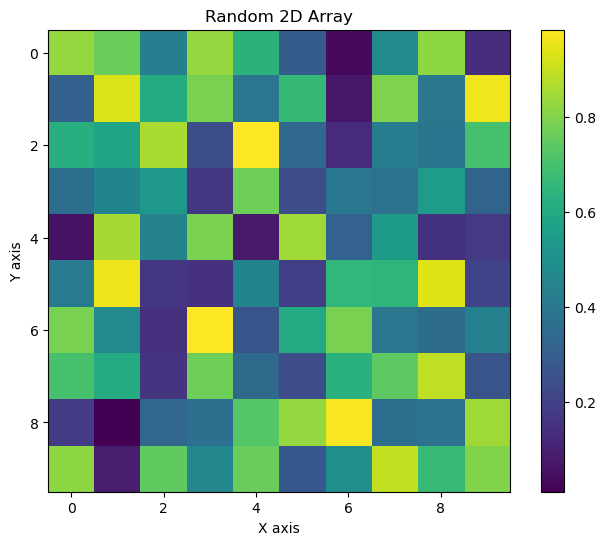

In [4]:
# my module import
from modules import *

In [5]:
    
class RESERVOIR(nn.Module):
    def __init__ (self, TIME_STEP=8, in_spike_size=28, in_channel=1, receptive_size=3, v_init=0, v_decay=0.6, v_threshold=1, v_reset=0, hard_reset=True, pre_spike_weight=1,
                  FC_RESERVOIR=False):
        super(RESERVOIR, self).__init__()
        self.TIME_STEP = TIME_STEP
        self.in_spike_size = in_spike_size
        self.in_channel = in_channel
        self.receptive_size = receptive_size #3
        self.v_init = v_init
        self.v_decay = v_decay
        self.v_threshold = v_threshold
        self.v_reset = v_reset
        self.hard_reset = hard_reset
        self.pre_spike_weight = pre_spike_weight
        self.FC_RESERVOIR = FC_RESERVOIR

        self.out_channel = 1

        # 파라미터 
        if self.FC_RESERVOIR == True:
            self.reservoir = nn.Linear(in_features=self.in_channel*self.in_spike_size*self.in_spike_size, out_features=self.in_channel*self.in_spike_size*self.in_spike_size, bias=True)
        else:
            self.reservoir = nn.Conv2d(in_channels=self.in_channel, out_channels=self.in_channel, 
                                            kernel_size=self.receptive_size, 
                                            stride=1, padding=1, groups=self.in_channel)

        # kaiming 초기화
        nn.init.kaiming_normal_(self.reservoir.weight, mode='fan_out', nonlinearity='relu')
        nn.init.constant_(self.reservoir.bias, 0)

        # membrane potential 초기화
        self.v = torch.full((self.in_channel, self.in_spike_size, self.in_spike_size), fill_value=self.v_init, requires_grad=False)

        
    def forward(self, pre_spike):    
        # pre_spike [TIME_STEP, batch_size, in_channel, in_spike_size, in_spike_size]

        v = torch.full_like(pre_spike[0], fill_value=self.v_init, requires_grad=False)
        post_spike = torch.zeros_like(pre_spike[0], requires_grad=False)
        # v [batch_size, in_channel, in_spike_size, in_spike_size]
        # recurrent [batch_size, in_channel, in_spike_size, in_spike_size]

        # timestep 안 맞으면 종료
        assert pre_spike.size(0) == self.TIME_STEP, f"Time step mismatch: {pre_spike.size(0)} vs {self.TIME_STEP}"

        output = []
        for t in range (self.TIME_STEP):
            # depthwise conv reservoir: pre_spike[t] [batch_size, in_channel, in_spike_size, in_spike_size]
            # fc conv reservoir: pre_spike[t] [batch_size, in_channel*in_spike_size*in_spike_size]
            input_current = self.pre_spike_weight * pre_spike[t]
                
            recurrent_current = self.reservoir(post_spike)
            current = input_current + recurrent_current
            # current [batch_size, in_channel, in_spike_size, in_spike_size] # kernel size 3이니까 사이즈 유지
            
            # decay and itegrate
            v = v*self.v_decay + current

            # post spike
            post_spike = (v >= self.v_threshold).float()

            output.append(post_spike)
            
            #reset
            if self.hard_reset: # hard reset
                v = (1 - post_spike)*v + post_spike*self.v_reset 
            else: # soft reset
                v = v - post_spike*self.v_threshold

        output = torch.stack(output, dim=0)
        return output

In [6]:
class RESERVOIR_NET(nn.Module):
    def __init__(self, TIME_STEP=8, CLASS_NUM=10, in_spike_size=28, in_channel=1, receptive_size=3, v_init=0, v_decay=0.6, v_threshold=1, v_reset=0, hard_reset=True, pre_spike_weight=1,
                 no_reservoir = False, FC_RESERVOIR=False):
        super(RESERVOIR_NET, self).__init__()
        self.TIME_STEP = TIME_STEP
        self.no_reservoir = no_reservoir
        self.FC_RESERVOIR = FC_RESERVOIR

        if self.no_reservoir == False:
            self.reservoir = RESERVOIR(TIME_STEP = self.TIME_STEP, in_spike_size=in_spike_size, in_channel=in_channel, receptive_size=receptive_size, v_init=v_init, v_decay=v_decay, v_threshold=v_threshold, v_reset=v_reset, hard_reset=hard_reset, pre_spike_weight=pre_spike_weight,
                                       FC_RESERVOIR=FC_RESERVOIR)
        
        self.classifier = nn.Linear(in_features=in_channel*in_spike_size*in_spike_size, out_features=CLASS_NUM)

    def forward(self, x):
        assert self.TIME_STEP == x.size(1), f"Time step mismatch: {x.size(1)} vs {self.TIME_STEP}"

        # x size [batch_size, TIME_STEP, in_channel, in_spike_size, in_spike_size]
        x = x.permute(1,0,2,3,4)
        # x size [TIME_STEP, batch_size, in_channel, in_spike_size, in_spike_size]

        if (self.FC_RESERVOIR == True):
            x = x.reshape(x.size(0), x.size(1), -1)

        if self.no_reservoir == False:
            with torch.no_grad():
                x = self.reservoir(x) # reservoir weight는 학습 안함

        T, B, *spatial_dims = x.shape

        x = x.reshape(T * B, -1) # time,batch 축은 합쳐서 FC에 삽입

        x = self.classifier(x)

        x = x.view(T , B, -1).contiguous() 
        
        x = x.mean(dim=0)
        return x

In [7]:
def data_loader(which_data, data_path, rate_coding, BATCH, IMAGE_SIZE, TIME, dvs_duration, dvs_clipping):
    if which_data == 'MNIST':
        if rate_coding :
            transform = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0,), (1,))])
        else : 
            transform = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5,),(0.5))])

        trainset = torchvision.datasets.MNIST(root=data_path,
                                            train=True,
                                            download=True,
                                            transform=transform)


        testset = torchvision.datasets.MNIST(root=data_path,
                                            train=False,
                                            download=True,
                                            transform=transform)

        train_loader = DataLoader(trainset,
                                batch_size =BATCH,
                                shuffle = True,
                                num_workers =2)
        test_loader = DataLoader(testset,
                                batch_size =BATCH,
                                shuffle = False,
                                num_workers =2)
        synapse_conv_in_channels = 1
        CLASS_NUM = 10


    

    elif (which_data == 'CIFAR10'):

        if rate_coding :
            # transform_train = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            #                                     transforms.RandomHorizontalFlip(),
            #                                     transforms.ToTensor()])

            # transform_test = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            #                                     transforms.ToTensor()])
            
            transform_train = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                                transforms.RandomHorizontalFlip(),
                                                transforms.ToTensor()])
                                            # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

            transform_test = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                                transforms.ToTensor()])
        
        else :
            # transform_train = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            #                                     transforms.RandomHorizontalFlip(),
            #                                     transforms.ToTensor(),
            #                                     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])
            #                                 # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

            # transform_test = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            #                                     transforms.ToTensor(),
            #                                     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),])
            #                                 # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            
            # assert IMAGE_SIZE == 32, 'OTTT랑 맞짱뜰 때는 32로 ㄱ'
            transform_train = transforms.Compose([
                transforms.RandomCrop(IMAGE_SIZE, padding=4),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize((0.4914, 0.4822, 0.4465),
                                    (0.2023, 0.1994, 0.2010)),
            ])
            transform_test = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.4914, 0.4822, 0.4465),
                                    (0.2023, 0.1994, 0.2010)),
            ])

        trainset = torchvision.datasets.CIFAR10(root=data_path,
                                            train=True,
                                            download=True,
                                            transform=transform_train)


        testset = torchvision.datasets.CIFAR10(root=data_path,
                                            train=False,
                                            download=True,
                                            transform=transform_test)
        
        
        train_loader = DataLoader(trainset,
                                batch_size =BATCH,
                                shuffle = True,
                                num_workers =2)
        test_loader = DataLoader(testset,
                                batch_size =BATCH,
                                shuffle = False,
                                num_workers =2)
        
        synapse_conv_in_channels = 3
        CLASS_NUM = 10
        '''
        classes = ('plane', 'car', 'bird', 'cat', 'deer',
                'dog', 'frog', 'horse', 'ship', 'truck') 
        '''


    elif (which_data == 'FASHION_MNIST'):

        if rate_coding :
            transform = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                    transforms.ToTensor()])
        else : 
            transform = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5,),(0.5))])

        trainset = torchvision.datasets.FashionMNIST(root=data_path,
                                            train=True,
                                            download=True,
                                            transform=transform)


        testset = torchvision.datasets.FashionMNIST(root=data_path,
                                            train=False,
                                            download=True,
                                            transform=transform)

        train_loader = DataLoader(trainset,
                                batch_size =BATCH,
                                shuffle = True,
                                num_workers =2)
        test_loader = DataLoader(testset,
                                batch_size =BATCH,
                                shuffle = False,
                                num_workers =2)
        synapse_conv_in_channels = 1
        CLASS_NUM = 10
    elif (which_data == 'DVS_GESTURE'):
        data_dir = data_path + '/gesture'
        transform = None

        # # spikingjelly.datasets.dvs128_gesture.DVS128Gesture(root: str, train: bool, use_frame=True, frames_num=10, split_by='number', normalization='max')
       
        #https://spikingjelly.readthedocs.io/zh-cn/latest/activation_based_en/neuromorphic_datasets.html
        # 10ms마다 1개의 timestep하고 싶으면 위의 주소 참고. 근데 timestep이 각각 좀 다를 거임.

        if dvs_duration > 0:
            resize_shape = (IMAGE_SIZE, IMAGE_SIZE)
            train_data = CustomDVS128Gesture(
                data_dir, train=True, data_type='frame',  split_by='time',  duration=dvs_duration, resize_shape=resize_shape, dvs_clipping=dvs_clipping, dvs_duration_copy=dvs_duration, TIME=TIME)
            test_data = CustomDVS128Gesture(
                data_dir, train=False, data_type='frame',  split_by='time',  duration=dvs_duration, resize_shape=resize_shape, dvs_clipping=dvs_clipping, dvs_duration_copy=dvs_duration, TIME=TIME)
        else:
            train_data = CustomDVS128Gesture(
                data_dir, train=True, data_type='frame', split_by='number', frames_number=TIME, resize_shape=resize_shape, dvs_clipping=dvs_clipping, dvs_duration_copy=dvs_duration, TIME=TIME)
            test_data = CustomDVS128Gesture(data_dir, train=False,
                                            data_type='frame', split_by='number', frames_number=TIME, resize_shape=resize_shape, dvs_clipping=dvs_clipping, dvs_duration_copy=dvs_duration, TIME=TIME)
        
        ## 11번째 클래스 배제 ########################################################################
        exclude_class = 10
        if dvs_duration > 0:
            train_file_name = f'modules/dvs_gesture_class_index/train_indices_dvsgesture_duration_{dvs_duration}'
            test_file_name = f'modules/dvs_gesture_class_index/test_indices_dvsgesture_duration_{dvs_duration}'
            if (os.path.isfile(train_file_name) and os.path.isfile(test_file_name)):
                print('\ndvsgestrue 10 class indices exist. we want to exclude the 11th class\n')
                with open(train_file_name, 'rb') as f:
                    train_indices = pickle.load(f)
                with open(test_file_name, 'rb') as f:
                    test_indices = pickle.load(f)
            else:
                print('\ndvsgestrue 10 class indices doesn\'t exist. we want to exclude the 11th class\n')
                train_indices = [i for i, (_, target) in enumerate(train_data) if target != exclude_class]
                test_indices = [i for i, (_, target) in enumerate(test_data) if target != exclude_class]
                with open(train_file_name, 'wb') as f:
                    pickle.dump(train_indices, f)
                with open(test_file_name, 'wb') as f:
                    pickle.dump(test_indices, f)
        else:
            train_indices = [i for i, (_, target) in enumerate(train_data) if target != exclude_class]
            test_indices = [i for i, (_, target) in enumerate(test_data) if target != exclude_class]
        ################################################################################################

        # SubsetRandomSampler 생성
        train_sampler = SubsetRandomSampler(train_indices)
        test_sampler = SequentialSampler(test_indices)

        # ([B, T, 2, 128, 128]) 
        train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=BATCH, num_workers=2, sampler=train_sampler, collate_fn=pad_sequence_collate)
        test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=BATCH, num_workers=2, sampler=test_sampler, collate_fn=pad_sequence_collate)
        synapse_conv_in_channels = 2
        CLASS_NUM = 10
        # mapping = { 0 :'Hand Clapping'  1 :'Right Hand Wave'2 :'Left Hand Wave' 3 :'Right Arm CW'   4 :'Right Arm CCW'  5 :'Left Arm CW'    6 :'Left Arm CCW'   7 :'Arm Roll'       8 :'Air Drums'      9 :'Air Guitar'     10:'Other'}

    else:
        assert False, 'wrong dataset name'


    
    return train_loader, test_loader, synapse_conv_in_channels, CLASS_NUM

In [8]:
def train(model, train_loader, criterion, optimizer, device, rate_coding, TIME_STEP, which_data):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    iterator = enumerate(train_loader, 0)
    for i, data in iterator:
    # for i, (inputs, labels) in enumerate(train_loader):
        if len(data) == 2:
            inputs, labels = data
            # 처리 로직 작성
        elif len(data) == 3:
            inputs, labels, x_len = data

        inputs, labels = inputs.to(device), labels.to(device)

        # if rate_coding == True:
        #     inputs = spikegen.rate(inputs, num_steps=TIME_STEP)
        # else:
        #     inputs = inputs.repeat(TIME_STEP, 1, 1, 1, 1)
        

        ###########################################################################################################################        
        if (which_data == 'n_tidigits'):
            inputs = inputs.permute(0, 1, 3, 2, 4)
            labels = labels[:, 0, :]
            labels = torch.argmax(labels, dim=1)
        elif (which_data == 'heidelberg'):
            inputs = inputs.view(5, 1000, 1, 700, 1)
            print("\n\n\n경고!!!! heidelberg 이거 타임스텝이랑 채널 잘 바꿔줘라!!!\n\n\n\n")
        # print('inputs',inputs.size(),'\nlabels',labels.size())
        # print(labels)
            
        if (which_data == 'DVS_CIFAR10' or which_data == 'DVS_GESTURE' or which_data == 'DVS_CIFAR10_2' or which_data == 'NMNIST' or which_data == 'N_CALTECH101' or which_data == 'n_tidigits' or which_data == 'heidelberg'):
            inputs = inputs.permute(1, 0, 2, 3, 4)
        elif rate_coding == True :
            inputs = spikegen.rate(inputs, num_steps=TIME_STEP)
        else :
            inputs = inputs.repeat(TIME_STEP, 1, 1, 1, 1)
        # inputs: [Time, Batch, Channel, Height, Width]  
        ####################################################################################################################### 

        
        
        
        
        inputs = inputs.permute(1, 0, 2, 3, 4)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        iter_correct = (predicted == labels).sum().item()
        correct += iter_correct
        # if i % 100 == 99:
        # print(f"[{i+1}] loss: {running_loss / 100:.3f}")
        # running_loss = 0.0
        iter_accuracy = 100 * iter_correct / labels.size(0)
        wandb.log({"iter_accuracy": iter_accuracy})
    tr_accuracy = 100 * correct / total         
    wandb.log({"tr_accuracy": tr_accuracy})
    print(f"Train Accuracy: {tr_accuracy:.2f}%")
    
def test(model, test_loader, criterion, device, rate_coding, TIME_STEP, which_data):
    model.eval()
    correct = 0
    total = 0
    test_loss = 0.0
    iterator = enumerate(test_loader, 0)
    with torch.no_grad():
        for i, data in iterator:
        # for inputs, labels in test_loader:
            if len(data) == 2:
                inputs, labels = data
                # 처리 로직 작성
            elif len(data) == 3:
                inputs, labels, x_len = data
                
            inputs, labels = inputs.to(device), labels.to(device)

            # if rate_coding == True:
            #     inputs = spikegen.rate(inputs, num_steps=TIME_STEP)
            # else:
            #     inputs = inputs.repeat(TIME_STEP, 1, 1, 1, 1)

        

            ###########################################################################################################################        
            if (which_data == 'n_tidigits'):
                inputs = inputs.permute(0, 1, 3, 2, 4)
                labels = labels[:, 0, :]
                labels = torch.argmax(labels, dim=1)
            elif (which_data == 'heidelberg'):
                inputs = inputs.view(5, 1000, 1, 700, 1)
                print("\n\n\n경고!!!! heidelberg 이거 타임스텝이랑 채널 잘 바꿔줘라!!!\n\n\n\n")
            # print('inputs',inputs.size(),'\nlabels',labels.size())
            # print(labels)
                
            if (which_data == 'DVS_CIFAR10' or which_data == 'DVS_GESTURE' or which_data == 'DVS_CIFAR10_2' or which_data == 'NMNIST' or which_data == 'N_CALTECH101' or which_data == 'n_tidigits' or which_data == 'heidelberg'):
                inputs = inputs.permute(1, 0, 2, 3, 4)
            elif rate_coding == True :
                inputs = spikegen.rate(inputs, num_steps=TIME_STEP)
            else :
                inputs = inputs.repeat(TIME_STEP, 1, 1, 1, 1)
            # inputs: [Time, Batch, Channel, Height, Width]  
            ####################################################################################################################### 

        


            inputs = inputs.permute(1, 0, 2, 3, 4)
        
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_accuracy = 100 * correct / total
    wandb.log({"val_accuracy": val_accuracy})
    print(f"Test loss: {test_loss / len(test_loader):.3f}, Val Accuracy: {val_accuracy:.2f}%")


In [9]:
def main(data_path='/data2', which_data='MNIST', gpu = '3',learning_rate = 0.0001, BATCH=5, IMAGE_SIZE=28, TIME_STEP=8, EPOCH=10, rate_coding=True, v_decay= 0.6,
v_threshold=1, v_reset=0, hard_reset=True, pre_spike_weight=1, dvs_duration=1000000, dvs_clipping=True, no_reservoir = False, FC_RESERVOIR=False):
    os.environ["CUDA_VISIBLE_DEVICES"]= gpu
    # run = wandb.init(project=f'reservoir')

    hyperparameters = locals()

    wandb.config.update(hyperparameters)
    wandb.run.name = f'{which_data}_sweeprun_epoch{EPOCH}'
    wandb.run.log_code(".", include_fn=lambda path: path.endswith(".py") or path.endswith(".ipynb"))

    train_loader, test_loader, in_channel, CLASS_NUM = data_loader(
        which_data=which_data, data_path=data_path, rate_coding=rate_coding, BATCH=BATCH, IMAGE_SIZE=IMAGE_SIZE, TIME=TIME_STEP, dvs_duration=dvs_duration, dvs_clipping=dvs_clipping)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    net = RESERVOIR_NET(TIME_STEP=TIME_STEP, CLASS_NUM=CLASS_NUM, in_spike_size=IMAGE_SIZE, in_channel=in_channel, receptive_size=3, v_init=0, v_decay=v_decay, v_threshold=v_threshold, v_reset=v_reset, hard_reset=hard_reset, pre_spike_weight=pre_spike_weight, 
                            no_reservoir = no_reservoir, FC_RESERVOIR=FC_RESERVOIR)
    net = net.to(device)
    wandb.watch(net, log="all", log_freq = 1) #gradient, parameter logging해줌

    criterion = nn.CrossEntropyLoss()
    # optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0)

    print(net)

    for epoch in range(EPOCH):
        print(f"Epoch {epoch+1}")
        train(net, train_loader, criterion, optimizer, device, rate_coding, TIME_STEP, which_data)
        test(net, test_loader, criterion, device, rate_coding, TIME_STEP, which_data)
        wandb.log({"epoch": epoch})
        # torch.save(net.state_dict(), 'net_save/reservoir_net.pth')
        # artifact = wandb.Artifact('model', type='model')
        # artifact.add_file('net_save/reservoir_net.pth')
        # run.log_artifact(artifact)


In [10]:
# # sweep 하기 싫을 때
# wandb.init(project=f'reservoir')
# main(data_path='/data2', which_data='CIFAR10', gpu = '3', learning_rate = 0.0072, BATCH=256, IMAGE_SIZE=32, TIME_STEP=9, EPOCH=50, rate_coding=True, v_decay= 0.78,
# v_threshold=1, v_reset=0, hard_reset=True, pre_spike_weight=5.0, dvs_duration=1000000, dvs_clipping=True, no_reservoir = False, FC_RESERVOIR=False)

In [11]:
# sweep하고싶을 때
def sweep_cover(data_path='/data2', which_data='CIFAR10', gpu = '4', learning_rate = 0.0001, BATCH=5, IMAGE_SIZE=28, TIME_STEP=8, EPOCH=3, rate_coding=True, v_decay= 0.6,
v_threshold=1, v_reset=0, hard_reset=True, pre_spike_weight=1, dvs_duration=1000000, dvs_clipping=True, no_reservoir = False, FC_RESERVOIR=False):
    
    wandb.init(save_code = True)

    learning_rate  =  wandb.config.learning_rate
    BATCH  =  wandb.config.batch_size
    TIME_STEP  =  wandb.config.time_step
    v_decay  =  wandb.config.decay
    pre_spike_weight  =  wandb.config.pre_spike_weight
    which_data  =  wandb.config.which_data
    data_path  =  wandb.config.data_path
    rate_coding  =  wandb.config.rate_coding
    EPOCH  =  wandb.config.EPOCH
    IMAGE_SIZE  =  wandb.config.IMAGE_SIZE
    dvs_duration  =  wandb.config.dvs_duration
    dvs_clipping  =  wandb.config.dvs_clipping
    no_reservoir  =  wandb.config.no_reservoir
    FC_RESERVOIR  =  wandb.config.FC_RESERVOIR
    main(data_path=data_path, which_data=which_data, gpu = gpu, learning_rate = learning_rate, BATCH=BATCH, IMAGE_SIZE=IMAGE_SIZE, TIME_STEP=TIME_STEP, EPOCH=EPOCH, rate_coding=rate_coding, v_decay= v_decay,
v_threshold=v_threshold, v_reset=v_reset, hard_reset=hard_reset, pre_spike_weight=pre_spike_weight, dvs_duration=dvs_duration, dvs_clipping=dvs_clipping, no_reservoir = no_reservoir, FC_RESERVOIR=FC_RESERVOIR)



which_data_hyper = 'CIFAR10' # 'MNIST', 'CIFAR10' ', 'FASHION_MNIST', 'DVS_GESTURE'
data_path_hyper = '/data2'

sweep_configuration = {
    'method': 'bayes',
    'name': f'{which_data_hyper} ba_reservoir',
    'metric': {'goal': 'maximize', 'name': 'val_accuracy'},
    'parameters': 
    {
        "learning_rate": {"values": [0.001]},
        "batch_size": {"values": [512]},
        "time_step": {"values": [4,5,6,7,8]},
        "decay": {"values": [0.7]},
        "pre_spike_weight": {"min": 0.5, "max": 10.0},
        "which_data": {"values": [which_data_hyper]},
        "data_path": {"values": [data_path_hyper]},
        "rate_coding": {"values": [True, False]},
        "EPOCH": {"values": [4]},
        "IMAGE_SIZE": {"values": [32]},
        "dvs_duration": {"values": [1000000]},
        "dvs_clipping": {"values": [True]},
        "no_reservoir": {"values": [True, False]},
        "FC_RESERVOIR": {"values": [False]},
     }
}

sweep_id = wandb.sweep(sweep=sweep_configuration, project=f'reservoir')
wandb.agent(sweep_id, function=sweep_cover, count=10000)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: q450j7i1
Sweep URL: https://wandb.ai/bhkim003-seoul-national-university/reservoir/sweeps/q450j7i1


wandb: Agent Starting Run: b2en66w9 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.279406753686184
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: bhkim003 (bhkim003-seoul-national-university). Use `wandb login --relogin` to force relogin


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.19%
Test loss: 1.895, Val Accuracy: 33.93%
Epoch 2
Train Accuracy: 31.99%
Test loss: 1.862, Val Accuracy: 35.46%
Epoch 3
Train Accuracy: 32.31%
Test loss: 1.866, Val Accuracy: 34.92%
Epoch 4
Train Accuracy: 32.73%
Test loss: 1.848, Val Accuracy: 35.84%


epoch,▁▃▆█
iter_accuracy,▁▄▅▅▆▆▇▆▆▆▇▆▆▇▆▇▆▇▇▇▆▇▇▇█▆▆█▆▇▆▆▇▆▇▆██▇▇
tr_accuracy,▁▇▇█
val_accuracy,▁▇▅█
epoch,3
iter_accuracy,34.52381
tr_accuracy,32.732
val_accuracy,35.84


wandb: Agent Starting Run: bgi8b0ac with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.297760363405997
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 19.71%
Test loss: 2.066, Val Accuracy: 25.35%
Epoch 2
Train Accuracy: 24.48%
Test loss: 2.026, Val Accuracy: 27.93%
Epoch 3
Train Accuracy: 26.07%
Test loss: 2.010, Val Accuracy: 29.08%
Epoch 4
Train Accuracy: 26.68%
Test loss: 1.998, Val Accuracy: 29.65%


epoch,▁▃▆█
iter_accuracy,▁▃▂▄▄▄▄▄▆▅▇▆▆▆▇▆▆▇▅▇▆▆▆▆▆▆▆▆███▇▇▇▆▆█▇▇▆
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,25.29762
tr_accuracy,26.676
val_accuracy,29.65


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: s91ltvav with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.026153579512822
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.48%
Test loss: 1.902, Val Accuracy: 33.78%
Epoch 2
Train Accuracy: 31.72%
Test loss: 1.882, Val Accuracy: 34.76%
Epoch 3
Train Accuracy: 32.71%
Test loss: 1.863, Val Accuracy: 35.25%
Epoch 4
Train Accuracy: 33.01%
Test loss: 1.862, Val Accuracy: 35.16%


epoch,▁▃▆█
iter_accuracy,▁▂▅▅▅▄▅▇▅▆▆▄▇▅▆▆▆▆▆▆▅▆▄▇▅▇▇▆█▆▅█▅▆▆▆▆▇▆▅
tr_accuracy,▁▆██
val_accuracy,▁▆██
epoch,3
iter_accuracy,30.05952
tr_accuracy,33.006
val_accuracy,35.16


wandb: Agent Starting Run: 98lbzdn9 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.956314081032135
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.40%
Test loss: 2.002, Val Accuracy: 29.57%
Epoch 2
Train Accuracy: 27.66%
Test loss: 1.961, Val Accuracy: 31.63%
Epoch 3
Train Accuracy: 28.67%
Test loss: 1.936, Val Accuracy: 32.39%
Epoch 4
Train Accuracy: 29.11%
Test loss: 1.930, Val Accuracy: 32.78%


epoch,▁▃▆█
iter_accuracy,▁▂▂▄▄▄▆▆▅▆▆▅▃▆▆▅▆▇▇▇▆▇▆▆▆▆▇▆▆▇▇▆▇█▆▅▇▇▆█
tr_accuracy,▁▇██
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,32.44048
tr_accuracy,29.114
val_accuracy,32.78


wandb: Agent Starting Run: z4w474gd with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.939883555398008
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.45%
Test loss: 2.012, Val Accuracy: 27.70%
Epoch 2
Train Accuracy: 27.16%
Test loss: 1.963, Val Accuracy: 30.42%
Epoch 3
Train Accuracy: 28.47%
Test loss: 1.947, Val Accuracy: 32.22%
Epoch 4
Train Accuracy: 28.78%
Test loss: 1.933, Val Accuracy: 32.35%


epoch,▁▃▆█
iter_accuracy,▁▃▃▄▄▆▅▆▆▇▆▆▆█▆█▆▇▇▇█▇▆█▆▆█▇▇██▆▇▇▇█▇▇█▆
tr_accuracy,▁▆██
val_accuracy,▁▅██
epoch,3
iter_accuracy,25.0
tr_accuracy,28.78
val_accuracy,32.35


wandb: Agent Starting Run: 6ugxrpw9 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.926554077791688
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.04%
Test loss: 2.022, Val Accuracy: 29.36%
Epoch 2
Train Accuracy: 31.11%
Test loss: 1.949, Val Accuracy: 32.03%
Epoch 3
Train Accuracy: 33.31%
Test loss: 1.907, Val Accuracy: 34.53%
Epoch 4
Train Accuracy: 34.74%
Test loss: 1.886, Val Accuracy: 34.32%


epoch,▁▃▆█
iter_accuracy,▁▁▃▃▄▄▅▅▄▅▅▆▅▆▅▆▆▆▆▇▆▅▇▆▇▅▆▆▆▆▇▇▇▇▆█▇▆▇█
tr_accuracy,▁▆▇█
val_accuracy,▁▅██
epoch,3
iter_accuracy,39.88095
tr_accuracy,34.744
val_accuracy,34.32


wandb: Agent Starting Run: ujcxikox with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.167838353976536
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.36%
Test loss: 2.029, Val Accuracy: 28.41%
Epoch 2
Train Accuracy: 31.08%
Test loss: 1.945, Val Accuracy: 33.18%
Epoch 3
Train Accuracy: 33.41%
Test loss: 1.909, Val Accuracy: 33.44%
Epoch 4
Train Accuracy: 34.39%
Test loss: 1.889, Val Accuracy: 33.65%


epoch,▁▃▆█
iter_accuracy,▁▂▃▄▅▆▆▅▆▆▆▅▆▆▇▇▆▆█▇▇███▇▇▆██▇▇▇▇██▇▇▇▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▇██
epoch,3
iter_accuracy,32.44048
tr_accuracy,34.386
val_accuracy,33.65


wandb: Agent Starting Run: y1ccokei with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.294966605467406
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.47%
Test loss: 1.902, Val Accuracy: 33.96%
Epoch 2
Train Accuracy: 31.70%
Test loss: 1.878, Val Accuracy: 34.32%
Epoch 3
Train Accuracy: 32.35%
Test loss: 1.859, Val Accuracy: 35.63%
Epoch 4
Train Accuracy: 32.99%
Test loss: 1.850, Val Accuracy: 36.12%


epoch,▁▃▆█
iter_accuracy,▁▃▄▅▆▆▅▅▅▆█▆▇▆▆▆██▅▆▆▇▅▅▆▆▆▇▆█▇▅▆▇▇▇▇█▆▆
tr_accuracy,▁▆▇█
val_accuracy,▁▂▆█
epoch,3
iter_accuracy,31.25
tr_accuracy,32.988
val_accuracy,36.12


wandb: Agent Starting Run: yotyiapw with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.957017421644842
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.18%
Test loss: 1.903, Val Accuracy: 33.08%
Epoch 2
Train Accuracy: 31.73%
Test loss: 1.866, Val Accuracy: 35.10%
Epoch 3
Train Accuracy: 32.84%
Test loss: 1.868, Val Accuracy: 34.76%
Epoch 4
Train Accuracy: 33.46%
Test loss: 1.853, Val Accuracy: 35.57%


epoch,▁▃▆█
iter_accuracy,▁▃▃▅▅▅▅▅▆▇▅▆▆▇▇▆▅██▆▆▇▇▆▇▆▆▇▇▇▇▇▆▇▆█▇▇█▆
tr_accuracy,▁▆▇█
val_accuracy,▁▇▆█
epoch,3
iter_accuracy,31.54762
tr_accuracy,33.46
val_accuracy,35.57


wandb: Agent Starting Run: mgs1jywx with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.124896803491433
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.49%
Test loss: 2.021, Val Accuracy: 28.68%
Epoch 2
Train Accuracy: 31.14%
Test loss: 1.949, Val Accuracy: 32.51%
Epoch 3
Train Accuracy: 33.15%
Test loss: 1.910, Val Accuracy: 33.69%
Epoch 4
Train Accuracy: 34.38%
Test loss: 1.885, Val Accuracy: 34.50%


epoch,▁▃▆█
iter_accuracy,▁▁▃▃▅▄▅▅▅▅▆▆▅▆▆▅▆▆▆▅▆▆▆▇▆▇▆▅▆█▇▆▆▆▇▆▆▆▇▆
tr_accuracy,▁▆▇█
val_accuracy,▁▆▇█
epoch,3
iter_accuracy,33.33333
tr_accuracy,34.376
val_accuracy,34.5


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dircxkhy with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.02049805723944
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.43%
Test loss: 2.013, Val Accuracy: 30.11%
Epoch 2
Train Accuracy: 31.65%
Test loss: 1.939, Val Accuracy: 33.44%
Epoch 3
Train Accuracy: 33.46%
Test loss: 1.900, Val Accuracy: 34.62%
Epoch 4
Train Accuracy: 34.62%
Test loss: 1.879, Val Accuracy: 35.28%


epoch,▁▃▆█
iter_accuracy,▁▂▃▄▅▅▅▆▅▆▇▆▇▇▅▆▇▇▇▆▇▆▇▇▇▇▇█▇██▆▇▇▆▇▇█▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▆▇█
epoch,3
iter_accuracy,34.52381
tr_accuracy,34.616
val_accuracy,35.28


wandb: Agent Starting Run: j014l9tb with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.072023058839743
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.25%
Test loss: 1.884, Val Accuracy: 34.45%
Epoch 2
Train Accuracy: 31.66%
Test loss: 1.872, Val Accuracy: 34.94%
Epoch 3
Train Accuracy: 32.69%
Test loss: 1.861, Val Accuracy: 34.77%
Epoch 4
Train Accuracy: 33.02%
Test loss: 1.851, Val Accuracy: 35.38%


epoch,▁▃▆█
iter_accuracy,▁▃▄▅▆▆▇▆▆▅▇▅▇▅▆▇▇█▇▆▇▇▇▆▇▆▇▇▇▇▆▇▇▇█▇█▆▇▇
tr_accuracy,▁▆██
val_accuracy,▁▅▃█
epoch,3
iter_accuracy,33.03571
tr_accuracy,33.022
val_accuracy,35.38


wandb: Agent Starting Run: 407o6ivc with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.974733324515175
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.60%
Test loss: 1.898, Val Accuracy: 33.61%
Epoch 2
Train Accuracy: 31.59%
Test loss: 1.863, Val Accuracy: 35.44%
Epoch 3
Train Accuracy: 32.82%
Test loss: 1.848, Val Accuracy: 35.89%
Epoch 4
Train Accuracy: 33.13%
Test loss: 1.847, Val Accuracy: 35.49%


epoch,▁▃▆█
iter_accuracy,▁▄▄▅▆▅▆▆▇▆▆▇▆▇▇▆▆▅▆▆▇▆▇▇▇▆▅█▇▆▆█▆▆█▆▅▅▆█
tr_accuracy,▁▆██
val_accuracy,▁▇█▇
epoch,3
iter_accuracy,37.79762
tr_accuracy,33.126
val_accuracy,35.49


wandb: Agent Starting Run: 7o4cgl5e with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.396704911138206
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.27%
Test loss: 2.015, Val Accuracy: 28.74%
Epoch 2
Train Accuracy: 27.02%
Test loss: 1.972, Val Accuracy: 30.37%
Epoch 3
Train Accuracy: 28.09%
Test loss: 1.956, Val Accuracy: 31.51%
Epoch 4
Train Accuracy: 28.98%
Test loss: 1.941, Val Accuracy: 32.35%


epoch,▁▃▆█
iter_accuracy,▁▄▃▄▅▆▆▇▅▇▅▇█▆▇▆▆▇█▇▇▆▆▇▇▆▇▇▇▇▇▇█▇▇▇▆▇▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▄▆█
epoch,3
iter_accuracy,29.7619
tr_accuracy,28.978
val_accuracy,32.35


wandb: Agent Starting Run: 9lbwu95x with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.990885769960709
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.44%
Test loss: 2.028, Val Accuracy: 29.81%
Epoch 2
Train Accuracy: 30.59%
Test loss: 1.950, Val Accuracy: 32.21%
Epoch 3
Train Accuracy: 32.88%
Test loss: 1.911, Val Accuracy: 33.63%
Epoch 4
Train Accuracy: 34.10%
Test loss: 1.887, Val Accuracy: 34.38%


epoch,▁▃▆█
iter_accuracy,▁▂▄▄▅▅▅▆▅▆▆▆▅▇▆▆▆▆▆▆▆▆▆▆▇▇█▆▇█▇▇▇▇▇▇██▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,32.7381
tr_accuracy,34.096
val_accuracy,34.38


wandb: Agent Starting Run: fzgqkvey with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.421926484257491
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.58%
Test loss: 2.011, Val Accuracy: 29.07%
Epoch 2
Train Accuracy: 26.94%
Test loss: 1.973, Val Accuracy: 30.02%
Epoch 3
Train Accuracy: 28.44%
Test loss: 1.960, Val Accuracy: 31.24%
Epoch 4
Train Accuracy: 28.84%
Test loss: 1.946, Val Accuracy: 32.35%


epoch,▁▃▆█
iter_accuracy,▁▁▄▄▆▅▅▅▅▆▆▇▆▇▇▇▆▆▆▇▇▆▅▇▆▆▇▇▅█▆█▆█▇▇▇█▇▇
tr_accuracy,▁▆██
val_accuracy,▁▃▆█
epoch,3
iter_accuracy,29.16667
tr_accuracy,28.844
val_accuracy,32.35


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: nfjmcd4o with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.890712945758873
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.89%
Test loss: 2.032, Val Accuracy: 28.23%
Epoch 2
Train Accuracy: 30.60%
Test loss: 1.950, Val Accuracy: 32.59%
Epoch 3
Train Accuracy: 33.31%
Test loss: 1.912, Val Accuracy: 33.66%
Epoch 4
Train Accuracy: 33.99%
Test loss: 1.889, Val Accuracy: 34.55%


epoch,▁▃▆█
iter_accuracy,▁▂▃▄▄▄▅▆▆▅▄▆▆▅▆▆▆▆▇▆█▅▆▇▇▇█▇▆█▇▆▇▇█▇▇▇██
tr_accuracy,▁▆██
val_accuracy,▁▆▇█
epoch,3
iter_accuracy,35.71429
tr_accuracy,33.988
val_accuracy,34.55


wandb: Agent Starting Run: 7ldlqell with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.956310256419448
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.17%
Test loss: 2.014, Val Accuracy: 28.26%
Epoch 2
Train Accuracy: 26.81%
Test loss: 1.969, Val Accuracy: 30.46%
Epoch 3
Train Accuracy: 28.29%
Test loss: 1.943, Val Accuracy: 31.38%
Epoch 4
Train Accuracy: 28.29%
Test loss: 1.932, Val Accuracy: 32.10%


epoch,▁▃▆█
iter_accuracy,▁▂▅▅▅▄▅▆▇▆▆▇▆▇▇▆▇▇▆▇█▇▇▇▆█▇█▇█▆▇▇█▆▇▇▆██
tr_accuracy,▁▇██
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,30.35714
tr_accuracy,28.288
val_accuracy,32.1


wandb: Agent Starting Run: 5o479hae with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.924453325830059
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.74%
Test loss: 1.999, Val Accuracy: 29.59%
Epoch 2
Train Accuracy: 27.42%
Test loss: 1.962, Val Accuracy: 31.68%
Epoch 3
Train Accuracy: 28.43%
Test loss: 1.945, Val Accuracy: 31.77%
Epoch 4
Train Accuracy: 29.21%
Test loss: 1.928, Val Accuracy: 32.75%


epoch,▁▃▆█
iter_accuracy,▁▂▄▄▆▅▅▆▆▆▆▇▆▆▇▇▆▇▇▇█▇▇▇█▆▇▇▇█▇▇▇▇▇██▇▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▆▆█
epoch,3
iter_accuracy,30.05952
tr_accuracy,29.212
val_accuracy,32.75


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xp237lml with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.412178725002505
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 26.91%
Test loss: 1.911, Val Accuracy: 32.00%
Epoch 2
Train Accuracy: 31.72%
Test loss: 1.867, Val Accuracy: 34.92%
Epoch 3
Train Accuracy: 32.80%
Test loss: 1.854, Val Accuracy: 35.04%
Epoch 4
Train Accuracy: 32.99%
Test loss: 1.856, Val Accuracy: 35.57%


epoch,▁▃▆█
iter_accuracy,▁▃▅▆▆▇▆▆▆▆▆▇▇▇█▇█▇▇▆▆▇█▆██▇▇▇▇█▆▆▆▇▇█▇▇▆
tr_accuracy,▁▇██
val_accuracy,▁▇▇█
epoch,3
iter_accuracy,30.35714
tr_accuracy,32.99
val_accuracy,35.57


wandb: Agent Starting Run: 4wn5cn7i with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.370634091576611
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.38%
Test loss: 2.026, Val Accuracy: 29.92%
Epoch 2
Train Accuracy: 31.06%
Test loss: 1.945, Val Accuracy: 33.02%
Epoch 3
Train Accuracy: 33.47%
Test loss: 1.908, Val Accuracy: 33.49%
Epoch 4
Train Accuracy: 34.54%
Test loss: 1.879, Val Accuracy: 35.08%


epoch,▁▃▆█
iter_accuracy,▁▁▃▃▄▅▅▅▅▆▆▆▇▆▆▆▇▆█▆▆▇▆▆▇▇█▆▆▇▇▇▇▇▇▇██▇█
tr_accuracy,▁▆▇█
val_accuracy,▁▅▆█
epoch,3
iter_accuracy,36.30952
tr_accuracy,34.544
val_accuracy,35.08


wandb: Agent Starting Run: nii28hxc with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.085862131630111
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.84%
Test loss: 2.018, Val Accuracy: 27.64%
Epoch 2
Train Accuracy: 26.77%
Test loss: 1.975, Val Accuracy: 30.97%
Epoch 3
Train Accuracy: 28.03%
Test loss: 1.958, Val Accuracy: 31.22%
Epoch 4
Train Accuracy: 28.86%
Test loss: 1.944, Val Accuracy: 31.91%


epoch,▁▃▆█
iter_accuracy,▁▃▄▄▅▄▅▅▆▅▆▄▅▆▇▅█▆▆▆▅▆▅▆▅▇█▆▇▆▆▇█▆█▇▇▇▇▆
tr_accuracy,▁▆▇█
val_accuracy,▁▆▇█
epoch,3
iter_accuracy,26.4881
tr_accuracy,28.856
val_accuracy,31.91


wandb: Agent Starting Run: 2dy2dy8e with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.8592938759131297
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.67%
Test loss: 2.028, Val Accuracy: 29.34%
Epoch 2
Train Accuracy: 31.01%
Test loss: 1.948, Val Accuracy: 32.87%
Epoch 3
Train Accuracy: 33.14%
Test loss: 1.909, Val Accuracy: 34.44%
Epoch 4
Train Accuracy: 34.29%
Test loss: 1.882, Val Accuracy: 35.20%


epoch,▁▃▆█
iter_accuracy,▁▂▂▄▆▅▆▆▅▆▆▅▆▇▆▇▆▇▇▇▆▇▇▇▇▆▇▆▇▇▇▇▇▇▇██▇██
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,37.5
tr_accuracy,34.286
val_accuracy,35.2


wandb: Agent Starting Run: sptdwt0l with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.970238409959071
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.73%
Test loss: 2.034, Val Accuracy: 28.38%
Epoch 2
Train Accuracy: 30.93%
Test loss: 1.950, Val Accuracy: 32.94%
Epoch 3
Train Accuracy: 33.21%
Test loss: 1.911, Val Accuracy: 33.70%
Epoch 4
Train Accuracy: 34.36%
Test loss: 1.884, Val Accuracy: 34.75%


epoch,▁▃▆█
iter_accuracy,▁▂▃▄▅▄▅▅▅▅▆▆▅▆▆▇▆▇▆▇▆▅▇▆▇▆█▆▆▇▆█▆▇▇▇▇██▆
tr_accuracy,▁▆▇█
val_accuracy,▁▆▇█
epoch,3
iter_accuracy,30.95238
tr_accuracy,34.356
val_accuracy,34.75


wandb: Agent Starting Run: xv7mc3vw with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.0257604281487773
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.12%
Test loss: 2.025, Val Accuracy: 29.42%
Epoch 2
Train Accuracy: 31.27%
Test loss: 1.946, Val Accuracy: 32.53%
Epoch 3
Train Accuracy: 33.44%
Test loss: 1.908, Val Accuracy: 34.29%
Epoch 4
Train Accuracy: 34.60%
Test loss: 1.886, Val Accuracy: 34.52%


epoch,▁▃▆█
iter_accuracy,▁▁▂▄▃▅▄▅▅▇▆▆▆▇▆▆▆▇▇▇▇▇▆▆█▇▇▇▇▆▇▇▇█▇▇▇█▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅██
epoch,3
iter_accuracy,33.92857
tr_accuracy,34.598
val_accuracy,34.52


wandb: Agent Starting Run: hpw9qvh7 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.4709210899492096
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.92%
Test loss: 2.016, Val Accuracy: 28.95%
Epoch 2
Train Accuracy: 27.22%
Test loss: 1.973, Val Accuracy: 31.19%
Epoch 3
Train Accuracy: 28.43%
Test loss: 1.948, Val Accuracy: 32.08%
Epoch 4
Train Accuracy: 29.25%
Test loss: 1.939, Val Accuracy: 32.52%


epoch,▁▃▆█
iter_accuracy,▁▂▃▃▃▅▅▃▄▅▆▇▅▅▅▆▆▆▆▆▆▆▇█▅▆▆▇▆▅▆▇▇▇█▇▇▇▅▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,31.25
tr_accuracy,29.25
val_accuracy,32.52


wandb: Agent Starting Run: 3hhne8u0 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.520000836485549
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.92%
Test loss: 2.031, Val Accuracy: 28.81%
Epoch 2
Train Accuracy: 30.73%
Test loss: 1.952, Val Accuracy: 31.94%
Epoch 3
Train Accuracy: 33.12%
Test loss: 1.912, Val Accuracy: 34.06%
Epoch 4
Train Accuracy: 34.24%
Test loss: 1.887, Val Accuracy: 34.49%


epoch,▁▃▆█
iter_accuracy,▁▂▃▄▅▄▆▅▆▅▅▅▆▆▆▇▆▇▇▇▇▆▇▇▆█▇█▇▇█▇▇▇▇██▇██
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,37.20238
tr_accuracy,34.236
val_accuracy,34.49


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dd0oflle with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.493775345177826
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.06%
Test loss: 1.897, Val Accuracy: 34.16%
Epoch 2
Train Accuracy: 31.85%
Test loss: 1.868, Val Accuracy: 34.83%
Epoch 3
Train Accuracy: 32.54%
Test loss: 1.883, Val Accuracy: 33.84%
Epoch 4
Train Accuracy: 32.99%
Test loss: 1.853, Val Accuracy: 35.68%


epoch,▁▃▆█
iter_accuracy,▁▄▄▅▆▇▆▇▆▆▆▆▅▇▆▆▆▇▇▇▇▆▇▇▅█▇▆▆▅▇▇▇▇▅▆▆▇▇█
tr_accuracy,▁▇▇█
val_accuracy,▂▅▁█
epoch,3
iter_accuracy,38.69048
tr_accuracy,32.992
val_accuracy,35.68


wandb: Agent Starting Run: hvqcqemg with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.792620631705258
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.62%
Test loss: 2.010, Val Accuracy: 28.63%
Epoch 2
Train Accuracy: 27.14%
Test loss: 1.962, Val Accuracy: 31.59%
Epoch 3
Train Accuracy: 28.41%
Test loss: 1.946, Val Accuracy: 32.50%
Epoch 4
Train Accuracy: 28.80%
Test loss: 1.937, Val Accuracy: 32.56%


epoch,▁▃▆█
iter_accuracy,▁▃▄▅▄▆▅▆▅▆█▆▆▆▅▆▆█▆▅█▇▆▇▅▆▆▇▇▇▇▆▆▇▆▇▇▇▇▇
tr_accuracy,▁▆██
val_accuracy,▁▆██
epoch,3
iter_accuracy,31.25
tr_accuracy,28.804
val_accuracy,32.56


wandb: Agent Starting Run: wmp3cknc with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.609277280356611
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.16%
Test loss: 1.889, Val Accuracy: 34.15%
Epoch 2
Train Accuracy: 31.50%
Test loss: 1.866, Val Accuracy: 34.83%
Epoch 3
Train Accuracy: 32.58%
Test loss: 1.854, Val Accuracy: 35.38%
Epoch 4
Train Accuracy: 33.01%
Test loss: 1.849, Val Accuracy: 35.67%


epoch,▁▃▆█
iter_accuracy,▁▃▃▅▇▅▆▅▆▆▆▇▆▆▇▆▆▅█▇▆▆▆▇▆▆▆▇▅▇▇▇▆▅▇▆▇▇▆▆
tr_accuracy,▁▆▇█
val_accuracy,▁▄▇█
epoch,3
iter_accuracy,32.44048
tr_accuracy,33.008
val_accuracy,35.67


wandb: Agent Starting Run: iumcpc9d with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.027913080283718
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.83%
Test loss: 1.995, Val Accuracy: 29.62%
Epoch 2
Train Accuracy: 27.60%
Test loss: 1.951, Val Accuracy: 30.97%
Epoch 3
Train Accuracy: 28.87%
Test loss: 1.925, Val Accuracy: 32.81%
Epoch 4
Train Accuracy: 29.43%
Test loss: 1.916, Val Accuracy: 33.23%


epoch,▁▃▆█
iter_accuracy,▁▃▄▄▅▆▆▅▆▄▆▆▆██▇▇█▇█▇▆▇▆▇▇▇█▇▇█▇▇▇▇▇██▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▄▇█
epoch,3
iter_accuracy,28.86905
tr_accuracy,29.43
val_accuracy,33.23


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gdzqrj7t with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.641280839750105
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.10%
Test loss: 1.994, Val Accuracy: 29.13%
Epoch 2
Train Accuracy: 27.38%
Test loss: 1.951, Val Accuracy: 31.71%
Epoch 3
Train Accuracy: 28.65%
Test loss: 1.930, Val Accuracy: 32.23%
Epoch 4
Train Accuracy: 29.11%
Test loss: 1.919, Val Accuracy: 32.34%


epoch,▁▃▆█
iter_accuracy,▁▂▃▄▄▅▄▅▅▅▅▄▆▅▅▅▇▆▆▆▇▆▅▅▆▆▆▅█▆▇▅▅▅█▇▇▇▇▆
tr_accuracy,▁▆██
val_accuracy,▁▇██
epoch,3
iter_accuracy,29.46429
tr_accuracy,29.112
val_accuracy,32.34


wandb: Agent Starting Run: o0sqqu9a with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.843348632313651
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.08%
Test loss: 2.025, Val Accuracy: 29.90%
Epoch 2
Train Accuracy: 31.01%
Test loss: 1.947, Val Accuracy: 31.95%
Epoch 3
Train Accuracy: 33.58%
Test loss: 1.909, Val Accuracy: 34.19%
Epoch 4
Train Accuracy: 34.56%
Test loss: 1.884, Val Accuracy: 34.79%


epoch,▁▃▆█
iter_accuracy,▁▁▂▃▅▄▅▆▅▆▅▆▅▆▆▇▆▆▆▆▇▆▇▇▇▆▇▇▇█▆▆▇▆▇▇▆▇▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▄▇█
epoch,3
iter_accuracy,34.52381
tr_accuracy,34.556
val_accuracy,34.79


wandb: Agent Starting Run: tdwzm8md with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.576454863783762
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.61%
Test loss: 2.028, Val Accuracy: 28.34%
Epoch 2
Train Accuracy: 30.72%
Test loss: 1.953, Val Accuracy: 32.68%
Epoch 3
Train Accuracy: 33.15%
Test loss: 1.910, Val Accuracy: 34.29%
Epoch 4
Train Accuracy: 34.07%
Test loss: 1.887, Val Accuracy: 35.11%


epoch,▁▃▆█
iter_accuracy,▁▁▂▃▄▃▄▅▅▆▅▆▆▅▅▅▅▆▅▆▆▆▆▅▅▆█▆▅▅▆▆▆▆▆▆▆▆▆▅
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,30.05952
tr_accuracy,34.07
val_accuracy,35.11


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1bbiyc7a with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.5165717377102235
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.12%
Test loss: 2.040, Val Accuracy: 28.10%
Epoch 2
Train Accuracy: 30.30%
Test loss: 1.964, Val Accuracy: 31.57%
Epoch 3
Train Accuracy: 32.38%
Test loss: 1.923, Val Accuracy: 33.42%
Epoch 4
Train Accuracy: 33.67%
Test loss: 1.901, Val Accuracy: 34.31%


epoch,▁▃▆█
iter_accuracy,▁▂▂▃▄▅▄▅▅▅▅▆▆▆▇▆▆▆▆▆▇▇▇▆▆▆▆▇▇▆▆▇██▆▇▇▆▆▆
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,30.95238
tr_accuracy,33.668
val_accuracy,34.31


wandb: Agent Starting Run: 56u112gm with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.479006754373746
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.93%
Test loss: 2.029, Val Accuracy: 27.96%
Epoch 2
Train Accuracy: 31.21%
Test loss: 1.950, Val Accuracy: 32.18%
Epoch 3
Train Accuracy: 33.23%
Test loss: 1.909, Val Accuracy: 34.55%
Epoch 4
Train Accuracy: 34.51%
Test loss: 1.886, Val Accuracy: 34.33%


epoch,▁▃▆█
iter_accuracy,▁▁▃▄▃▅▄▅▅▅▆▅▅▅▆▆▆▆▇▆▆▇▇▇▇▆▇▆▆▆▆▇▇▆▆▇▆█▇▆
tr_accuracy,▁▆▇█
val_accuracy,▁▅██
epoch,3
iter_accuracy,33.03571
tr_accuracy,34.514
val_accuracy,34.33


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wp030oqi with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.519739936063448
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.66%
Test loss: 2.009, Val Accuracy: 28.79%
Epoch 2
Train Accuracy: 27.01%
Test loss: 1.972, Val Accuracy: 30.57%
Epoch 3
Train Accuracy: 28.06%
Test loss: 1.955, Val Accuracy: 31.38%
Epoch 4
Train Accuracy: 28.66%
Test loss: 1.940, Val Accuracy: 32.34%


epoch,▁▃▆█
iter_accuracy,▁▃▃▅▄▆▅▅▆▆▆▆▅▇▇▅▆▇▇▇▇▇▇▇▆▇▇▆▇▇▅▆▆▇█▇██▆▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅▆█
epoch,3
iter_accuracy,30.65476
tr_accuracy,28.662
val_accuracy,32.34


wandb: Agent Starting Run: lkliq9ze with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.26972782419199
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.01%
Test loss: 2.023, Val Accuracy: 29.00%
Epoch 2
Train Accuracy: 31.24%
Test loss: 1.943, Val Accuracy: 32.76%
Epoch 3
Train Accuracy: 33.41%
Test loss: 1.902, Val Accuracy: 33.94%
Epoch 4
Train Accuracy: 34.80%
Test loss: 1.880, Val Accuracy: 34.35%


epoch,▁▃▆█
iter_accuracy,▁▂▂▄▄▄▅▅▅▅▄▆▆▅▅▅▆▆▅▇▆▆▆▇▆▆▇▇▆▇▇▆██▆▇▆▆▇▆
tr_accuracy,▁▆▇█
val_accuracy,▁▆▇█
epoch,3
iter_accuracy,32.7381
tr_accuracy,34.8
val_accuracy,34.35


wandb: Agent Starting Run: iv94mmjf with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.706947422879327
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.61%
Test loss: 2.027, Val Accuracy: 28.92%
Epoch 2
Train Accuracy: 31.16%
Test loss: 1.946, Val Accuracy: 33.02%
Epoch 3
Train Accuracy: 33.49%
Test loss: 1.908, Val Accuracy: 33.69%
Epoch 4
Train Accuracy: 34.62%
Test loss: 1.882, Val Accuracy: 34.88%


epoch,▁▃▆█
iter_accuracy,▁▂▂▅▅▅▆▆▆▆▆▆▇▆▇▆▆▆▆▆▆▇█▇▇▇▇▇▆▇█▇▇▇▆██▇▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▆▇█
epoch,3
iter_accuracy,34.52381
tr_accuracy,34.62
val_accuracy,34.88


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: oe14ftqh with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.9346104258910817
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.04%
Test loss: 1.918, Val Accuracy: 32.97%
Epoch 2
Train Accuracy: 31.52%
Test loss: 1.876, Val Accuracy: 34.74%
Epoch 3
Train Accuracy: 32.63%
Test loss: 1.850, Val Accuracy: 36.00%
Epoch 4
Train Accuracy: 33.12%
Test loss: 1.837, Val Accuracy: 36.55%


epoch,▁▃▆█
iter_accuracy,▁▅▄▆▆▆▆▆▆▅▇▇▆▇▇▆▇▇▇█▇▇▆▇▆▆▇▇▇▇▆▆▇█▇█▆▆▅▇
tr_accuracy,▁▆▇█
val_accuracy,▁▄▇█
epoch,3
iter_accuracy,33.03571
tr_accuracy,33.122
val_accuracy,36.55


wandb: Agent Starting Run: n82n8tpd with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.155762367123634
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.77%
Test loss: 2.036, Val Accuracy: 28.44%
Epoch 2
Train Accuracy: 30.16%
Test loss: 1.954, Val Accuracy: 31.80%
Epoch 3
Train Accuracy: 32.54%
Test loss: 1.919, Val Accuracy: 33.32%
Epoch 4
Train Accuracy: 33.58%
Test loss: 1.891, Val Accuracy: 34.59%


epoch,▁▃▆█
iter_accuracy,▁▁▃▃▄▅▅▆▆▅▆▆▆▇▆▇▅▇▇▇▆▆▆▆█▇▇▆█▇▇▆▇▇▆▇▇▇▇▆
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,30.65476
tr_accuracy,33.582
val_accuracy,34.59


wandb: Agent Starting Run: njhak4yp with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 0.6372581648389595
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 26.96%
Test loss: 1.904, Val Accuracy: 33.33%
Epoch 2
Train Accuracy: 31.64%
Test loss: 1.861, Val Accuracy: 35.60%
Epoch 3
Train Accuracy: 32.52%
Test loss: 1.858, Val Accuracy: 35.37%
Epoch 4
Train Accuracy: 32.80%
Test loss: 1.851, Val Accuracy: 35.51%


epoch,▁▃▆█
iter_accuracy,▁▄▄▅▆▆▆▅▅▅▅▆▇▆▇▆▅▇▆▆▆▅▆▇▆▆▆▇▆██▆▆▆▇▆▆▆█▆
tr_accuracy,▁▇██
val_accuracy,▁█▇█
epoch,3
iter_accuracy,33.03571
tr_accuracy,32.802
val_accuracy,35.51


wandb: Agent Starting Run: a64oj9xh with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.530372258263409
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.46%
Test loss: 2.029, Val Accuracy: 29.22%
Epoch 2
Train Accuracy: 30.68%
Test loss: 1.951, Val Accuracy: 32.04%
Epoch 3
Train Accuracy: 33.22%
Test loss: 1.913, Val Accuracy: 33.84%
Epoch 4
Train Accuracy: 34.15%
Test loss: 1.888, Val Accuracy: 34.51%


epoch,▁▃▆█
iter_accuracy,▁▂▃▄▅▄▅▅▅▅▆▆▆▇▆▆▆▆▇▇█▆▆▆▇▆▇▇▇▆▇▇▇▇▇▇▇▇▆▆
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,27.97619
tr_accuracy,34.146
val_accuracy,34.51


wandb: Agent Starting Run: 7krv2k32 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.2242391170583846
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.34%
Test loss: 1.918, Val Accuracy: 33.29%
Epoch 2
Train Accuracy: 31.77%
Test loss: 1.874, Val Accuracy: 35.29%
Epoch 3
Train Accuracy: 32.64%
Test loss: 1.858, Val Accuracy: 35.78%
Epoch 4
Train Accuracy: 32.94%
Test loss: 1.849, Val Accuracy: 36.33%


epoch,▁▃▆█
iter_accuracy,▁▃▄▄▅▆▅▅▆█▇▆▆▇▆▇▆▆▇▇▇▆▆▆▆▇▇▅▇▇▇▇▆▆▆▅▇▆▇▄
tr_accuracy,▁▇██
val_accuracy,▁▆▇█
epoch,3
iter_accuracy,26.4881
tr_accuracy,32.936
val_accuracy,36.33


wandb: Agent Starting Run: f5nwy8zf with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.765879299518033
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.07%
Test loss: 1.999, Val Accuracy: 30.01%
Epoch 2
Train Accuracy: 27.04%
Test loss: 1.961, Val Accuracy: 31.80%
Epoch 3
Train Accuracy: 28.53%
Test loss: 1.946, Val Accuracy: 32.08%
Epoch 4
Train Accuracy: 28.94%
Test loss: 1.930, Val Accuracy: 32.51%


epoch,▁▃▆█
iter_accuracy,▁▁▃▅▄▅▆▆▆▅▆▄▆▆▅▆▆▅▇██▆█▇▇▇█▇███▇▇█▇▇▆▇▇▆
tr_accuracy,▁▆██
val_accuracy,▁▆▇█
epoch,3
iter_accuracy,27.38095
tr_accuracy,28.94
val_accuracy,32.51


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5o8u6rpo with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.609734322008038
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.61%
Test loss: 2.022, Val Accuracy: 29.26%
Epoch 2
Train Accuracy: 30.86%
Test loss: 1.950, Val Accuracy: 32.57%
Epoch 3
Train Accuracy: 33.08%
Test loss: 1.914, Val Accuracy: 33.22%
Epoch 4
Train Accuracy: 34.27%
Test loss: 1.886, Val Accuracy: 34.89%


epoch,▁▃▆█
iter_accuracy,▁▂▂▄▄▅▅▆▆▅▅▆▆▆▆▆▆▇▇▅▆▇▇▇▆▆▆▆▆▇▇▇▇▇▆▇█▆▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅▆█
epoch,3
iter_accuracy,33.92857
tr_accuracy,34.272
val_accuracy,34.89


wandb: Agent Starting Run: ddxafhjb with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.255601738101731
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.81%
Test loss: 2.031, Val Accuracy: 29.75%
Epoch 2
Train Accuracy: 30.99%
Test loss: 1.951, Val Accuracy: 32.14%
Epoch 3
Train Accuracy: 33.14%
Test loss: 1.909, Val Accuracy: 33.94%
Epoch 4
Train Accuracy: 34.34%
Test loss: 1.884, Val Accuracy: 34.79%


epoch,▁▃▆█
iter_accuracy,▁▂▄▄▄▄▅▆▆▆▆▆▇▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▆▇▇█▇▇▇▇▇█
tr_accuracy,▁▆▇█
val_accuracy,▁▄▇█
epoch,3
iter_accuracy,37.5
tr_accuracy,34.34
val_accuracy,34.79


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qxn5a94q with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.236506530349317
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.15%
Test loss: 2.030, Val Accuracy: 28.00%
Epoch 2
Train Accuracy: 30.16%
Test loss: 1.955, Val Accuracy: 31.36%
Epoch 3
Train Accuracy: 32.30%
Test loss: 1.921, Val Accuracy: 33.33%
Epoch 4
Train Accuracy: 33.45%
Test loss: 1.894, Val Accuracy: 34.03%


epoch,▁▃▆█
iter_accuracy,▁▁▂▃▄▄▅▄▅▅▅▆▆▆▇▆▇▆▇▇▆▆▇▇█▇▇▇▆█▇▇▇▆▇▇▆▆██
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,36.60714
tr_accuracy,33.452
val_accuracy,34.03


wandb: Agent Starting Run: l4prhy9o with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.0719606891998597
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.72%
Test loss: 2.038, Val Accuracy: 29.51%
Epoch 2
Train Accuracy: 30.85%
Test loss: 1.960, Val Accuracy: 32.57%
Epoch 3
Train Accuracy: 32.89%
Test loss: 1.918, Val Accuracy: 33.66%
Epoch 4
Train Accuracy: 34.26%
Test loss: 1.894, Val Accuracy: 34.57%


epoch,▁▃▆█
iter_accuracy,▁▂▃▄▃▅▅▅▅▅▆▅▆▇▆▆▇▇▇▇▆▆▇▇▇▇▇▆▇▇▇▇▇▆▆▇▇▇▇█
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,38.9881
tr_accuracy,34.264
val_accuracy,34.57


wandb: Agent Starting Run: 25mvedf9 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.997684565546662
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.22%
Test loss: 1.895, Val Accuracy: 33.58%
Epoch 2
Train Accuracy: 31.73%
Test loss: 1.863, Val Accuracy: 35.23%
Epoch 3
Train Accuracy: 32.34%
Test loss: 1.859, Val Accuracy: 35.68%
Epoch 4
Train Accuracy: 33.14%
Test loss: 1.857, Val Accuracy: 35.27%


epoch,▁▃▆█
iter_accuracy,▁▄▅▅▅▆▅▆▆▆▅▇▆▆▇▇▇▆▇▇▆▆▇▇█▇▇▆▇▆▇▇▇▆███▇█▇
tr_accuracy,▁▆▇█
val_accuracy,▁▆█▇
epoch,3
iter_accuracy,35.11905
tr_accuracy,33.138
val_accuracy,35.27


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tib8lwf4 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.599929602882848
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.40%
Test loss: 2.033, Val Accuracy: 29.60%
Epoch 2
Train Accuracy: 30.34%
Test loss: 1.954, Val Accuracy: 31.43%
Epoch 3
Train Accuracy: 32.73%
Test loss: 1.915, Val Accuracy: 33.49%
Epoch 4
Train Accuracy: 34.10%
Test loss: 1.887, Val Accuracy: 34.55%


epoch,▁▃▆█
iter_accuracy,▁▁▃▄▅▅▄▅▅▅▇▆▆▅▅▆▆▆▆▆▇▆▇▇▆▆▇▇▇▇▇▇▇▆██▇▆▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▄▇█
epoch,3
iter_accuracy,34.82143
tr_accuracy,34.102
val_accuracy,34.55


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dc2e0j0f with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.7805490058489095
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.05%
Test loss: 2.029, Val Accuracy: 28.79%
Epoch 2
Train Accuracy: 30.98%
Test loss: 1.950, Val Accuracy: 32.16%
Epoch 3
Train Accuracy: 33.24%
Test loss: 1.913, Val Accuracy: 33.50%
Epoch 4
Train Accuracy: 34.28%
Test loss: 1.887, Val Accuracy: 34.15%


epoch,▁▃▆█
iter_accuracy,▁▂▃▄▄▄▄▆▆▅▅▅▆▆▇▆▆▆▅▇▅▇▇▆▆█▆▆▆█▇▇█▇▇▆▇▇█▆
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,31.54762
tr_accuracy,34.282
val_accuracy,34.15


wandb: Agent Starting Run: 32wualfb with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.421754563314101
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 20.54%
Test loss: 2.038, Val Accuracy: 27.59%
Epoch 2
Train Accuracy: 26.62%
Test loss: 1.990, Val Accuracy: 31.19%
Epoch 3
Train Accuracy: 28.11%
Test loss: 1.973, Val Accuracy: 31.58%
Epoch 4
Train Accuracy: 29.02%
Test loss: 1.956, Val Accuracy: 32.53%


epoch,▁▃▆█
iter_accuracy,▁▂▃▄▄▄▆▅▄▆▆▆▅▆▆▆▅▆▆▆▇▇▆▅▆▆▇▇▆▇▇▆▇▇▆▇█▆▆▅
tr_accuracy,▁▆▇█
val_accuracy,▁▆▇█
epoch,3
iter_accuracy,22.61905
tr_accuracy,29.024
val_accuracy,32.53


wandb: Agent Starting Run: upm1krlk with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.2278288793371277
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.41%
Test loss: 2.024, Val Accuracy: 29.07%
Epoch 2
Train Accuracy: 31.61%
Test loss: 1.939, Val Accuracy: 32.25%
Epoch 3
Train Accuracy: 33.91%
Test loss: 1.895, Val Accuracy: 34.55%
Epoch 4
Train Accuracy: 34.99%
Test loss: 1.870, Val Accuracy: 35.24%


epoch,▁▃▆█
iter_accuracy,▁▂▃▄▅▅▆▆▆▆▆▅▇▆▆▆▇▇▆▆▇▆▆▆▆█▆▇▇▇▇▆▇▇█▇▇▇▇█
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,38.09524
tr_accuracy,34.986
val_accuracy,35.24


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2ke7gy4n with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.1528257561020685
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 20.03%
Test loss: 2.066, Val Accuracy: 26.30%
Epoch 2
Train Accuracy: 25.00%
Test loss: 2.027, Val Accuracy: 28.84%
Epoch 3
Train Accuracy: 26.39%
Test loss: 2.005, Val Accuracy: 29.60%
Epoch 4
Train Accuracy: 27.21%
Test loss: 1.990, Val Accuracy: 30.26%


epoch,▁▃▆█
iter_accuracy,▁▂▂▃▃▄▄▆▅▅▆▅▅▆▇▅▆▆▆▆▇▅▇▆▆▅▅▆▆▇▅▆▆▇▆▆█▆▇█
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,30.65476
tr_accuracy,27.212
val_accuracy,30.26


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wy66nyiz with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.223884507240596
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.26%
Test loss: 1.893, Val Accuracy: 33.67%
Epoch 2
Train Accuracy: 31.67%
Test loss: 1.880, Val Accuracy: 34.61%
Epoch 3
Train Accuracy: 32.78%
Test loss: 1.853, Val Accuracy: 35.07%
Epoch 4
Train Accuracy: 32.84%
Test loss: 1.842, Val Accuracy: 36.29%


epoch,▁▃▆█
iter_accuracy,▁▄▅▅▅▅▇▆▇▆▆▆▇▆▆▆▆▅▆█▇▇▆▇▇▇▇▆▇▇▇▆▇█▆▇▇▆▇▇
tr_accuracy,▁▇██
val_accuracy,▁▄▅█
epoch,3
iter_accuracy,34.82143
tr_accuracy,32.84
val_accuracy,36.29


wandb: Agent Starting Run: zny3rb48 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.8572598712927277
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.64%
Test loss: 2.008, Val Accuracy: 29.19%
Epoch 2
Train Accuracy: 27.29%
Test loss: 1.968, Val Accuracy: 30.87%
Epoch 3
Train Accuracy: 28.64%
Test loss: 1.953, Val Accuracy: 31.38%
Epoch 4
Train Accuracy: 29.04%
Test loss: 1.943, Val Accuracy: 32.37%


epoch,▁▃▆█
iter_accuracy,▁▃▃▄▄▅▆▅▆▆▆▇▇▇▇▆▇▆█▆▇▇▇▇▇▆▇▇▇▇▇▇█▇▆▇▇▇█▇
tr_accuracy,▁▆██
val_accuracy,▁▅▆█
epoch,3
iter_accuracy,28.27381
tr_accuracy,29.042
val_accuracy,32.37


wandb: Agent Starting Run: o468hxg7 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.4246525015961105
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.93%
Test loss: 2.030, Val Accuracy: 28.93%
Epoch 2
Train Accuracy: 30.66%
Test loss: 1.950, Val Accuracy: 32.69%
Epoch 3
Train Accuracy: 33.34%
Test loss: 1.911, Val Accuracy: 33.81%
Epoch 4
Train Accuracy: 34.36%
Test loss: 1.887, Val Accuracy: 35.07%


epoch,▁▃▆█
iter_accuracy,▁▂▃▃▄▄▅▅▅▄▅▆▅▅▆▅▆▅▆▆▅▇▆▇▇▆▆▆▆▆▆▆▇▆▆▆▆▆▆█
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,41.07143
tr_accuracy,34.358
val_accuracy,35.07


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: haftbsu7 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.810377378176884
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.98%
Test loss: 2.010, Val Accuracy: 28.89%
Epoch 2
Train Accuracy: 27.37%
Test loss: 1.962, Val Accuracy: 31.02%
Epoch 3
Train Accuracy: 28.33%
Test loss: 1.940, Val Accuracy: 32.07%
Epoch 4
Train Accuracy: 28.87%
Test loss: 1.930, Val Accuracy: 32.45%


epoch,▁▃▆█
iter_accuracy,▁▂▄▅▆▆▅▅▅▆▅▇▆▇▆▆▇▅▆▇▇▆▇▆▇▇▆▆▆▆▇▇▇▆▇▇▆█▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,29.16667
tr_accuracy,28.868
val_accuracy,32.45


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: z2wphha6 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 0.8045728934485248
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 19.44%
Test loss: 2.060, Val Accuracy: 25.95%
Epoch 2
Train Accuracy: 25.35%
Test loss: 2.014, Val Accuracy: 29.36%
Epoch 3
Train Accuracy: 27.32%
Test loss: 1.990, Val Accuracy: 31.22%
Epoch 4
Train Accuracy: 28.33%
Test loss: 1.977, Val Accuracy: 31.82%


epoch,▁▃▆█
iter_accuracy,▁▃▄▅▅▅▅▅▅▅▅▆▅▆█▆▆▇▇█▇▇▆▇▇▆▇██▇██▇▇▇▇▇███
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,30.35714
tr_accuracy,28.326
val_accuracy,31.82


wandb: Agent Starting Run: idlvg3tv with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.433150339156507
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.20%
Test loss: 2.023, Val Accuracy: 29.32%
Epoch 2
Train Accuracy: 31.13%
Test loss: 1.951, Val Accuracy: 31.37%
Epoch 3
Train Accuracy: 33.07%
Test loss: 1.909, Val Accuracy: 34.27%
Epoch 4
Train Accuracy: 34.25%
Test loss: 1.887, Val Accuracy: 34.57%


epoch,▁▃▆█
iter_accuracy,▁▁▃▃▄▅▄▅▅▅▆▅▇▆▅▆▅▇▇▇▇▆▇▇▇▇▆█▆▆█▇▆▆█▇███▇
tr_accuracy,▁▆▇█
val_accuracy,▁▄██
epoch,3
iter_accuracy,33.63095
tr_accuracy,34.246
val_accuracy,34.57


wandb: Agent Starting Run: e81gg3wb with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.864268878393077
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.08%
Test loss: 2.004, Val Accuracy: 28.67%
Epoch 2
Train Accuracy: 27.48%
Test loss: 1.953, Val Accuracy: 31.87%
Epoch 3
Train Accuracy: 28.50%
Test loss: 1.942, Val Accuracy: 32.13%
Epoch 4
Train Accuracy: 29.27%
Test loss: 1.924, Val Accuracy: 32.68%


epoch,▁▃▆█
iter_accuracy,▁▃▄▅▅▄▆▅▅▅▇▆▆▆▅▇▇█▆▇▆▆▇▇▇▇▇▇▇▇██▇█▇██▇█▇
tr_accuracy,▁▆▇█
val_accuracy,▁▇▇█
epoch,3
iter_accuracy,28.57143
tr_accuracy,29.27
val_accuracy,32.68


wandb: Agent Starting Run: u7ijzm7b with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.614027112571769
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.41%
Test loss: 1.887, Val Accuracy: 33.92%
Epoch 2
Train Accuracy: 31.48%
Test loss: 1.866, Val Accuracy: 35.73%
Epoch 3
Train Accuracy: 32.78%
Test loss: 1.860, Val Accuracy: 35.44%
Epoch 4
Train Accuracy: 33.13%
Test loss: 1.847, Val Accuracy: 35.98%


epoch,▁▃▆█
iter_accuracy,▁▃▄▅▆▆▇▆▅▇▇▆█▇▇▆▅▆▆▇▇█▇█▇▇▇▇▇█▇▆▇▇▇█▇▆▇▇
tr_accuracy,▁▆██
val_accuracy,▁▇▆█
epoch,3
iter_accuracy,32.14286
tr_accuracy,33.128
val_accuracy,35.98


wandb: Agent Starting Run: oxve7ady with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.119291434322388
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.60%
Test loss: 2.025, Val Accuracy: 29.70%
Epoch 2
Train Accuracy: 30.98%
Test loss: 1.946, Val Accuracy: 32.91%
Epoch 3
Train Accuracy: 33.38%
Test loss: 1.907, Val Accuracy: 34.18%
Epoch 4
Train Accuracy: 34.68%
Test loss: 1.883, Val Accuracy: 35.09%


epoch,▁▃▆█
iter_accuracy,▁▂▄▄▄▅▄▆▅▅▆▅▆▇▆▆▆▆▇▇▆▇▇▆▆▆▆▆▆▆▇▇▆▇█▇█▇▇█
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,39.88095
tr_accuracy,34.684
val_accuracy,35.09


wandb: Agent Starting Run: l6g0ze67 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.22115360743698
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.51%
Test loss: 2.031, Val Accuracy: 29.56%
Epoch 2
Train Accuracy: 30.43%
Test loss: 1.954, Val Accuracy: 31.92%
Epoch 3
Train Accuracy: 32.61%
Test loss: 1.917, Val Accuracy: 33.19%
Epoch 4
Train Accuracy: 34.05%
Test loss: 1.890, Val Accuracy: 34.88%


epoch,▁▃▆█
iter_accuracy,▁▃▃▅▅▅▅▅▆▆▆▆▇▆█▇▇▆▇▇▆█▇▇▇▇▇▇███▇█▇██▇▇█▇
tr_accuracy,▁▆▇█
val_accuracy,▁▄▆█
epoch,3
iter_accuracy,33.33333
tr_accuracy,34.046
val_accuracy,34.88


wandb: Agent Starting Run: zkt9azlb with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.85329733734127
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.74%
Test loss: 2.053, Val Accuracy: 27.48%
Epoch 2
Train Accuracy: 29.48%
Test loss: 1.984, Val Accuracy: 30.94%
Epoch 3
Train Accuracy: 31.31%
Test loss: 1.950, Val Accuracy: 31.96%
Epoch 4
Train Accuracy: 32.56%
Test loss: 1.929, Val Accuracy: 32.83%


epoch,▁▃▆█
iter_accuracy,▁▁▃▂▄▄▅▅▅▄▅▆▆▅▇▇▆▆▇▆▆▆▇▇▆▇▇▇█▇▇█▆▇▇▇▇▆▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▆▇█
epoch,3
iter_accuracy,33.63095
tr_accuracy,32.562
val_accuracy,32.83


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 36nc3hv6 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.569988060840842
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 26.93%
Test loss: 1.910, Val Accuracy: 33.32%
Epoch 2
Train Accuracy: 32.02%
Test loss: 1.869, Val Accuracy: 34.80%
Epoch 3
Train Accuracy: 32.49%
Test loss: 1.861, Val Accuracy: 34.81%
Epoch 4
Train Accuracy: 32.88%
Test loss: 1.854, Val Accuracy: 35.27%


epoch,▁▃▆█
iter_accuracy,▁▄▄▄▆▅▇▇▅▆▆▇▇▅▇█▇▅▆▇▆▇▆▇██▇▇▆▆▇█▇▇▆█▆▆██
tr_accuracy,▁▇██
val_accuracy,▁▆▆█
epoch,3
iter_accuracy,35.41667
tr_accuracy,32.878
val_accuracy,35.27


wandb: Agent Starting Run: b9tu5o9a with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.9303165718316553
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.57%
Test loss: 2.030, Val Accuracy: 27.69%
Epoch 2
Train Accuracy: 30.91%
Test loss: 1.950, Val Accuracy: 32.49%
Epoch 3
Train Accuracy: 33.51%
Test loss: 1.910, Val Accuracy: 33.43%
Epoch 4
Train Accuracy: 34.35%
Test loss: 1.886, Val Accuracy: 35.20%


epoch,▁▃▆█
iter_accuracy,▁▁▃▄▅▆▅▆▅▇▆▆▆▇▆▆▇▇▇▇█▇▇▇▇▇▇▇█▇▇████▇██▇█
tr_accuracy,▁▆██
val_accuracy,▁▅▆█
epoch,3
iter_accuracy,35.11905
tr_accuracy,34.346
val_accuracy,35.2


wandb: Agent Starting Run: xa2w80by with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.061167731198742
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.50%
Test loss: 2.028, Val Accuracy: 28.57%
Epoch 2
Train Accuracy: 30.69%
Test loss: 1.950, Val Accuracy: 31.69%
Epoch 3
Train Accuracy: 32.98%
Test loss: 1.908, Val Accuracy: 34.64%
Epoch 4
Train Accuracy: 34.24%
Test loss: 1.883, Val Accuracy: 34.89%


epoch,▁▃▆█
iter_accuracy,▁▁▂▄▄▅▆▄▅▅▇▅▆▇▇▆▆▇▇▇▇▇▇▇▇▇▇█▇▇█▇▇▇▇▇▆▇█▇
tr_accuracy,▁▆▇█
val_accuracy,▁▄██
epoch,3
iter_accuracy,32.44048
tr_accuracy,34.236
val_accuracy,34.89


wandb: Agent Starting Run: 1xgq94f4 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.066351210515556
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.28%
Test loss: 2.000, Val Accuracy: 29.56%
Epoch 2
Train Accuracy: 27.35%
Test loss: 1.962, Val Accuracy: 30.78%
Epoch 3
Train Accuracy: 28.43%
Test loss: 1.938, Val Accuracy: 31.96%
Epoch 4
Train Accuracy: 29.12%
Test loss: 1.926, Val Accuracy: 31.98%


epoch,▁▃▆█
iter_accuracy,▁▃▄▆▄▆▆▆▆▅▆▇▆▆▇▆▇▇▆█▆▇▇▇▇██▇▇▆▇▇█▇▇███▆▆
tr_accuracy,▁▆▇█
val_accuracy,▁▅██
epoch,3
iter_accuracy,25.89286
tr_accuracy,29.124
val_accuracy,31.98


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2d4yfkpl with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 0.555097094980939
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.05%
Test loss: 1.901, Val Accuracy: 34.21%
Epoch 2
Train Accuracy: 31.46%
Test loss: 1.863, Val Accuracy: 35.10%
Epoch 3
Train Accuracy: 32.44%
Test loss: 1.858, Val Accuracy: 35.22%
Epoch 4
Train Accuracy: 32.62%
Test loss: 1.856, Val Accuracy: 36.17%


epoch,▁▃▆█
iter_accuracy,▁▄▄▆▅▇▆▇▇▇█▆▇▇▇▇▇▆████▇▇▇▆▇▇▇▇▇██▇▆▇▆█▆█
tr_accuracy,▁▇██
val_accuracy,▁▄▅█
epoch,3
iter_accuracy,34.52381
tr_accuracy,32.616
val_accuracy,36.17


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: q9g6qqtn with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.386317361980883
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.09%
Test loss: 1.897, Val Accuracy: 33.03%
Epoch 2
Train Accuracy: 31.85%
Test loss: 1.874, Val Accuracy: 34.88%
Epoch 3
Train Accuracy: 32.62%
Test loss: 1.857, Val Accuracy: 35.17%
Epoch 4
Train Accuracy: 32.88%
Test loss: 1.853, Val Accuracy: 35.42%


epoch,▁▃▆█
iter_accuracy,▁▃▅▅▆▆▇▆▆▇▇▇▇▇▆▇▇██▆▆█▆▇▆▇█▇▇▇█▆▇▇▆█▆▆▇▆
tr_accuracy,▁▇██
val_accuracy,▁▆▇█
epoch,3
iter_accuracy,29.7619
tr_accuracy,32.88
val_accuracy,35.42


wandb: Agent Starting Run: sxso0kec with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.952613913583177
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.67%
Test loss: 1.912, Val Accuracy: 33.40%
Epoch 2
Train Accuracy: 31.69%
Test loss: 1.873, Val Accuracy: 34.54%
Epoch 3
Train Accuracy: 32.54%
Test loss: 1.854, Val Accuracy: 36.08%
Epoch 4
Train Accuracy: 33.32%
Test loss: 1.850, Val Accuracy: 36.05%


epoch,▁▃▆█
iter_accuracy,▁▄▅▆▅▇▆▆▆▆▆▆▆▆▆▆▆▆▆▅▇▇▇▆▇▇▇▆▇▆▆▇▆▅▆▆▆█▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▄██
epoch,3
iter_accuracy,33.33333
tr_accuracy,33.318
val_accuracy,36.05


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1fvcqafb with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.884305903919653
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.33%
Test loss: 1.896, Val Accuracy: 33.35%
Epoch 2
Train Accuracy: 31.60%
Test loss: 1.869, Val Accuracy: 34.23%
Epoch 3
Train Accuracy: 32.27%
Test loss: 1.852, Val Accuracy: 36.00%
Epoch 4
Train Accuracy: 33.16%
Test loss: 1.845, Val Accuracy: 36.30%


epoch,▁▃▆█
iter_accuracy,▁▄▅▄▅▆▆▇▆▆▆▆▅▅▅▆▆▆▅▇▆▆▇▇▆▆▅▆▆▇▇▆▇▇▆▇▆▇▇█
tr_accuracy,▁▆▇█
val_accuracy,▁▃▇█
epoch,3
iter_accuracy,38.9881
tr_accuracy,33.16
val_accuracy,36.3


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6nb6w1fn with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.0604355323293415
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.74%
Test loss: 2.028, Val Accuracy: 29.55%
Epoch 2
Train Accuracy: 30.99%
Test loss: 1.951, Val Accuracy: 32.60%
Epoch 3
Train Accuracy: 33.36%
Test loss: 1.908, Val Accuracy: 34.45%
Epoch 4
Train Accuracy: 34.49%
Test loss: 1.886, Val Accuracy: 34.54%


epoch,▁▃▆█
iter_accuracy,▁▂▃▄▄▅▆▅▆▅▆▆▆▆▆▇▇█▆▆▆▇▇▇▇█▆█▇█▇▇▇▇▇█▆█▇█
tr_accuracy,▁▆▇█
val_accuracy,▁▅██
epoch,3
iter_accuracy,36.30952
tr_accuracy,34.486
val_accuracy,34.54


wandb: Agent Starting Run: u9q17fsp with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.9798314053751296
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.11%
Test loss: 1.893, Val Accuracy: 33.53%
Epoch 2
Train Accuracy: 31.39%
Test loss: 1.867, Val Accuracy: 34.69%
Epoch 3
Train Accuracy: 32.52%
Test loss: 1.857, Val Accuracy: 35.85%
Epoch 4
Train Accuracy: 33.10%
Test loss: 1.849, Val Accuracy: 35.92%


epoch,▁▃▆█
iter_accuracy,▁▃▅▅▆▅▆▆▅▅▇▆▆▆▇▆▇▇▇▆▆▇▇▇▇█▆▇▇▇▇▇▇▇█▇▇▇▇█
tr_accuracy,▁▆▇█
val_accuracy,▁▄██
epoch,3
iter_accuracy,36.60714
tr_accuracy,33.096
val_accuracy,35.92


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fwdwkc1p with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 0.8720967412098095
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.10%
Test loss: 1.901, Val Accuracy: 33.37%
Epoch 2
Train Accuracy: 31.77%
Test loss: 1.868, Val Accuracy: 33.93%
Epoch 3
Train Accuracy: 32.72%
Test loss: 1.867, Val Accuracy: 34.98%
Epoch 4
Train Accuracy: 33.35%
Test loss: 1.845, Val Accuracy: 36.01%


epoch,▁▃▆█
iter_accuracy,▁▄▅▅▆▇▅█▆▆▆▆▇▇▇▇▆█▆▆█▇▇█▆▇▇▇█▇▇▇▇▇▇▇▇▇█▇
tr_accuracy,▁▆▇█
val_accuracy,▁▂▅█
epoch,3
iter_accuracy,33.92857
tr_accuracy,33.348
val_accuracy,36.01


wandb: Agent Starting Run: u7xilsx0 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.6924187595957298
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.27%
Test loss: 1.906, Val Accuracy: 33.05%
Epoch 2
Train Accuracy: 31.38%
Test loss: 1.879, Val Accuracy: 34.80%
Epoch 3
Train Accuracy: 32.66%
Test loss: 1.863, Val Accuracy: 35.29%
Epoch 4
Train Accuracy: 33.18%
Test loss: 1.844, Val Accuracy: 36.11%


epoch,▁▃▆█
iter_accuracy,▁▃▄▅▄▅▅▆▅▅▆▆▆▆▇▇▆▆▇▅▇▆▆▇▆█▆▆▇▇▅▇▆▇▆▇▇▇▇▆
tr_accuracy,▁▆▇█
val_accuracy,▁▅▆█
epoch,3
iter_accuracy,30.65476
tr_accuracy,33.18
val_accuracy,36.11


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: yb3lyvxo with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.4338181399124306
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.55%
Test loss: 2.056, Val Accuracy: 28.60%
Epoch 2
Train Accuracy: 29.79%
Test loss: 1.976, Val Accuracy: 31.98%
Epoch 3
Train Accuracy: 32.11%
Test loss: 1.933, Val Accuracy: 33.35%
Epoch 4
Train Accuracy: 33.51%
Test loss: 1.905, Val Accuracy: 34.51%


epoch,▁▃▆█
iter_accuracy,▁▁▃▃▄▄▅▅▄▆▆▅▆▆▇▇▆▇▇▆▇▆▆▇▆██▇▇▇▇██▆█▇▇▇▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,33.63095
tr_accuracy,33.51
val_accuracy,34.51


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: aywsk08j with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.44362405181372
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.86%
Test loss: 2.025, Val Accuracy: 28.81%
Epoch 2
Train Accuracy: 30.82%
Test loss: 1.948, Val Accuracy: 32.42%
Epoch 3
Train Accuracy: 33.32%
Test loss: 1.910, Val Accuracy: 34.03%
Epoch 4
Train Accuracy: 34.35%
Test loss: 1.884, Val Accuracy: 35.03%


epoch,▁▃▆█
iter_accuracy,▁▂▃▃▄▅▄▄▅▅▄▆▆▆▆▆▆▅▅▆▆▇▇▆▆▅▇█▆█▆▇▇▇█▆▇▇▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,36.90476
tr_accuracy,34.348
val_accuracy,35.03


wandb: Agent Starting Run: 2y0s201e with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.427840014269944
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.03%
Test loss: 1.899, Val Accuracy: 33.77%
Epoch 2
Train Accuracy: 31.64%
Test loss: 1.875, Val Accuracy: 34.72%
Epoch 3
Train Accuracy: 32.59%
Test loss: 1.869, Val Accuracy: 35.07%
Epoch 4
Train Accuracy: 33.29%
Test loss: 1.846, Val Accuracy: 35.64%


epoch,▁▃▆█
iter_accuracy,▁▄▄▇▅▇▆▇▆▆▆▅▇▆▆▇▇█▇▆▇█▆▇█▆▇▇▆▇▇▇█▇▇▇▇▇▇█
tr_accuracy,▁▆▇█
val_accuracy,▁▅▆█
epoch,3
iter_accuracy,35.11905
tr_accuracy,33.294
val_accuracy,35.64


wandb: Agent Starting Run: zj6x2rp9 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.621339627080255
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.90%
Test loss: 2.022, Val Accuracy: 29.46%
Epoch 2
Train Accuracy: 31.01%
Test loss: 1.946, Val Accuracy: 32.71%
Epoch 3
Train Accuracy: 33.42%
Test loss: 1.909, Val Accuracy: 33.77%
Epoch 4
Train Accuracy: 34.46%
Test loss: 1.883, Val Accuracy: 34.55%


epoch,▁▃▆█
iter_accuracy,▁▁▂▅▅▅▅▆▆▅▆▆▇▆▆▆█▆▇▆▇▇▇▆█▇▇█▇▇▇▇██▇█▇▇▇▆
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,31.25
tr_accuracy,34.46
val_accuracy,34.55


wandb: Agent Starting Run: suexox7z with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.6750955443801505
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.06%
Test loss: 1.912, Val Accuracy: 33.28%
Epoch 2
Train Accuracy: 31.85%
Test loss: 1.860, Val Accuracy: 35.71%
Epoch 3
Train Accuracy: 32.35%
Test loss: 1.849, Val Accuracy: 35.86%
Epoch 4
Train Accuracy: 33.18%
Test loss: 1.842, Val Accuracy: 36.15%


epoch,▁▃▆█
iter_accuracy,▁▃▄▆▆▇▇▆▆▆▆▆▆▇▇▇▆▆█▇▆▇█▇▇▆▇▆█▆███▇▆▇█▆▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▇▇█
epoch,3
iter_accuracy,32.14286
tr_accuracy,33.178
val_accuracy,36.15


wandb: Agent Starting Run: 9jcusbav with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 0.5771030188128353
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 18.08%
Test loss: 2.113, Val Accuracy: 23.27%
Epoch 2
Train Accuracy: 22.93%
Test loss: 2.065, Val Accuracy: 26.05%
Epoch 3
Train Accuracy: 24.70%
Test loss: 2.040, Val Accuracy: 27.93%
Epoch 4
Train Accuracy: 25.98%
Test loss: 2.021, Val Accuracy: 28.88%


epoch,▁▃▆█
iter_accuracy,▁▂▃▄▃▄▅▅▅▄▆▆▇▆▆▆▅▆▄▅▆▆▅█▆▆▇▆▆▅▇▇▇▇██▇▇▅▇
tr_accuracy,▁▅▇█
val_accuracy,▁▄▇█
epoch,3
iter_accuracy,27.38095
tr_accuracy,25.984
val_accuracy,28.88


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tjqmuwuy with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.00938284126025
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.45%
Test loss: 2.028, Val Accuracy: 29.00%
Epoch 2
Train Accuracy: 30.82%
Test loss: 1.949, Val Accuracy: 32.56%
Epoch 3
Train Accuracy: 33.13%
Test loss: 1.913, Val Accuracy: 33.13%
Epoch 4
Train Accuracy: 34.35%
Test loss: 1.885, Val Accuracy: 35.57%


epoch,▁▃▆█
iter_accuracy,▁▁▃▄▄▅▅▅▅▆▆▇▆▆▆▇▇▇▆▇▆▇▆▇▇▇▇▆▇▇▇▇▇▇▇▇▆▇█▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅▅█
epoch,3
iter_accuracy,31.84524
tr_accuracy,34.352
val_accuracy,35.57


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: h83zz5ki with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.5882233760663698
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.40%
Test loss: 2.034, Val Accuracy: 28.24%
Epoch 2
Train Accuracy: 30.02%
Test loss: 1.962, Val Accuracy: 31.35%
Epoch 3
Train Accuracy: 32.10%
Test loss: 1.929, Val Accuracy: 33.24%
Epoch 4
Train Accuracy: 33.39%
Test loss: 1.906, Val Accuracy: 34.12%


epoch,▁▃▆█
iter_accuracy,▁▁▃▃▅▅▅▄▅▆▆▅▆▆▅▆▆▇▇▇▆▆▆▇▇▆▇▆▆▆▇█▇█▇▆█▇█▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,34.52381
tr_accuracy,33.394
val_accuracy,34.12


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6ndnxmcp with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.079133863151165
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.77%
Test loss: 2.018, Val Accuracy: 30.13%
Epoch 2
Train Accuracy: 30.79%
Test loss: 1.945, Val Accuracy: 32.27%
Epoch 3
Train Accuracy: 33.27%
Test loss: 1.911, Val Accuracy: 33.73%
Epoch 4
Train Accuracy: 34.09%
Test loss: 1.886, Val Accuracy: 35.31%


epoch,▁▃▆█
iter_accuracy,▁▁▃▅▅▄▄▄▅▆▆▆▆▆▆▆▇▆▅▆▇▆▇▇▆▇▇▆▆▇▇▆▆▇▆█▇▇██
tr_accuracy,▁▆▇█
val_accuracy,▁▄▆█
epoch,3
iter_accuracy,37.79762
tr_accuracy,34.094
val_accuracy,35.31


wandb: Agent Starting Run: hb57l9im with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.9791906299428073
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 26.93%
Test loss: 1.899, Val Accuracy: 33.62%
Epoch 2
Train Accuracy: 32.04%
Test loss: 1.880, Val Accuracy: 34.45%
Epoch 3
Train Accuracy: 32.51%
Test loss: 1.866, Val Accuracy: 35.10%
Epoch 4
Train Accuracy: 33.12%
Test loss: 1.845, Val Accuracy: 35.67%


epoch,▁▃▆█
iter_accuracy,▁▃▄▆▆▆▆▆▆▇█▆█▇▇▆▇▇▇▇▇▇█▆▇▇▇▆▇▇▇▆▆▇▇▆▇█▇▆
tr_accuracy,▁▇▇█
val_accuracy,▁▄▆█
epoch,3
iter_accuracy,29.7619
tr_accuracy,33.118
val_accuracy,35.67


wandb: Agent Starting Run: odkmd7su with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.434683400816333
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.39%
Test loss: 1.910, Val Accuracy: 33.15%
Epoch 2
Train Accuracy: 31.50%
Test loss: 1.884, Val Accuracy: 34.67%
Epoch 3
Train Accuracy: 32.52%
Test loss: 1.855, Val Accuracy: 35.19%
Epoch 4
Train Accuracy: 32.90%
Test loss: 1.848, Val Accuracy: 35.56%


epoch,▁▃▆█
iter_accuracy,▁▃▄▅▇▅▇▆▆▇█▆▇█▆▇▇▇▇▇▇▇▇▇▇▇▆▆▇▇▇▇██▇▇█▇▇▇
tr_accuracy,▁▆██
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,31.54762
tr_accuracy,32.896
val_accuracy,35.56


wandb: Agent Starting Run: 996hvz25 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.76260885742409
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.99%
Test loss: 2.029, Val Accuracy: 28.63%
Epoch 2
Train Accuracy: 30.83%
Test loss: 1.950, Val Accuracy: 32.43%
Epoch 3
Train Accuracy: 33.49%
Test loss: 1.909, Val Accuracy: 34.50%
Epoch 4
Train Accuracy: 34.43%
Test loss: 1.885, Val Accuracy: 34.44%


epoch,▁▃▆█
iter_accuracy,▁▂▃▄▄▃▄▅▅▅▄▆▅▅▆▆▆▆▆▇▇▇▇▆▇▆▆▇▇▆▆▇▇▆▇▆▇▆▇█
tr_accuracy,▁▆▇█
val_accuracy,▁▆██
epoch,3
iter_accuracy,40.17857
tr_accuracy,34.432
val_accuracy,34.44


wandb: Agent Starting Run: 5i1x0t34 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.8090386056174745
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.74%
Test loss: 2.028, Val Accuracy: 29.07%
Epoch 2
Train Accuracy: 30.74%
Test loss: 1.952, Val Accuracy: 32.35%
Epoch 3
Train Accuracy: 33.17%
Test loss: 1.910, Val Accuracy: 33.87%
Epoch 4
Train Accuracy: 34.51%
Test loss: 1.884, Val Accuracy: 35.16%


epoch,▁▃▆█
iter_accuracy,▁▂▃▃▄▅▅▆▅▅▇▇▆▇▆▇▆▇▆▇▇▇▆▆▇▇▆▆▆▇▇██▇▇▇███▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,33.03571
tr_accuracy,34.508
val_accuracy,35.16


wandb: Agent Starting Run: igg9179c with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.202932189712085
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.39%
Test loss: 1.895, Val Accuracy: 33.66%
Epoch 2
Train Accuracy: 31.60%
Test loss: 1.879, Val Accuracy: 33.79%
Epoch 3
Train Accuracy: 32.68%
Test loss: 1.856, Val Accuracy: 35.59%
Epoch 4
Train Accuracy: 33.22%
Test loss: 1.852, Val Accuracy: 35.98%


epoch,▁▃▆█
iter_accuracy,▁▄▅▆▅▆▆▆▅▆▅▇▇▇▇▇▆▆█▇▇████▆▆▇█▇▇▇▇▇▇██▆█▇
tr_accuracy,▁▆▇█
val_accuracy,▁▁▇█
epoch,3
iter_accuracy,33.63095
tr_accuracy,33.218
val_accuracy,35.98


wandb: Agent Starting Run: ncsgpdq2 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.399984793380858
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.50%
Test loss: 1.894, Val Accuracy: 33.37%
Epoch 2
Train Accuracy: 31.59%
Test loss: 1.883, Val Accuracy: 34.84%
Epoch 3
Train Accuracy: 32.68%
Test loss: 1.859, Val Accuracy: 35.07%
Epoch 4
Train Accuracy: 32.90%
Test loss: 1.848, Val Accuracy: 35.77%


epoch,▁▃▆█
iter_accuracy,▁▂▅▅▅▇▆▆█▇▆▅▆▆▆▇▅▅▆▇▇▆▅▆▇▇█▆█▇▇▆▇▇▇▇▆▆▇▇
tr_accuracy,▁▆██
val_accuracy,▁▅▆█
epoch,3
iter_accuracy,33.03571
tr_accuracy,32.898
val_accuracy,35.77


wandb: Agent Starting Run: 3w378472 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.538300760805494
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.22%
Test loss: 1.910, Val Accuracy: 33.05%
Epoch 2
Train Accuracy: 31.42%
Test loss: 1.858, Val Accuracy: 35.07%
Epoch 3
Train Accuracy: 32.41%
Test loss: 1.863, Val Accuracy: 35.01%
Epoch 4
Train Accuracy: 32.64%
Test loss: 1.852, Val Accuracy: 35.84%


epoch,▁▃▆█
iter_accuracy,▁▄▅▅▆▆▇▆▆▅▆▇▇▇▇▆▆▇▇▇▆█▇█▆▇▆▆▆▇█▇▇▇▇▆▇▇▆▇
tr_accuracy,▁▆██
val_accuracy,▁▆▆█
epoch,3
iter_accuracy,34.52381
tr_accuracy,32.64
val_accuracy,35.84


wandb: Agent Starting Run: 2gu7er8w with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.14249191063188
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.16%
Test loss: 1.997, Val Accuracy: 29.97%
Epoch 2
Train Accuracy: 27.33%
Test loss: 1.958, Val Accuracy: 31.47%
Epoch 3
Train Accuracy: 28.65%
Test loss: 1.936, Val Accuracy: 32.10%
Epoch 4
Train Accuracy: 28.99%
Test loss: 1.937, Val Accuracy: 32.09%


epoch,▁▃▆█
iter_accuracy,▁▁▃▄▆▅▅▅▆▆▆▆▇▄▆▆▅▆▇▆█▇█▆▆▆▇▇▇▆▇█████▇▆▇▅
tr_accuracy,▁▆██
val_accuracy,▁▆██
epoch,3
iter_accuracy,24.70238
tr_accuracy,28.992
val_accuracy,32.09


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: iimo2e20 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.307875429999841
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.25%
Test loss: 1.901, Val Accuracy: 33.35%
Epoch 2
Train Accuracy: 31.41%
Test loss: 1.880, Val Accuracy: 34.54%
Epoch 3
Train Accuracy: 32.57%
Test loss: 1.851, Val Accuracy: 35.55%
Epoch 4
Train Accuracy: 32.81%
Test loss: 1.851, Val Accuracy: 35.58%


epoch,▁▃▆█
iter_accuracy,▁▄▅▆▇▆▅▆▆▇▇▆█▆▇▇▇▆▆▆▇▆█▆▆▅▇▆▇▇█▇▇█▇▇▆▇▇▆
tr_accuracy,▁▆██
val_accuracy,▁▅██
epoch,3
iter_accuracy,30.65476
tr_accuracy,32.812
val_accuracy,35.58


wandb: Agent Starting Run: 2pjmudbr with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.478596100070533
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.03%
Test loss: 2.059, Val Accuracy: 26.98%
Epoch 2
Train Accuracy: 28.90%
Test loss: 1.994, Val Accuracy: 30.08%
Epoch 3
Train Accuracy: 31.24%
Test loss: 1.957, Val Accuracy: 31.46%
Epoch 4
Train Accuracy: 32.26%
Test loss: 1.938, Val Accuracy: 32.70%


epoch,▁▃▆█
iter_accuracy,▁▂▂▄▄▅▅▆▆▅▆▆▆▆▇▇▇▆▆▇▇▇▆▅▆▇▇▇█▇▇▇█▇█▇▇█▇█
tr_accuracy,▁▆▇█
val_accuracy,▁▅▆█
epoch,3
iter_accuracy,34.22619
tr_accuracy,32.264
val_accuracy,32.7


wandb: Agent Starting Run: rktp6b9k with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 0.6089178197520062
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.52%
Test loss: 1.893, Val Accuracy: 33.90%
Epoch 2
Train Accuracy: 31.92%
Test loss: 1.858, Val Accuracy: 34.89%
Epoch 3
Train Accuracy: 32.33%
Test loss: 1.848, Val Accuracy: 36.02%
Epoch 4
Train Accuracy: 32.81%
Test loss: 1.844, Val Accuracy: 35.70%


epoch,▁▃▆█
iter_accuracy,▁▅▄▅▅▅▆▆▆▅▇▆▆▆▆▇█▆▇▇▇▆▆▇█▆▇▆▆▇▆▆▇▇▇▇▆▇▆▇
tr_accuracy,▁▇▇█
val_accuracy,▁▄█▇
epoch,3
iter_accuracy,32.7381
tr_accuracy,32.806
val_accuracy,35.7


wandb: Agent Starting Run: be8rcd3f with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.847718900003919
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.56%
Test loss: 2.025, Val Accuracy: 28.65%
Epoch 2
Train Accuracy: 30.72%
Test loss: 1.952, Val Accuracy: 31.98%
Epoch 3
Train Accuracy: 32.89%
Test loss: 1.917, Val Accuracy: 33.41%
Epoch 4
Train Accuracy: 34.18%
Test loss: 1.888, Val Accuracy: 34.58%


epoch,▁▃▆█
iter_accuracy,▁▂▃▃▄▅▅▆▆▆▆▆▆▆▇▆▆▇▇▆▆▆█▇▇▆▆▇▆▇▇▇▆▇▇█▇▇▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,33.63095
tr_accuracy,34.178
val_accuracy,34.58


wandb: Agent Starting Run: icwuzkon with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.002604854863584
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.32%
Test loss: 2.012, Val Accuracy: 28.39%
Epoch 2
Train Accuracy: 27.28%
Test loss: 1.964, Val Accuracy: 31.34%
Epoch 3
Train Accuracy: 28.28%
Test loss: 1.947, Val Accuracy: 31.77%
Epoch 4
Train Accuracy: 28.57%
Test loss: 1.938, Val Accuracy: 32.50%


epoch,▁▃▆█
iter_accuracy,▁▁▂▄▄▅▅▆▅▆▅▆▆▆▆▆▇▇▇▇▆▆▇▆▇▇▆▆▇▆▆▆▆▆▆▆▆█▇▆
tr_accuracy,▁▇██
val_accuracy,▁▆▇█
epoch,3
iter_accuracy,26.19048
tr_accuracy,28.572
val_accuracy,32.5


wandb: Agent Starting Run: 3yo5r2pb with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.459658800586954
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.11%
Test loss: 1.885, Val Accuracy: 33.93%
Epoch 2
Train Accuracy: 31.75%
Test loss: 1.863, Val Accuracy: 34.80%
Epoch 3
Train Accuracy: 32.67%
Test loss: 1.856, Val Accuracy: 35.45%
Epoch 4
Train Accuracy: 33.09%
Test loss: 1.855, Val Accuracy: 35.36%


epoch,▁▃▆█
iter_accuracy,▁▄▅▅▆▆▇▅▇▆▇▇▇▆▆▇▆▇█▆▇▇▇███▆▇▇▇▇▇█▇▇▇▇▇▆▆
tr_accuracy,▁▆██
val_accuracy,▁▅██
epoch,3
iter_accuracy,29.16667
tr_accuracy,33.092
val_accuracy,35.36


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: s6ol0srm with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.304234462946127
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.05%
Test loss: 2.030, Val Accuracy: 29.01%
Epoch 2
Train Accuracy: 30.52%
Test loss: 1.953, Val Accuracy: 31.70%
Epoch 3
Train Accuracy: 32.66%
Test loss: 1.914, Val Accuracy: 33.97%
Epoch 4
Train Accuracy: 33.74%
Test loss: 1.894, Val Accuracy: 34.16%


epoch,▁▃▆█
iter_accuracy,▁▂▄▅▄▅▅▅▅▆▆▅▆▇▆▇▆▆▇▇▇▆█▇▇▆▇▇▇▇▇▇▇▇▇▇▇▆▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅██
epoch,3
iter_accuracy,30.95238
tr_accuracy,33.744
val_accuracy,34.16


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: aknjmm8h with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.9477447571163613
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.72%
Test loss: 2.026, Val Accuracy: 29.72%
Epoch 2
Train Accuracy: 31.34%
Test loss: 1.943, Val Accuracy: 32.80%
Epoch 3
Train Accuracy: 33.38%
Test loss: 1.902, Val Accuracy: 35.16%
Epoch 4
Train Accuracy: 34.49%
Test loss: 1.884, Val Accuracy: 34.32%


epoch,▁▃▆█
iter_accuracy,▁▁▃▄▅▅▅▅▆▆▆▅▆▇▇▇▇▆▆▇▆▆▇▆▇▆▇▇▇▇▇▆▇█▇▇▇▇▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅█▇
epoch,3
iter_accuracy,31.84524
tr_accuracy,34.486
val_accuracy,34.32


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7my9at6a with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.1533213551761845
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.47%
Test loss: 2.027, Val Accuracy: 29.92%
Epoch 2
Train Accuracy: 31.19%
Test loss: 1.949, Val Accuracy: 32.27%
Epoch 3
Train Accuracy: 33.29%
Test loss: 1.912, Val Accuracy: 33.69%
Epoch 4
Train Accuracy: 34.60%
Test loss: 1.886, Val Accuracy: 34.66%


epoch,▁▃▆█
iter_accuracy,▁▁▃▄▅▆▅▆▆▆▆▅▆▆▆▆▆▅▆▆▆▇▆▆▆▇▆▆▇▇▇▇▆▇▇█▇▇█▇
tr_accuracy,▁▆▇█
val_accuracy,▁▄▇█
epoch,3
iter_accuracy,36.60714
tr_accuracy,34.6
val_accuracy,34.66


wandb: Agent Starting Run: 4w7fshun with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.467471494494787
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.15%
Test loss: 1.894, Val Accuracy: 32.98%
Epoch 2
Train Accuracy: 32.03%
Test loss: 1.867, Val Accuracy: 34.82%
Epoch 3
Train Accuracy: 32.40%
Test loss: 1.847, Val Accuracy: 35.79%
Epoch 4
Train Accuracy: 33.21%
Test loss: 1.853, Val Accuracy: 35.48%


epoch,▁▃▆█
iter_accuracy,▁▄▆▆▆▅▇▇▇▆█▇▇█▇▇▆▆██▆█▆▇█▇▇█▇▇▇▇▇▆▇▇█▇▇▇
tr_accuracy,▁▇▇█
val_accuracy,▁▆█▇
epoch,3
iter_accuracy,31.54762
tr_accuracy,33.212
val_accuracy,35.48


wandb: Agent Starting Run: siiabsi0 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.018542079928693
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.48%
Test loss: 2.015, Val Accuracy: 28.38%
Epoch 2
Train Accuracy: 27.05%
Test loss: 1.976, Val Accuracy: 30.91%
Epoch 3
Train Accuracy: 28.25%
Test loss: 1.956, Val Accuracy: 31.84%
Epoch 4
Train Accuracy: 28.91%
Test loss: 1.944, Val Accuracy: 32.59%


epoch,▁▃▆█
iter_accuracy,▁▂▄▅▅▆▅▆▆▇▆▇▆▇▆▇▆▆█▆▆▇█▆▆▇▇▇▇▆██▇█▇▇█▇▇█
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,30.35714
tr_accuracy,28.908
val_accuracy,32.59


wandb: Agent Starting Run: 7y15n3id with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.4269322752233755
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.14%
Test loss: 2.026, Val Accuracy: 28.45%
Epoch 2
Train Accuracy: 31.14%
Test loss: 1.949, Val Accuracy: 32.44%
Epoch 3
Train Accuracy: 33.36%
Test loss: 1.905, Val Accuracy: 34.32%
Epoch 4
Train Accuracy: 34.44%
Test loss: 1.884, Val Accuracy: 34.86%


epoch,▁▃▆█
iter_accuracy,▁▂▃▄▆▅▅▆▅▆▆▇▆▆▇▆▇▆▆█▇▇▇▇▇▇▆▇▇▇▇▇▇███▇▇██
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,36.90476
tr_accuracy,34.438
val_accuracy,34.86


wandb: Agent Starting Run: 7t40is78 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.084446489993683
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 26.66%
Test loss: 1.902, Val Accuracy: 33.30%
Epoch 2
Train Accuracy: 31.67%
Test loss: 1.886, Val Accuracy: 34.63%
Epoch 3
Train Accuracy: 32.41%
Test loss: 1.862, Val Accuracy: 34.73%
Epoch 4
Train Accuracy: 32.99%
Test loss: 1.861, Val Accuracy: 34.89%


epoch,▁▃▆█
iter_accuracy,▁▄▄▆▆▆▅▆▅▆▆▆▆▆▆▇▆▆▆▇▆▇▆▇▆▇▆▇▇▇▆▇▇▆▇▆▆█▆█
tr_accuracy,▁▇▇█
val_accuracy,▁▇▇█
epoch,3
iter_accuracy,36.60714
tr_accuracy,32.986
val_accuracy,34.89


wandb: Agent Starting Run: mitarlrf with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.957886260242528
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.03%
Test loss: 2.029, Val Accuracy: 28.39%
Epoch 2
Train Accuracy: 30.75%
Test loss: 1.954, Val Accuracy: 32.42%
Epoch 3
Train Accuracy: 33.35%
Test loss: 1.906, Val Accuracy: 34.47%
Epoch 4
Train Accuracy: 34.55%
Test loss: 1.884, Val Accuracy: 34.76%


epoch,▁▃▆█
iter_accuracy,▁▂▃▄▅▆▅▅▅▅▆▆▆▅▆▆▇▇▆▇▇▇▇▇▇▇▇▇██▇███▇█▇▆▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅██
epoch,3
iter_accuracy,32.44048
tr_accuracy,34.55
val_accuracy,34.76


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 72fxpikh with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.157207124697075
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.93%
Test loss: 2.025, Val Accuracy: 29.45%
Epoch 2
Train Accuracy: 31.12%
Test loss: 1.950, Val Accuracy: 32.92%
Epoch 3
Train Accuracy: 33.27%
Test loss: 1.910, Val Accuracy: 34.33%
Epoch 4
Train Accuracy: 34.55%
Test loss: 1.886, Val Accuracy: 34.67%


epoch,▁▃▆█
iter_accuracy,▁▂▃▅▄▅▅▅▆▅▆▆▇▆▅▇▇▇▆▇▇▆█▆▇▇█▆█▇▇█▇▇▇▇▇▇█▇
tr_accuracy,▁▆▇█
val_accuracy,▁▆██
epoch,3
iter_accuracy,34.52381
tr_accuracy,34.548
val_accuracy,34.67


wandb: Agent Starting Run: yqtxwd0s with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.544661811543113
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.97%
Test loss: 2.029, Val Accuracy: 29.12%
Epoch 2
Train Accuracy: 31.01%
Test loss: 1.948, Val Accuracy: 32.13%
Epoch 3
Train Accuracy: 33.05%
Test loss: 1.911, Val Accuracy: 33.52%
Epoch 4
Train Accuracy: 34.47%
Test loss: 1.887, Val Accuracy: 34.71%


epoch,▁▃▆█
iter_accuracy,▁▂▃▄▅▅▆▅▆▅▆▇▆▆▇▇▇▇██▇█▇█▇█▇▇▆▇▇▇▇▇▇█▇▇█▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,34.52381
tr_accuracy,34.466
val_accuracy,34.71


wandb: Agent Starting Run: g7yyav74 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.305936978192214
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.09%
Test loss: 2.022, Val Accuracy: 30.34%
Epoch 2
Train Accuracy: 31.57%
Test loss: 1.939, Val Accuracy: 32.51%
Epoch 3
Train Accuracy: 33.70%
Test loss: 1.894, Val Accuracy: 35.24%
Epoch 4
Train Accuracy: 35.29%
Test loss: 1.869, Val Accuracy: 35.70%


epoch,▁▃▆█
iter_accuracy,▁▁▂▃▄▅▅▆▅▆▆▇▆▇▆▆▇▆▆▆▆▇▆▇▇█▇▇▇▆▇▇▇██▇█▇█▇
tr_accuracy,▁▆▇█
val_accuracy,▁▄▇█
epoch,3
iter_accuracy,35.41667
tr_accuracy,35.29
val_accuracy,35.7


wandb: Agent Starting Run: sebx7hdt with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.409505231471229
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.12%
Test loss: 2.032, Val Accuracy: 29.09%
Epoch 2
Train Accuracy: 30.39%
Test loss: 1.954, Val Accuracy: 31.77%
Epoch 3
Train Accuracy: 32.89%
Test loss: 1.917, Val Accuracy: 33.40%
Epoch 4
Train Accuracy: 34.14%
Test loss: 1.888, Val Accuracy: 34.91%


epoch,▁▃▆█
iter_accuracy,▁▁▂▄▅▅▆▅▆▅▅▆▆▇▆▆▇▆▇▇▇▆▆▇▆█▇▇▆██▇▇▇▇▇▆▇▇█
tr_accuracy,▁▆▇█
val_accuracy,▁▄▆█
epoch,3
iter_accuracy,36.30952
tr_accuracy,34.14
val_accuracy,34.91


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: v92z7t4q with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.56991912175029
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.47%
Test loss: 2.023, Val Accuracy: 29.10%
Epoch 2
Train Accuracy: 30.75%
Test loss: 1.948, Val Accuracy: 32.24%
Epoch 3
Train Accuracy: 33.43%
Test loss: 1.911, Val Accuracy: 34.14%
Epoch 4
Train Accuracy: 34.35%
Test loss: 1.887, Val Accuracy: 34.95%


epoch,▁▃▆█
iter_accuracy,▁▂▂▄▄▆▆▆▆▆▅▆▆▆▆▇▇▇▇▇▇▇██▇▇█▇▆▇▇▇▇▇█▇▇███
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,35.41667
tr_accuracy,34.348
val_accuracy,34.95


wandb: Agent Starting Run: x30ci4pj with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.3823431429895585
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.78%
Test loss: 2.026, Val Accuracy: 28.35%
Epoch 2
Train Accuracy: 30.76%
Test loss: 1.952, Val Accuracy: 32.75%
Epoch 3
Train Accuracy: 33.12%
Test loss: 1.912, Val Accuracy: 33.92%
Epoch 4
Train Accuracy: 34.34%
Test loss: 1.887, Val Accuracy: 34.99%


epoch,▁▃▆█
iter_accuracy,▁▃▂▅▄▅▅▆▆▇▅▇▅▇▇▆▆█▇▆▇▇▇█▇▇▇██▇▆▇▇▇▆███▆▇
tr_accuracy,▁▆▇█
val_accuracy,▁▆▇█
epoch,3
iter_accuracy,34.82143
tr_accuracy,34.338
val_accuracy,34.99


wandb: Agent Starting Run: a1nh9puf with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.039794970602198
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.18%
Test loss: 2.007, Val Accuracy: 28.64%
Epoch 2
Train Accuracy: 27.37%
Test loss: 1.953, Val Accuracy: 31.77%
Epoch 3
Train Accuracy: 28.45%
Test loss: 1.935, Val Accuracy: 32.28%
Epoch 4
Train Accuracy: 28.99%
Test loss: 1.928, Val Accuracy: 32.80%


epoch,▁▃▆█
iter_accuracy,▁▃▄▃▅▆▆▆▅▇▇▆▆▅▇▆▇▆▆▆▇▇█▆▇▆▇▆▆▇█▇▇▇▆▇▇▇▇▆
tr_accuracy,▁▆▇█
val_accuracy,▁▆▇█
epoch,3
iter_accuracy,27.67857
tr_accuracy,28.988
val_accuracy,32.8


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ud5dtsuw with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.2061311273371496
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 20.84%
Test loss: 2.083, Val Accuracy: 27.95%
Epoch 2
Train Accuracy: 29.01%
Test loss: 2.003, Val Accuracy: 30.38%
Epoch 3
Train Accuracy: 31.57%
Test loss: 1.962, Val Accuracy: 32.02%
Epoch 4
Train Accuracy: 32.64%
Test loss: 1.930, Val Accuracy: 33.78%


epoch,▁▃▆█
iter_accuracy,▁▁▂▃▅▄▅▅▅▆▆▅▆▇▇▆▇▇▆▆▆▇█▇█▇▆▇▆▇▇▇█▇▇▇██▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▄▆█
epoch,3
iter_accuracy,30.05952
tr_accuracy,32.64
val_accuracy,33.78


wandb: Agent Starting Run: w4gfwd9m with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.911754537183221
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 26.87%
Test loss: 1.884, Val Accuracy: 34.62%
Epoch 2
Train Accuracy: 31.60%
Test loss: 1.865, Val Accuracy: 34.63%
Epoch 3
Train Accuracy: 32.57%
Test loss: 1.850, Val Accuracy: 35.51%
Epoch 4
Train Accuracy: 32.87%
Test loss: 1.837, Val Accuracy: 36.03%


epoch,▁▃▆█
iter_accuracy,▁▅▅▅▆▆▅▆▆▇▇▇▇▇▇▇▇▇▇▇▆█▆▇▇▇█▇▆▇▇▆▇▆▇▇▇▇▇█
tr_accuracy,▁▇██
val_accuracy,▁▁▅█
epoch,3
iter_accuracy,35.11905
tr_accuracy,32.866
val_accuracy,36.03


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dzzzcq3q with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.773911953026703
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.73%
Test loss: 2.010, Val Accuracy: 29.19%
Epoch 2
Train Accuracy: 27.33%
Test loss: 1.971, Val Accuracy: 30.10%
Epoch 3
Train Accuracy: 28.25%
Test loss: 1.949, Val Accuracy: 31.60%
Epoch 4
Train Accuracy: 28.93%
Test loss: 1.935, Val Accuracy: 31.11%


epoch,▁▃▆█
iter_accuracy,▁▁▃▄▄▅▅▆▅▆▅▆▅▆▇▆▆▆▇▆▆▆▆▇▆▇▇▅▆▇▆▇▆▆▇▇█▇▇▆
tr_accuracy,▁▆▇█
val_accuracy,▁▄█▇
epoch,3
iter_accuracy,25.59524
tr_accuracy,28.926
val_accuracy,31.11


wandb: Agent Starting Run: n8yahdyg with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.3323268743576788
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 20.88%
Test loss: 2.035, Val Accuracy: 27.71%
Epoch 2
Train Accuracy: 26.82%
Test loss: 1.987, Val Accuracy: 30.40%
Epoch 3
Train Accuracy: 28.43%
Test loss: 1.966, Val Accuracy: 31.81%
Epoch 4
Train Accuracy: 29.11%
Test loss: 1.953, Val Accuracy: 32.18%


epoch,▁▃▆█
iter_accuracy,▁▂▃▄▄▄▅▅▅▄▅▇▅▆▅▅▆▇▆▆█▆▅▆▇▆▅▆▆▆▇▇█▇▆█▆▆▇▅
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,25.89286
tr_accuracy,29.114
val_accuracy,32.18


wandb: Agent Starting Run: uh7wj5vj with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 0.9258510100607172
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.14%
Test loss: 1.912, Val Accuracy: 32.80%
Epoch 2
Train Accuracy: 31.51%
Test loss: 1.884, Val Accuracy: 33.26%
Epoch 3
Train Accuracy: 32.55%
Test loss: 1.885, Val Accuracy: 33.32%
Epoch 4
Train Accuracy: 33.03%
Test loss: 1.858, Val Accuracy: 35.21%


epoch,▁▃▆█
iter_accuracy,▁▃▅▆▆▇▅▆▆▇▇▇█▆█▇█▆▇▇▇█▇████▇▇██▇▇████▇█▆
tr_accuracy,▁▆▇█
val_accuracy,▁▂▃█
epoch,3
iter_accuracy,29.46429
tr_accuracy,33.026
val_accuracy,35.21


wandb: Agent Starting Run: tr5li72f with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.746822367456938
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.22%
Test loss: 2.025, Val Accuracy: 28.77%
Epoch 2
Train Accuracy: 30.71%
Test loss: 1.948, Val Accuracy: 32.58%
Epoch 3
Train Accuracy: 33.03%
Test loss: 1.911, Val Accuracy: 33.75%
Epoch 4
Train Accuracy: 34.39%
Test loss: 1.887, Val Accuracy: 34.56%


epoch,▁▃▆█
iter_accuracy,▁▂▃▄▄▅▆▅▄▅▆▆▆▆▆▇▇▆▇█▇▇▇▇▆▇█▇█▇█▇▇▇▆▆▇▇▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▆▇█
epoch,3
iter_accuracy,34.22619
tr_accuracy,34.386
val_accuracy,34.56


wandb: Agent Starting Run: es4h05xp with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.26367181029227
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.79%
Test loss: 2.026, Val Accuracy: 29.01%
Epoch 2
Train Accuracy: 30.83%
Test loss: 1.947, Val Accuracy: 32.88%
Epoch 3
Train Accuracy: 33.16%
Test loss: 1.908, Val Accuracy: 34.26%
Epoch 4
Train Accuracy: 34.08%
Test loss: 1.884, Val Accuracy: 34.55%


epoch,▁▃▆█
iter_accuracy,▁▁▃▄▅▆▅▅▆▆▆▆▆▆▇▇▇▆▆▇▆█▆█▇▇▆▇▆▇▇▆▇▆██▇▇▆▇
tr_accuracy,▁▆▇█
val_accuracy,▁▆██
epoch,3
iter_accuracy,31.25
tr_accuracy,34.076
val_accuracy,34.55


wandb: Agent Starting Run: koeto08o with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.947700417830425
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.30%
Test loss: 2.016, Val Accuracy: 28.05%
Epoch 2
Train Accuracy: 26.77%
Test loss: 1.970, Val Accuracy: 30.79%
Epoch 3
Train Accuracy: 27.84%
Test loss: 1.956, Val Accuracy: 31.54%
Epoch 4
Train Accuracy: 28.81%
Test loss: 1.942, Val Accuracy: 31.78%


epoch,▁▃▆█
iter_accuracy,▁▂▃▄▄▄▃▄▆▅▆▆▇▇▆▆▆▇▅▆▆▇▆▆▇▇▆█▆█▇▆▅▇▆▆▇█▆▇
tr_accuracy,▁▆▇█
val_accuracy,▁▆██
epoch,3
iter_accuracy,31.54762
tr_accuracy,28.812
val_accuracy,31.78


wandb: Agent Starting Run: x9rsccm3 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.875827008526621
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.52%
Test loss: 2.022, Val Accuracy: 29.93%
Epoch 2
Train Accuracy: 31.36%
Test loss: 1.944, Val Accuracy: 33.05%
Epoch 3
Train Accuracy: 33.29%
Test loss: 1.910, Val Accuracy: 34.82%
Epoch 4
Train Accuracy: 34.60%
Test loss: 1.888, Val Accuracy: 34.61%


epoch,▁▃▆█
iter_accuracy,▁▂▃▄▅▅▄▄▅▅▅▇▆▆▆▆▆▅▆█▇▇▇▆▅▇█▇▇██▇█▇▇▆██▇▆
tr_accuracy,▁▆▇█
val_accuracy,▁▅██
epoch,3
iter_accuracy,31.54762
tr_accuracy,34.602
val_accuracy,34.61


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: coxrmp53 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.677346947865608
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.93%
Test loss: 2.032, Val Accuracy: 28.07%
Epoch 2
Train Accuracy: 30.77%
Test loss: 1.949, Val Accuracy: 32.01%
Epoch 3
Train Accuracy: 32.80%
Test loss: 1.915, Val Accuracy: 33.57%
Epoch 4
Train Accuracy: 34.19%
Test loss: 1.889, Val Accuracy: 34.11%


epoch,▁▃▆█
iter_accuracy,▁▂▃▄▄▅▅▅▅▅▆▇▆▆▆▆▇▆▇█▇▇▇▇▇▇▇▇▇▆██▇▆██▇▇██
tr_accuracy,▁▆▇█
val_accuracy,▁▆▇█
epoch,3
iter_accuracy,36.90476
tr_accuracy,34.192
val_accuracy,34.11


wandb: Agent Starting Run: db9nwfhv with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.792830224737155
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.99%
Test loss: 2.005, Val Accuracy: 29.31%
Epoch 2
Train Accuracy: 26.97%
Test loss: 1.962, Val Accuracy: 31.53%
Epoch 3
Train Accuracy: 28.17%
Test loss: 1.940, Val Accuracy: 31.95%
Epoch 4
Train Accuracy: 29.07%
Test loss: 1.936, Val Accuracy: 31.98%


epoch,▁▃▆█
iter_accuracy,▁▃▄▅▅▅▆▆▇▇▆▇▇▆▇▆█▇▇▅▆▇▇▇█▇██▇█▇▇▇▆▇█▇██▅
tr_accuracy,▁▆▇█
val_accuracy,▁▇██
epoch,3
iter_accuracy,22.32143
tr_accuracy,29.074
val_accuracy,31.98


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: r73s7bge with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.6875821283276955
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.77%
Test loss: 2.028, Val Accuracy: 29.22%
Epoch 2
Train Accuracy: 30.82%
Test loss: 1.949, Val Accuracy: 32.37%
Epoch 3
Train Accuracy: 33.34%
Test loss: 1.913, Val Accuracy: 33.78%
Epoch 4
Train Accuracy: 34.32%
Test loss: 1.887, Val Accuracy: 34.63%


epoch,▁▃▆█
iter_accuracy,▁▂▄▅▅▅▆▅▆▆▆▆▆▇▆▇▇▇▆▇▇▇█▇▆▇▇▇█▆▇▇▇▇▇█▇▇▇█
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,36.90476
tr_accuracy,34.318
val_accuracy,34.63


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: m0bcxmyc with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.187080573429236
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.90%
Test loss: 2.028, Val Accuracy: 28.73%
Epoch 2
Train Accuracy: 30.98%
Test loss: 1.951, Val Accuracy: 32.40%
Epoch 3
Train Accuracy: 32.98%
Test loss: 1.911, Val Accuracy: 34.05%
Epoch 4
Train Accuracy: 34.36%
Test loss: 1.885, Val Accuracy: 35.20%


epoch,▁▃▆█
iter_accuracy,▁▁▃▄▅▅▄▆▆▆▅▅▇▅▆▆▅▇▆▇▆▆▆▇▇▇▇▇▇▆█▇▇██▇█▇█▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,34.52381
tr_accuracy,34.356
val_accuracy,35.2


wandb: Agent Starting Run: fbcuqbzf with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.1247296522132633
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 19.66%
Test loss: 2.059, Val Accuracy: 26.07%
Epoch 2
Train Accuracy: 25.29%
Test loss: 2.017, Val Accuracy: 28.81%
Epoch 3
Train Accuracy: 27.26%
Test loss: 1.993, Val Accuracy: 31.03%
Epoch 4
Train Accuracy: 28.18%
Test loss: 1.980, Val Accuracy: 31.43%


epoch,▁▃▆█
iter_accuracy,▁▂▂▄▅▄▄▄▄▄▅▆▅▆▆▅▅▆▆▆█▇▇▇▆▇█▇▆▆█▆▇▇▇█▆██▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,28.57143
tr_accuracy,28.184
val_accuracy,31.43


wandb: Agent Starting Run: 3xdzv54t with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.515460814531943
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.38%
Test loss: 2.029, Val Accuracy: 28.89%
Epoch 2
Train Accuracy: 30.78%
Test loss: 1.951, Val Accuracy: 31.90%
Epoch 3
Train Accuracy: 32.82%
Test loss: 1.913, Val Accuracy: 33.93%
Epoch 4
Train Accuracy: 33.78%
Test loss: 1.891, Val Accuracy: 34.64%


epoch,▁▃▆█
iter_accuracy,▁▁▃▃▄▄▅▆▅▅▆▅▆▅▇▆▇██▇▆▇▇▆▇█▇▇▆▇▇▇▇█▇█▇▇▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,33.63095
tr_accuracy,33.784
val_accuracy,34.64


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gxeow740 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.585898159897364
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.36%
Test loss: 2.023, Val Accuracy: 28.86%
Epoch 2
Train Accuracy: 31.08%
Test loss: 1.943, Val Accuracy: 32.81%
Epoch 3
Train Accuracy: 33.65%
Test loss: 1.905, Val Accuracy: 33.69%
Epoch 4
Train Accuracy: 34.43%
Test loss: 1.880, Val Accuracy: 35.20%


epoch,▁▃▆█
iter_accuracy,▁▃▃▄▅▅▅▅▅▆▅▅▆▆▆▆▅▇▆▇▇▇▆▆▆▇▇▆▇█▅▇█▇█▆▇▇▇▇
tr_accuracy,▁▆██
val_accuracy,▁▅▆█
epoch,3
iter_accuracy,37.20238
tr_accuracy,34.432
val_accuracy,35.2


wandb: Agent Starting Run: ypuqlxnd with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.093597472696784
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.39%
Test loss: 2.031, Val Accuracy: 28.60%
Epoch 2
Train Accuracy: 30.83%
Test loss: 1.954, Val Accuracy: 31.81%
Epoch 3
Train Accuracy: 33.04%
Test loss: 1.913, Val Accuracy: 33.16%
Epoch 4
Train Accuracy: 34.08%
Test loss: 1.888, Val Accuracy: 34.27%


epoch,▁▃▆█
iter_accuracy,▁▂▃▄▆▅▅▆▆▆▇▆▆▆▇▆▆▆▇▇▆▆▇▇▇▇▇▇▇▇▇▆▆█▇▇▇▆▇▆
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,31.25
tr_accuracy,34.078
val_accuracy,34.27


wandb: Agent Starting Run: r5zfcdku with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.9859676641595287
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.78%
Test loss: 1.899, Val Accuracy: 32.88%
Epoch 2
Train Accuracy: 31.84%
Test loss: 1.873, Val Accuracy: 33.67%
Epoch 3
Train Accuracy: 32.40%
Test loss: 1.852, Val Accuracy: 35.27%
Epoch 4
Train Accuracy: 32.76%
Test loss: 1.854, Val Accuracy: 35.32%


epoch,▁▃▆█
iter_accuracy,▁▄▃▅▆▅▅▅▆▆▆▆▇▇▆▅▇▆▇▆▆▆▆▅▆▆▇█▆▆▆▆▆▇▆▇▆▆▆▆
tr_accuracy,▁▇▇█
val_accuracy,▁▃██
epoch,3
iter_accuracy,30.65476
tr_accuracy,32.76
val_accuracy,35.32


wandb: Agent Starting Run: ey7zbi9t with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.104510698900758
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.37%
Test loss: 1.902, Val Accuracy: 33.22%
Epoch 2
Train Accuracy: 31.62%
Test loss: 1.859, Val Accuracy: 35.69%
Epoch 3
Train Accuracy: 32.70%
Test loss: 1.869, Val Accuracy: 34.65%
Epoch 4
Train Accuracy: 33.00%
Test loss: 1.857, Val Accuracy: 34.90%


epoch,▁▃▆█
iter_accuracy,▁▄▅▅▇▅▇▆▇█▇▆█▇▇▆▇▆▇▇▆█▇▇▇▇▆▇▇▇▇▇▇███▇▆▇▇
tr_accuracy,▁▆██
val_accuracy,▁█▅▆
epoch,3
iter_accuracy,32.44048
tr_accuracy,33.0
val_accuracy,34.9


wandb: Agent Starting Run: hzpxiz70 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.245044338993943
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.77%
Test loss: 2.000, Val Accuracy: 31.14%
Epoch 2
Train Accuracy: 31.94%
Test loss: 1.929, Val Accuracy: 33.40%
Epoch 3
Train Accuracy: 33.87%
Test loss: 1.888, Val Accuracy: 35.16%
Epoch 4
Train Accuracy: 34.78%
Test loss: 1.864, Val Accuracy: 35.99%


epoch,▁▃▆█
iter_accuracy,▁▂▂▄▄▆▅▅▅▆▅▅▅▆▅▆▇▆▆▆▇█▆▇▆▆▇▆▇█▇▆▇▆▇█▇▇▇▆
tr_accuracy,▁▆▇█
val_accuracy,▁▄▇█
epoch,3
iter_accuracy,32.44048
tr_accuracy,34.78
val_accuracy,35.99


wandb: Agent Starting Run: t8l3l9w4 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.446722613410302
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.62%
Test loss: 2.025, Val Accuracy: 29.88%
Epoch 2
Train Accuracy: 31.29%
Test loss: 1.947, Val Accuracy: 32.67%
Epoch 3
Train Accuracy: 33.68%
Test loss: 1.908, Val Accuracy: 34.53%
Epoch 4
Train Accuracy: 34.63%
Test loss: 1.883, Val Accuracy: 35.12%


epoch,▁▃▆█
iter_accuracy,▁▂▃▄▄▅▅▆▅▆▆▆▆▆▆▆▆▇▇▆▆█▆█▇▇▇▇▇▆▆█▆█▇▇█▇▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,32.7381
tr_accuracy,34.628
val_accuracy,35.12


wandb: Agent Starting Run: 31lkkz0i with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.57858521316713
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.71%
Test loss: 2.023, Val Accuracy: 29.70%
Epoch 2
Train Accuracy: 31.15%
Test loss: 1.950, Val Accuracy: 32.25%
Epoch 3
Train Accuracy: 33.39%
Test loss: 1.909, Val Accuracy: 33.90%
Epoch 4
Train Accuracy: 34.44%
Test loss: 1.886, Val Accuracy: 34.34%


epoch,▁▃▆█
iter_accuracy,▁▂▄▅▅▅▅▆▆▆▆▆▇▆▆▆█▆▆▇▇▆▆▇▆▇▇█▆▇▇▇▇▇█▇▇▇▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,32.7381
tr_accuracy,34.438
val_accuracy,34.34


wandb: Agent Starting Run: yaa6k2an with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.4240540443397594
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.54%
Test loss: 2.026, Val Accuracy: 28.83%
Epoch 2
Train Accuracy: 31.01%
Test loss: 1.948, Val Accuracy: 33.15%
Epoch 3
Train Accuracy: 33.36%
Test loss: 1.912, Val Accuracy: 34.05%
Epoch 4
Train Accuracy: 34.15%
Test loss: 1.885, Val Accuracy: 34.77%


epoch,▁▃▆█
iter_accuracy,▁▂▃▅▅▅▅▆▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇█▇█▇▇▇▇▇█▇██▆█▇
tr_accuracy,▁▆▇█
val_accuracy,▁▆▇█
epoch,3
iter_accuracy,35.11905
tr_accuracy,34.152
val_accuracy,34.77


wandb: Agent Starting Run: r6upjxhk with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.521663617637033
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.32%
Test loss: 2.032, Val Accuracy: 28.73%
Epoch 2
Train Accuracy: 31.06%
Test loss: 1.950, Val Accuracy: 32.85%
Epoch 3
Train Accuracy: 33.44%
Test loss: 1.910, Val Accuracy: 33.89%
Epoch 4
Train Accuracy: 34.63%
Test loss: 1.883, Val Accuracy: 34.89%


epoch,▁▃▆█
iter_accuracy,▁▂▃▄▄▅▄▆▅▇▆▆▆▆▆▇▆█▇▆▇▇▆▆▆▆█▆▆▇▇▆▇▇▇▆▇▆▇█
tr_accuracy,▁▆▇█
val_accuracy,▁▆▇█
epoch,3
iter_accuracy,37.79762
tr_accuracy,34.632
val_accuracy,34.89


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vk93c8au with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.064927539112522
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 20.82%
Test loss: 2.039, Val Accuracy: 27.05%
Epoch 2
Train Accuracy: 26.31%
Test loss: 1.999, Val Accuracy: 29.86%
Epoch 3
Train Accuracy: 27.75%
Test loss: 1.984, Val Accuracy: 31.05%
Epoch 4
Train Accuracy: 28.44%
Test loss: 1.974, Val Accuracy: 31.10%


epoch,▁▃▆█
iter_accuracy,▁▂▃▅▅▅▅▅▆▆▅▅▇▅▇▆▆▇▆▇▇▆▇▆▆▇▆▆▇▆█▅▇▆▇▇▇▇▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▆██
epoch,3
iter_accuracy,29.7619
tr_accuracy,28.44
val_accuracy,31.1


wandb: Agent Starting Run: 9uxcxg2g with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.123873659272552
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.26%
Test loss: 1.888, Val Accuracy: 34.59%
Epoch 2
Train Accuracy: 31.69%
Test loss: 1.868, Val Accuracy: 34.99%
Epoch 3
Train Accuracy: 32.68%
Test loss: 1.856, Val Accuracy: 35.19%
Epoch 4
Train Accuracy: 33.05%
Test loss: 1.843, Val Accuracy: 36.07%


epoch,▁▃▆█
iter_accuracy,▁▄▅▅▆▆▆▅▆▇▆▅▅▆▅▆▆█▇▇█▇▇▇▆▇▇█▇█▇▇▇▇▇█▆▇▇▆
tr_accuracy,▁▆██
val_accuracy,▁▃▄█
epoch,3
iter_accuracy,29.16667
tr_accuracy,33.052
val_accuracy,36.07


wandb: Agent Starting Run: gyudj3e0 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.761790779776266
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.42%
Test loss: 2.028, Val Accuracy: 28.78%
Epoch 2
Train Accuracy: 30.77%
Test loss: 1.951, Val Accuracy: 31.73%
Epoch 3
Train Accuracy: 33.11%
Test loss: 1.914, Val Accuracy: 33.48%
Epoch 4
Train Accuracy: 34.00%
Test loss: 1.887, Val Accuracy: 34.53%


epoch,▁▃▆█
iter_accuracy,▁▂▃▄▅▄▅▅▅▆▇▆▅▆▅▆▆▆▇▆▇▇▇▆▆▇▆▇█▆▇▇█▅▇▇▇▆▇█
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,38.09524
tr_accuracy,33.998
val_accuracy,34.53


wandb: Agent Starting Run: tzns3c7l with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.833728348144742
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.18%
Test loss: 1.897, Val Accuracy: 32.80%
Epoch 2
Train Accuracy: 31.61%
Test loss: 1.877, Val Accuracy: 35.00%
Epoch 3
Train Accuracy: 32.27%
Test loss: 1.861, Val Accuracy: 35.08%
Epoch 4
Train Accuracy: 32.91%
Test loss: 1.860, Val Accuracy: 35.88%


epoch,▁▃▆█
iter_accuracy,▁▃▄▆▆▇▆▆▆▇█▇▇▆▅▇█▅▆▇▇▆▇▆█▆▇█▇▆█▆█▇▇▇▆▆▇█
tr_accuracy,▁▆▇█
val_accuracy,▁▆▆█
epoch,3
iter_accuracy,36.30952
tr_accuracy,32.914
val_accuracy,35.88


wandb: Agent Starting Run: lmkuljk6 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.849397325239992
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.36%
Test loss: 2.016, Val Accuracy: 28.69%
Epoch 2
Train Accuracy: 26.89%
Test loss: 1.972, Val Accuracy: 30.20%
Epoch 3
Train Accuracy: 28.04%
Test loss: 1.950, Val Accuracy: 31.37%
Epoch 4
Train Accuracy: 28.64%
Test loss: 1.939, Val Accuracy: 32.62%


epoch,▁▃▆█
iter_accuracy,▁▁▃▄▄▅▅▅▅▅▆▅▆▅▅▆▇▇▅▅▆▆█▇▆▅▅▇▅▆▆▅▆▆▆▅▅▆▇▆
tr_accuracy,▁▆▇█
val_accuracy,▁▄▆█
epoch,3
iter_accuracy,28.57143
tr_accuracy,28.638
val_accuracy,32.62


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: b85xn27f with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.9887735563980184
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.80%
Test loss: 2.011, Val Accuracy: 29.26%
Epoch 2
Train Accuracy: 27.06%
Test loss: 1.970, Val Accuracy: 30.61%
Epoch 3
Train Accuracy: 28.37%
Test loss: 1.947, Val Accuracy: 31.76%
Epoch 4
Train Accuracy: 28.78%
Test loss: 1.937, Val Accuracy: 32.35%


epoch,▁▃▆█
iter_accuracy,▁▃▅▅▆▆▆▇▇▇▇█▇▇▆█▇▆▇▇█▇▇▇▇▆▆▇▇██▇█▆▇▇▆█▇▆
tr_accuracy,▁▆██
val_accuracy,▁▄▇█
epoch,3
iter_accuracy,23.80952
tr_accuracy,28.778
val_accuracy,32.35


wandb: Agent Starting Run: phv4veeu with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 0.6876684916556629
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 17.36%
Test loss: 2.201, Val Accuracy: 21.91%
Epoch 2
Train Accuracy: 24.46%
Test loss: 2.135, Val Accuracy: 25.93%
Epoch 3
Train Accuracy: 26.83%
Test loss: 2.089, Val Accuracy: 28.00%
Epoch 4
Train Accuracy: 28.52%
Test loss: 2.056, Val Accuracy: 29.43%


epoch,▁▃▆█
iter_accuracy,▁▁▁▂▃▅▄▃▅▄▅▆▅▅▆▅▆▆▆▆▆▇▆▆▇▇▇▇▇▇▇▇▆▇▇▇▇█▇█
tr_accuracy,▁▅▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,30.65476
tr_accuracy,28.52
val_accuracy,29.43


wandb: Agent Starting Run: cygjbbfh with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.714976432785051
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.70%
Test loss: 2.028, Val Accuracy: 28.43%
Epoch 2
Train Accuracy: 30.76%
Test loss: 1.951, Val Accuracy: 32.05%
Epoch 3
Train Accuracy: 33.27%
Test loss: 1.911, Val Accuracy: 33.69%
Epoch 4
Train Accuracy: 34.41%
Test loss: 1.886, Val Accuracy: 35.01%


epoch,▁▃▆█
iter_accuracy,▁▂▃▄▄▅▆▆▅▆▆▆▇▆▆▇▇▆▇▆▆▆▆▇▇▇▇▇▇▇▇▇▇█▇▇▇▇██
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,36.90476
tr_accuracy,34.406
val_accuracy,35.01


wandb: Agent Starting Run: uvft3y9t with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.395718639612497
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.75%
Test loss: 2.014, Val Accuracy: 29.19%
Epoch 2
Train Accuracy: 26.86%
Test loss: 1.974, Val Accuracy: 30.63%
Epoch 3
Train Accuracy: 28.30%
Test loss: 1.955, Val Accuracy: 31.54%
Epoch 4
Train Accuracy: 28.76%
Test loss: 1.943, Val Accuracy: 32.07%


epoch,▁▃▆█
iter_accuracy,▁▃▄▆▅▆▅▅▅▆▆▇▆▇▇▅▅▅▆▆▆▇▆█▇▆▆▇▆▇▇▇▇▆▇▆▇▇▇▇
tr_accuracy,▁▆██
val_accuracy,▁▄▇█
epoch,3
iter_accuracy,28.86905
tr_accuracy,28.758
val_accuracy,32.07


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: bh025w6l with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.480960357499013
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.19%
Test loss: 1.897, Val Accuracy: 33.11%
Epoch 2
Train Accuracy: 31.49%
Test loss: 1.870, Val Accuracy: 34.92%
Epoch 3
Train Accuracy: 32.52%
Test loss: 1.854, Val Accuracy: 35.82%
Epoch 4
Train Accuracy: 32.98%
Test loss: 1.854, Val Accuracy: 35.62%


epoch,▁▃▆█
iter_accuracy,▁▃▃▄▅▆▇▆▆▆▆▇▇▆▆▆▇▇▅▆▆█▇▇▆▆▇▇▆▆█▇▇▆█▇▇▅▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▆█▇
epoch,3
iter_accuracy,30.95238
tr_accuracy,32.976
val_accuracy,35.62


wandb: Agent Starting Run: ao97wpwi with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.407151576656835
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.22%
Test loss: 1.893, Val Accuracy: 34.15%
Epoch 2
Train Accuracy: 31.80%
Test loss: 1.872, Val Accuracy: 34.49%
Epoch 3
Train Accuracy: 32.60%
Test loss: 1.851, Val Accuracy: 35.91%
Epoch 4
Train Accuracy: 33.09%
Test loss: 1.846, Val Accuracy: 35.94%


epoch,▁▃▆█
iter_accuracy,▁▄▅▅▇▇▅▆▆▆▇▇▇▆▇▆▇▇▇▇█▇▇▇▆▇▇█▆█▇▇▇▇▆▆█▇▆▇
tr_accuracy,▁▆▇█
val_accuracy,▁▂██
epoch,3
iter_accuracy,31.54762
tr_accuracy,33.088
val_accuracy,35.94


wandb: Agent Starting Run: 8fs4wg9s with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.418606891646969
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.10%
Test loss: 2.024, Val Accuracy: 29.63%
Epoch 2
Train Accuracy: 30.98%
Test loss: 1.949, Val Accuracy: 31.88%
Epoch 3
Train Accuracy: 33.18%
Test loss: 1.908, Val Accuracy: 34.01%
Epoch 4
Train Accuracy: 34.22%
Test loss: 1.887, Val Accuracy: 34.72%


epoch,▁▃▆█
iter_accuracy,▁▂▃▃▅▅▄▆▅▆▆▆▆▆▅▆▅▆▇▇▅█▆▆▇▆▆▇▆█▆▇▇▆▆▇▇▇██
tr_accuracy,▁▆▇█
val_accuracy,▁▄▇█
epoch,3
iter_accuracy,37.79762
tr_accuracy,34.222
val_accuracy,34.72


wandb: Agent Starting Run: 4akrhj2k with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.567422011895127
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.50%
Test loss: 1.892, Val Accuracy: 34.01%
Epoch 2
Train Accuracy: 31.47%
Test loss: 1.865, Val Accuracy: 35.02%
Epoch 3
Train Accuracy: 32.69%
Test loss: 1.859, Val Accuracy: 35.15%
Epoch 4
Train Accuracy: 33.39%
Test loss: 1.846, Val Accuracy: 35.79%


epoch,▁▃▆█
iter_accuracy,▁▄▅▅▆▆▆▇▆▆▆▇▆▇▇▇▆▇▆█▇█▇▇▆▇▇▇▇▇▇██▆▇▇▇▇▇█
tr_accuracy,▁▆▇█
val_accuracy,▁▅▅█
epoch,3
iter_accuracy,36.30952
tr_accuracy,33.394
val_accuracy,35.79


wandb: Agent Starting Run: gs1vgdz4 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 0.5862194298110228
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 19.55%
Test loss: 2.154, Val Accuracy: 24.76%
Epoch 2
Train Accuracy: 26.66%
Test loss: 2.081, Val Accuracy: 27.54%
Epoch 3
Train Accuracy: 29.03%
Test loss: 2.036, Val Accuracy: 29.89%
Epoch 4
Train Accuracy: 30.75%
Test loss: 2.007, Val Accuracy: 31.32%


epoch,▁▃▆█
iter_accuracy,▁▁▂▃▃▄▄▅▅▅▅▅▅▆▆▆▆▆▅▅▇▆▆▇▇▆█▆▇▆█▆▇▇▇▆▇█▇▇
tr_accuracy,▁▅▇█
val_accuracy,▁▄▆█
epoch,3
iter_accuracy,30.65476
tr_accuracy,30.752
val_accuracy,31.32


wandb: Agent Starting Run: f0bpl7dq with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.338705814682617
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.18%
Test loss: 2.025, Val Accuracy: 28.98%
Epoch 2
Train Accuracy: 31.11%
Test loss: 1.951, Val Accuracy: 32.14%
Epoch 3
Train Accuracy: 33.42%
Test loss: 1.910, Val Accuracy: 34.17%
Epoch 4
Train Accuracy: 34.32%
Test loss: 1.886, Val Accuracy: 34.55%


epoch,▁▃▆█
iter_accuracy,▁▃▃▄▅▅▅▆▅▅▇▆▇▇▇▆▆█▆▇▇▇▆▇▆▇▇▇▇██▇▇▇▆██▇▇▆
tr_accuracy,▁▆▇█
val_accuracy,▁▅██
epoch,3
iter_accuracy,30.65476
tr_accuracy,34.316
val_accuracy,34.55


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jad7v4gl with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.403769711370774
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 26.95%
Test loss: 1.901, Val Accuracy: 33.86%
Epoch 2
Train Accuracy: 31.55%
Test loss: 1.878, Val Accuracy: 34.94%
Epoch 3
Train Accuracy: 32.68%
Test loss: 1.861, Val Accuracy: 35.57%
Epoch 4
Train Accuracy: 33.01%
Test loss: 1.858, Val Accuracy: 35.46%


epoch,▁▃▆█
iter_accuracy,▁▄▅▅▆▆▆▆▆▇▆▆▇▆▇▇█▇▆▆▇▆▆▇▇▇▆▇██▇▇██▇▆██▇▇
tr_accuracy,▁▆██
val_accuracy,▁▅██
epoch,3
iter_accuracy,31.84524
tr_accuracy,33.01
val_accuracy,35.46


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qltcyiru with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.742473697456457
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.90%
Test loss: 2.027, Val Accuracy: 29.36%
Epoch 2
Train Accuracy: 30.95%
Test loss: 1.949, Val Accuracy: 32.09%
Epoch 3
Train Accuracy: 33.39%
Test loss: 1.909, Val Accuracy: 33.73%
Epoch 4
Train Accuracy: 34.27%
Test loss: 1.885, Val Accuracy: 34.80%


epoch,▁▃▆█
iter_accuracy,▁▁▂▃▅▅▅▅▅▆▇▇▆▆▆▅▆▆▅▆▅▆▇▆▆▆▇▇▇▆▇█▇▇▇▇█▇▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,34.82143
tr_accuracy,34.266
val_accuracy,34.8


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1gk8xe5i with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.197877206127889
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.45%
Test loss: 2.029, Val Accuracy: 29.66%
Epoch 2
Train Accuracy: 30.57%
Test loss: 1.952, Val Accuracy: 32.37%
Epoch 3
Train Accuracy: 32.45%
Test loss: 1.917, Val Accuracy: 33.80%
Epoch 4
Train Accuracy: 33.96%
Test loss: 1.895, Val Accuracy: 34.36%


epoch,▁▃▆█
iter_accuracy,▁▁▃▃▅▆▄▆▅▆▆▇▆▇▆▇▇▆▇▆▇▇▇▇▇▆▆▇█▇▇██▇▇▇██▇█
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,34.82143
tr_accuracy,33.964
val_accuracy,34.36


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5ddeu3fc with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.3490418758922
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.99%
Test loss: 2.019, Val Accuracy: 28.91%
Epoch 2
Train Accuracy: 31.24%
Test loss: 1.941, Val Accuracy: 33.00%
Epoch 3
Train Accuracy: 33.13%
Test loss: 1.907, Val Accuracy: 34.68%
Epoch 4
Train Accuracy: 34.31%
Test loss: 1.887, Val Accuracy: 34.31%


epoch,▁▃▆█
iter_accuracy,▁▁▃▄▄▃▅▄▇▅▆▅▆▇▇▆▆▇▆▆▇▇▇▇▆▇█▆▆██▇▇█▇██▇█▇
tr_accuracy,▁▆▇█
val_accuracy,▁▆██
epoch,3
iter_accuracy,33.33333
tr_accuracy,34.312
val_accuracy,34.31


wandb: Agent Starting Run: jcudwk43 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.22965969354741
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.12%
Test loss: 2.026, Val Accuracy: 28.53%
Epoch 2
Train Accuracy: 30.76%
Test loss: 1.951, Val Accuracy: 32.34%
Epoch 3
Train Accuracy: 33.22%
Test loss: 1.913, Val Accuracy: 33.87%
Epoch 4
Train Accuracy: 34.18%
Test loss: 1.889, Val Accuracy: 34.96%


epoch,▁▃▆█
iter_accuracy,▁▁▃▄▄▅▄▅▆▆▆▇▆▆▇▇▆▇█▆▆▇▇█▆▇▆██▇▆▇█▆█▇▇█▆█
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,37.79762
tr_accuracy,34.184
val_accuracy,34.96


wandb: Agent Starting Run: j3eefqip with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.64759927173646
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.36%
Test loss: 2.028, Val Accuracy: 29.02%
Epoch 2
Train Accuracy: 30.52%
Test loss: 1.956, Val Accuracy: 31.31%
Epoch 3
Train Accuracy: 32.83%
Test loss: 1.910, Val Accuracy: 33.68%
Epoch 4
Train Accuracy: 34.09%
Test loss: 1.887, Val Accuracy: 34.73%


epoch,▁▃▆█
iter_accuracy,▁▂▃▅▄▅▅▆▆▆▇▆▆▆▇▇▇▇▇▆▇▆▇▇▇▇▇▇█▇▇▇██▇██▇█▇
tr_accuracy,▁▆▇█
val_accuracy,▁▄▇█
epoch,3
iter_accuracy,34.52381
tr_accuracy,34.086
val_accuracy,34.73


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: eao0sl4c with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.051818420302971
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.44%
Test loss: 2.030, Val Accuracy: 29.02%
Epoch 2
Train Accuracy: 30.57%
Test loss: 1.952, Val Accuracy: 32.53%
Epoch 3
Train Accuracy: 33.25%
Test loss: 1.912, Val Accuracy: 33.24%
Epoch 4
Train Accuracy: 34.27%
Test loss: 1.884, Val Accuracy: 34.75%


epoch,▁▃▆█
iter_accuracy,▁▂▃▄▅▅▅▅▆▅▆▆▆▇▇▆▆▆▇▇▇▇▆▇▇▇▇███▇█▇▇▇█▇▇▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅▆█
epoch,3
iter_accuracy,34.52381
tr_accuracy,34.266
val_accuracy,34.75


wandb: Agent Starting Run: pp9mdolv with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.0768106166230593
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.81%
Test loss: 2.026, Val Accuracy: 29.54%
Epoch 2
Train Accuracy: 30.96%
Test loss: 1.948, Val Accuracy: 32.83%
Epoch 3
Train Accuracy: 33.30%
Test loss: 1.909, Val Accuracy: 34.36%
Epoch 4
Train Accuracy: 34.62%
Test loss: 1.884, Val Accuracy: 34.78%


epoch,▁▃▆█
iter_accuracy,▁▁▃▄▄▅▆▆▆▆▆▅▆▅▆▆▆▆▆▇▇▆▇▇▇▆▇▇▇▇▇▇▆█▇▇▇▇▇█
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,37.5
tr_accuracy,34.618
val_accuracy,34.78


wandb: Agent Starting Run: rrx9itlq with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.191268919204867
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.77%
Test loss: 2.024, Val Accuracy: 29.98%
Epoch 2
Train Accuracy: 31.26%
Test loss: 1.948, Val Accuracy: 32.34%
Epoch 3
Train Accuracy: 33.24%
Test loss: 1.911, Val Accuracy: 34.24%
Epoch 4
Train Accuracy: 34.36%
Test loss: 1.886, Val Accuracy: 35.31%


epoch,▁▃▆█
iter_accuracy,▁▂▃▄▃▅▄▅▆▅▆▅▆▇▅▆▇▇▆▆▇█▇▇▇▇▇▆▇▇▇▇█▇██▆▆█▇
tr_accuracy,▁▆▇█
val_accuracy,▁▄▇█
epoch,3
iter_accuracy,34.82143
tr_accuracy,34.358
val_accuracy,35.31


wandb: Agent Starting Run: jm0tin2l with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.56513458061068
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.84%
Test loss: 2.030, Val Accuracy: 29.08%
Epoch 2
Train Accuracy: 30.63%
Test loss: 1.954, Val Accuracy: 32.46%
Epoch 3
Train Accuracy: 32.95%
Test loss: 1.912, Val Accuracy: 33.33%
Epoch 4
Train Accuracy: 34.20%
Test loss: 1.887, Val Accuracy: 34.60%


epoch,▁▃▆█
iter_accuracy,▁▂▃▄▄▅▆▅▆▆▆▆▆▆▆▅▇▇▇▇▇▇▇▅▆▆▇█▆▇▆█▇▇▇▇█▇▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅▆█
epoch,3
iter_accuracy,31.84524
tr_accuracy,34.202
val_accuracy,34.6


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: v2nqxqw1 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.283460233530013
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.16%
Test loss: 1.902, Val Accuracy: 33.14%
Epoch 2
Train Accuracy: 31.48%
Test loss: 1.870, Val Accuracy: 34.19%
Epoch 3
Train Accuracy: 32.62%
Test loss: 1.858, Val Accuracy: 35.04%
Epoch 4
Train Accuracy: 33.09%
Test loss: 1.850, Val Accuracy: 35.29%


epoch,▁▃▆█
iter_accuracy,▁▃▄▅▆▆▅▅▆▇▇▆▆▇▇▇▆▆▆▅▆▆▆▇▆▇▇▆▇▇▇█▆▇▆██▅▇█
tr_accuracy,▁▆▇█
val_accuracy,▁▄▇█
epoch,3
iter_accuracy,34.82143
tr_accuracy,33.092
val_accuracy,35.29


wandb: Agent Starting Run: oovyvf5r with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.3184662275215797
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.60%
Test loss: 1.900, Val Accuracy: 33.76%
Epoch 2
Train Accuracy: 31.73%
Test loss: 1.885, Val Accuracy: 33.42%
Epoch 3
Train Accuracy: 32.47%
Test loss: 1.863, Val Accuracy: 35.13%
Epoch 4
Train Accuracy: 33.19%
Test loss: 1.859, Val Accuracy: 35.90%


epoch,▁▃▆█
iter_accuracy,▁▄▅▆▆▆▇█▇▇▆▇▇▇▇▆▇▆▇▇▆██▆▇▇▇▇▇▇▇▆▆▇▇▇███▇
tr_accuracy,▁▆▇█
val_accuracy,▂▁▆█
epoch,3
iter_accuracy,32.44048
tr_accuracy,33.19
val_accuracy,35.9


wandb: Agent Starting Run: 0hdjl4fr with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.290553851144832
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.22%
Test loss: 2.002, Val Accuracy: 29.35%
Epoch 2
Train Accuracy: 27.03%
Test loss: 1.960, Val Accuracy: 31.54%
Epoch 3
Train Accuracy: 28.19%
Test loss: 1.940, Val Accuracy: 31.47%
Epoch 4
Train Accuracy: 29.08%
Test loss: 1.929, Val Accuracy: 32.53%


epoch,▁▃▆█
iter_accuracy,▁▁▄▆▄▅▅█▆▅▇▆█▅▆▇▇█▆█▇▇▇█▆▇▇▆▇▆█▇▇▇█▆█▇█▇
tr_accuracy,▁▆▇█
val_accuracy,▁▆▆█
epoch,3
iter_accuracy,27.67857
tr_accuracy,29.084
val_accuracy,32.53


wandb: Agent Starting Run: xckxf5r6 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.2029224988336855
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.12%
Test loss: 2.026, Val Accuracy: 29.08%
Epoch 2
Train Accuracy: 30.65%
Test loss: 1.948, Val Accuracy: 32.36%
Epoch 3
Train Accuracy: 32.78%
Test loss: 1.910, Val Accuracy: 33.46%
Epoch 4
Train Accuracy: 34.29%
Test loss: 1.885, Val Accuracy: 35.07%


epoch,▁▃▆█
iter_accuracy,▁▃▄▃▅▆▅▆▆▆▅▇▆▅▆▇▆▇█▇▇▇▇▇▇▇▇█▇█▇▇▇▇█▇▇▇█▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅▆█
epoch,3
iter_accuracy,31.54762
tr_accuracy,34.288
val_accuracy,35.07


wandb: Agent Starting Run: kcospp44 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.2902124819458436
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.14%
Test loss: 2.032, Val Accuracy: 28.41%
Epoch 2
Train Accuracy: 30.38%
Test loss: 1.958, Val Accuracy: 31.73%
Epoch 3
Train Accuracy: 32.83%
Test loss: 1.919, Val Accuracy: 33.67%
Epoch 4
Train Accuracy: 33.97%
Test loss: 1.898, Val Accuracy: 33.70%


epoch,▁▃▆█
iter_accuracy,▁▂▃▄▄▅▅▅▅▇▆▅▆▅▆▆▇▆▇▆▇▇▇▇█▇▇▇▇█▇▇▇▇▇█▇█▇▆
tr_accuracy,▁▆▇█
val_accuracy,▁▅██
epoch,3
iter_accuracy,30.95238
tr_accuracy,33.972
val_accuracy,33.7


wandb: Agent Starting Run: w51b2wju with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.380397677528819
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.07%
Test loss: 2.028, Val Accuracy: 29.11%
Epoch 2
Train Accuracy: 30.77%
Test loss: 1.951, Val Accuracy: 32.45%
Epoch 3
Train Accuracy: 33.09%
Test loss: 1.914, Val Accuracy: 33.80%
Epoch 4
Train Accuracy: 34.23%
Test loss: 1.886, Val Accuracy: 34.73%


epoch,▁▃▆█
iter_accuracy,▁▃▃▄▅▅▅▄▅▅▆▆▆▆▆▆▇▇▆▇▇▇▅▇▆▇▆▆▇▆▇▇▆▇█▇▇▇▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,33.33333
tr_accuracy,34.228
val_accuracy,34.73


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 41104m34 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.834798706591137
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.34%
Test loss: 2.016, Val Accuracy: 28.40%
Epoch 2
Train Accuracy: 26.58%
Test loss: 1.973, Val Accuracy: 30.71%
Epoch 3
Train Accuracy: 27.95%
Test loss: 1.953, Val Accuracy: 31.28%
Epoch 4
Train Accuracy: 28.55%
Test loss: 1.944, Val Accuracy: 32.02%


epoch,▁▃▆█
iter_accuracy,▁▂▄▅▄▅▄▅▆▅▅▇▆▆▆▆▆▆▇▇▇▆▆▅▇▆▆█▇▅▆▆▆▇▅█▇▇▆▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,29.46429
tr_accuracy,28.546
val_accuracy,32.02


wandb: Agent Starting Run: pd5f7gzq with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.67622593526942
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.38%
Test loss: 1.896, Val Accuracy: 33.92%
Epoch 2
Train Accuracy: 31.58%
Test loss: 1.876, Val Accuracy: 35.10%
Epoch 3
Train Accuracy: 32.57%
Test loss: 1.866, Val Accuracy: 35.58%
Epoch 4
Train Accuracy: 32.99%
Test loss: 1.847, Val Accuracy: 36.23%


epoch,▁▃▆█
iter_accuracy,▁▂▅▅▄▇▆▇▆▆▅▆▆▇▇▇▆▆▆▆▇▇▇▇▆█▆▇█▆▇▇▇██▇▆▆▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅▆█
epoch,3
iter_accuracy,33.33333
tr_accuracy,32.994
val_accuracy,36.23


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3eh2y2xj with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.573400559658089
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.37%
Test loss: 1.895, Val Accuracy: 33.25%
Epoch 2
Train Accuracy: 31.56%
Test loss: 1.873, Val Accuracy: 35.15%
Epoch 3
Train Accuracy: 32.47%
Test loss: 1.858, Val Accuracy: 35.04%
Epoch 4
Train Accuracy: 33.00%
Test loss: 1.850, Val Accuracy: 35.99%


epoch,▁▃▆█
iter_accuracy,▁▃▅▆▆▆▇▆▆▆▆▆▇▆▆▆▇█▇█▆▇▇▆▇▆▆▆▆▇▇█▇▇▇█▆▆▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▆▆█
epoch,3
iter_accuracy,32.44048
tr_accuracy,33.002
val_accuracy,35.99


wandb: Agent Starting Run: wlv8y228 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.4633305481320722
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.87%
Test loss: 2.027, Val Accuracy: 29.67%
Epoch 2
Train Accuracy: 30.94%
Test loss: 1.950, Val Accuracy: 32.24%
Epoch 3
Train Accuracy: 33.10%
Test loss: 1.911, Val Accuracy: 33.60%
Epoch 4
Train Accuracy: 34.52%
Test loss: 1.885, Val Accuracy: 34.74%


epoch,▁▃▆█
iter_accuracy,▁▂▂▄▄▅▄▅▅▄▆▅▅▅▅▅▆▆▆▆▆▆▆▆▇▆▆▇▆▆▆██▆▇▆▇▆▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅▆█
epoch,3
iter_accuracy,33.92857
tr_accuracy,34.52
val_accuracy,34.74


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qga8y2tx with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.56404971381407
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.94%
Test loss: 2.007, Val Accuracy: 28.66%
Epoch 2
Train Accuracy: 27.29%
Test loss: 1.959, Val Accuracy: 31.79%
Epoch 3
Train Accuracy: 28.69%
Test loss: 1.940, Val Accuracy: 32.18%
Epoch 4
Train Accuracy: 29.10%
Test loss: 1.936, Val Accuracy: 31.82%


epoch,▁▃▆█
iter_accuracy,▁▁▄▃▅▄▆▅▆▆▅▅▆▆▇▇▆▆▆▆▇▆▇▆▇▆▅▇▇█▆▆█▆▅▇▆▇▇█
tr_accuracy,▁▆██
val_accuracy,▁▇█▇
epoch,3
iter_accuracy,33.33333
tr_accuracy,29.104
val_accuracy,31.82


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: p316x13e with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.315596898078258
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.34%
Test loss: 1.892, Val Accuracy: 33.72%
Epoch 2
Train Accuracy: 32.16%
Test loss: 1.874, Val Accuracy: 34.43%
Epoch 3
Train Accuracy: 32.45%
Test loss: 1.866, Val Accuracy: 35.07%
Epoch 4
Train Accuracy: 32.78%
Test loss: 1.862, Val Accuracy: 35.14%


epoch,▁▃▆█
iter_accuracy,▁▄▅▆▆▇▇▆▆▆▆▇▇▆██▇▇▇▇▆▇▇█▇█▇▇▇▇▇▇▇▇▇▇██▇▇
tr_accuracy,▁▇██
val_accuracy,▁▅██
epoch,3
iter_accuracy,31.84524
tr_accuracy,32.776
val_accuracy,35.14


wandb: Agent Starting Run: jng345hd with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.6614176823778544
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.24%
Test loss: 2.027, Val Accuracy: 28.31%
Epoch 2
Train Accuracy: 27.22%
Test loss: 1.984, Val Accuracy: 30.87%
Epoch 3
Train Accuracy: 28.53%
Test loss: 1.967, Val Accuracy: 31.76%
Epoch 4
Train Accuracy: 28.99%
Test loss: 1.950, Val Accuracy: 32.56%


epoch,▁▃▆█
iter_accuracy,▁▂▂▄▅▅▅▅▆▆▇▆▅▆▇▆▇▇▇▆▇▇▆▆▇▇█▆█▇▇▇▇▆▇▇▇█▇▆
tr_accuracy,▁▆██
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,26.78571
tr_accuracy,28.988
val_accuracy,32.56


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: f0quzou0 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.738035452713241
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.82%
Test loss: 2.028, Val Accuracy: 29.79%
Epoch 2
Train Accuracy: 30.88%
Test loss: 1.953, Val Accuracy: 32.20%
Epoch 3
Train Accuracy: 32.93%
Test loss: 1.910, Val Accuracy: 34.26%
Epoch 4
Train Accuracy: 34.34%
Test loss: 1.889, Val Accuracy: 34.73%


epoch,▁▃▆█
iter_accuracy,▁▂▃▃▅▅▅▆▅▅▆▅▆▆▆▇▆▇▆▇▇▇▆▆▇█▇█▇▇▇▇▇▆▇▇▇█▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▄▇█
epoch,3
iter_accuracy,32.44048
tr_accuracy,34.336
val_accuracy,34.73


wandb: Agent Starting Run: dkummwhx with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.002210401025614
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.99%
Test loss: 2.003, Val Accuracy: 29.95%
Epoch 2
Train Accuracy: 27.83%
Test loss: 1.955, Val Accuracy: 32.23%
Epoch 3
Train Accuracy: 29.16%
Test loss: 1.934, Val Accuracy: 32.86%
Epoch 4
Train Accuracy: 29.80%
Test loss: 1.922, Val Accuracy: 33.18%


epoch,▁▃▆█
iter_accuracy,▁▁▂▅▄▅▆▆▅▅▆▇▆▅█▇▆▇▇▆▇▇█▆▇▇▇▇▇▆▇█▇▇▇▆█▆▇▆
tr_accuracy,▁▆▇█
val_accuracy,▁▆▇█
epoch,3
iter_accuracy,27.08333
tr_accuracy,29.804
val_accuracy,33.18


wandb: Agent Starting Run: 769rdfg4 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.818418638537096
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.59%
Test loss: 2.029, Val Accuracy: 29.51%
Epoch 2
Train Accuracy: 31.00%
Test loss: 1.955, Val Accuracy: 32.72%
Epoch 3
Train Accuracy: 33.24%
Test loss: 1.918, Val Accuracy: 33.87%
Epoch 4
Train Accuracy: 34.12%
Test loss: 1.894, Val Accuracy: 34.84%


epoch,▁▃▆█
iter_accuracy,▁▃▃▄▄▅▆▅▄▅▇▇▆▆▅▇▆▇▇▆▇▇▇▇▇▆█▆▆▇██▇▇▇▇▇███
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,36.60714
tr_accuracy,34.122
val_accuracy,34.84


wandb: Agent Starting Run: qqyucfj5 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.944509388164681
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.51%
Test loss: 2.029, Val Accuracy: 29.14%
Epoch 2
Train Accuracy: 30.50%
Test loss: 1.951, Val Accuracy: 32.42%
Epoch 3
Train Accuracy: 32.95%
Test loss: 1.914, Val Accuracy: 33.93%
Epoch 4
Train Accuracy: 34.29%
Test loss: 1.887, Val Accuracy: 34.58%


epoch,▁▃▆█
iter_accuracy,▂▁▂▄▅▄▄▆▅▆▆▆▇▆▇▆▆▆█▇▇▇▆▆▆▆▆▇▇▇▆▆█▇▇█▇▇▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,34.52381
tr_accuracy,34.286
val_accuracy,34.58


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ms21ii03 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.567630481233012
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.08%
Test loss: 2.029, Val Accuracy: 28.91%
Epoch 2
Train Accuracy: 31.13%
Test loss: 1.953, Val Accuracy: 32.80%
Epoch 3
Train Accuracy: 33.14%
Test loss: 1.913, Val Accuracy: 33.95%
Epoch 4
Train Accuracy: 34.20%
Test loss: 1.889, Val Accuracy: 35.13%


epoch,▁▃▆█
iter_accuracy,▁▂▂▄▄▆▇▆▆▆▆▆▆▇▆▆▆▆▇▆▇▇▆▇▇▇█▆▆▇▇▇▇▇▇▇█▇▇█
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,36.60714
tr_accuracy,34.198
val_accuracy,35.13


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: apobpzad with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.503143143093686
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.14%
Test loss: 1.906, Val Accuracy: 33.02%
Epoch 2
Train Accuracy: 31.64%
Test loss: 1.873, Val Accuracy: 34.61%
Epoch 3
Train Accuracy: 32.50%
Test loss: 1.857, Val Accuracy: 35.20%
Epoch 4
Train Accuracy: 32.88%
Test loss: 1.847, Val Accuracy: 35.63%


epoch,▁▃▆█
iter_accuracy,▁▄▄▄▅▆▆▆▆▅▇▆▆▇▇▆▇▆▇▇▇▇▇▇█▆▆▇▇▇▇█▇▇▇▇▇▇▆▇
tr_accuracy,▁▆██
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,33.33333
tr_accuracy,32.878
val_accuracy,35.63


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: igrf1fkz with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.1839491649875025
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.07%
Test loss: 1.883, Val Accuracy: 34.23%
Epoch 2
Train Accuracy: 31.52%
Test loss: 1.873, Val Accuracy: 34.91%
Epoch 3
Train Accuracy: 32.60%
Test loss: 1.862, Val Accuracy: 34.76%
Epoch 4
Train Accuracy: 32.96%
Test loss: 1.852, Val Accuracy: 35.77%


epoch,▁▃▆█
iter_accuracy,▁▃▅▆▆▅▅▆▆▅▇▆▆▆▆▇▇▅▇█▇▆▇▆▆▆▆█▇█▆▆▇▇█▇█▆▇▇
tr_accuracy,▁▆██
val_accuracy,▁▄▃█
epoch,3
iter_accuracy,33.63095
tr_accuracy,32.964
val_accuracy,35.77


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: bf28x9jy with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.17221636407759
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.60%
Test loss: 2.029, Val Accuracy: 29.35%
Epoch 2
Train Accuracy: 30.76%
Test loss: 1.950, Val Accuracy: 32.70%
Epoch 3
Train Accuracy: 32.81%
Test loss: 1.912, Val Accuracy: 34.02%
Epoch 4
Train Accuracy: 34.12%
Test loss: 1.890, Val Accuracy: 34.72%


epoch,▁▃▆█
iter_accuracy,▁▂▄▄▄▅▅▅▅▆▅▆▆▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▆▇▇▇▇▇▇▇▇█▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,35.41667
tr_accuracy,34.12
val_accuracy,34.72


wandb: Agent Starting Run: yrg3ehpv with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.7304670411393035
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.45%
Test loss: 2.027, Val Accuracy: 29.62%
Epoch 2
Train Accuracy: 30.56%
Test loss: 1.954, Val Accuracy: 32.72%
Epoch 3
Train Accuracy: 32.79%
Test loss: 1.914, Val Accuracy: 33.28%
Epoch 4
Train Accuracy: 33.92%
Test loss: 1.888, Val Accuracy: 34.77%


epoch,▁▃▆█
iter_accuracy,▁▁▂▄▄▄▅▅▄▄▆▆▆▅▅▅▆▇▇▆▆▇▆▆▆▅▆▆▆▆▆▆▆▆▇▆▇▅▆█
tr_accuracy,▁▆▇█
val_accuracy,▁▅▆█
epoch,3
iter_accuracy,39.88095
tr_accuracy,33.922
val_accuracy,34.77


wandb: Agent Starting Run: 3jk570wf with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.679943660855298
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.01%
Test loss: 1.898, Val Accuracy: 33.54%
Epoch 2
Train Accuracy: 31.83%
Test loss: 1.876, Val Accuracy: 35.02%
Epoch 3
Train Accuracy: 32.76%
Test loss: 1.863, Val Accuracy: 35.69%
Epoch 4
Train Accuracy: 33.31%
Test loss: 1.853, Val Accuracy: 35.38%


epoch,▁▃▆█
iter_accuracy,▁▃▄▆▅▆▆▅▆▆▇▅▇▇▇▆▅██▆▆▇▆█▆▇▇▆▇▇▇▆▆▇▇▇█▇▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▆█▇
epoch,3
iter_accuracy,34.52381
tr_accuracy,33.308
val_accuracy,35.38


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: a3e6tvux with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.389665763400332
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.18%
Test loss: 1.884, Val Accuracy: 33.31%
Epoch 2
Train Accuracy: 31.82%
Test loss: 1.876, Val Accuracy: 34.33%
Epoch 3
Train Accuracy: 32.49%
Test loss: 1.850, Val Accuracy: 35.48%
Epoch 4
Train Accuracy: 32.81%
Test loss: 1.847, Val Accuracy: 35.39%


epoch,▁▃▆█
iter_accuracy,▁▃▅▅▅▇▆▆▆▆▆▅▇█▆▆▆▇▇██▆▇▇▆▇▆▆▇▇▆▆▆▇▇██▇▇▅
tr_accuracy,▁▇██
val_accuracy,▁▄██
epoch,3
iter_accuracy,27.67857
tr_accuracy,32.81
val_accuracy,35.39


wandb: Agent Starting Run: cqiyllns with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.842468911449784
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.34%
Test loss: 1.907, Val Accuracy: 33.37%
Epoch 2
Train Accuracy: 31.68%
Test loss: 1.872, Val Accuracy: 34.85%
Epoch 3
Train Accuracy: 32.68%
Test loss: 1.855, Val Accuracy: 35.34%
Epoch 4
Train Accuracy: 32.99%
Test loss: 1.846, Val Accuracy: 35.81%


epoch,▁▃▆█
iter_accuracy,▁▄▅▅▅▅▇▆▇▇▅▆▆▆▇▅▆▇▇▆▆▆▆▇▆▆▇▆▆▆▇▆█▆█▇▇▆▆▇
tr_accuracy,▁▆██
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,33.92857
tr_accuracy,32.99
val_accuracy,35.81


wandb: Agent Starting Run: svfrasiu with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.0700631495980253
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.86%
Test loss: 2.025, Val Accuracy: 28.36%
Epoch 2
Train Accuracy: 30.94%
Test loss: 1.947, Val Accuracy: 32.66%
Epoch 3
Train Accuracy: 33.04%
Test loss: 1.913, Val Accuracy: 33.19%
Epoch 4
Train Accuracy: 34.28%
Test loss: 1.886, Val Accuracy: 34.58%


epoch,▁▃▆█
iter_accuracy,▁▂▂▄▅▄▆▅▅▅▆▆▅▆▆▆▆▇▇▆▆▇▆▇▇▆▆▆▆▆▇▇██▆▇██▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▆▆█
epoch,3
iter_accuracy,34.82143
tr_accuracy,34.278
val_accuracy,34.58


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5s7hg5xk with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 0.7469483496159993
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.20%
Test loss: 2.029, Val Accuracy: 29.01%
Epoch 2
Train Accuracy: 30.81%
Test loss: 1.951, Val Accuracy: 32.31%
Epoch 3
Train Accuracy: 32.92%
Test loss: 1.910, Val Accuracy: 33.92%
Epoch 4
Train Accuracy: 34.16%
Test loss: 1.885, Val Accuracy: 34.70%


epoch,▁▃▆█
iter_accuracy,▁▁▂▄▅▅▅▆▅▆▆▆▅▆▆▅▆▆▆▇▇▆▅▆▇▇▇▆█▇▇▇▇▆▇█▇▇▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,34.22619
tr_accuracy,34.162
val_accuracy,34.7


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: k4p4pkug with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.781684407258766
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.60%
Test loss: 2.030, Val Accuracy: 29.58%
Epoch 2
Train Accuracy: 30.87%
Test loss: 1.951, Val Accuracy: 32.43%
Epoch 3
Train Accuracy: 33.24%
Test loss: 1.910, Val Accuracy: 34.01%
Epoch 4
Train Accuracy: 34.57%
Test loss: 1.887, Val Accuracy: 33.84%


epoch,▁▃▆█
iter_accuracy,▁▂▄▅▄▅▅▅▅▆▆▆▅▆▆▆▆▆▇▆▆▆▇▆▆▇▇▆▇▆▆▇▇▇▇▇▆▇█▇
tr_accuracy,▁▆▇█
val_accuracy,▁▆██
epoch,3
iter_accuracy,36.30952
tr_accuracy,34.568
val_accuracy,33.84


wandb: Agent Starting Run: khg6uzhs with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.010473181241226
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.30%
Test loss: 2.014, Val Accuracy: 28.05%
Epoch 2
Train Accuracy: 27.29%
Test loss: 1.970, Val Accuracy: 30.75%
Epoch 3
Train Accuracy: 28.47%
Test loss: 1.949, Val Accuracy: 30.77%
Epoch 4
Train Accuracy: 28.68%
Test loss: 1.932, Val Accuracy: 32.26%


epoch,▁▃▆█
iter_accuracy,▁▃▄▄▅▅▆▆▅▅▆▆▆▆▆▇▆▆▇▇▆▆▇▆█▇▆▆▇▆▆▆▇▆▆▇█▇█▆
tr_accuracy,▁▇██
val_accuracy,▁▅▆█
epoch,3
iter_accuracy,25.89286
tr_accuracy,28.68
val_accuracy,32.26


wandb: Agent Starting Run: hssofvuq with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.6893926814732145
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.79%
Test loss: 2.011, Val Accuracy: 29.00%
Epoch 2
Train Accuracy: 26.96%
Test loss: 1.970, Val Accuracy: 31.72%
Epoch 3
Train Accuracy: 28.22%
Test loss: 1.954, Val Accuracy: 31.86%
Epoch 4
Train Accuracy: 28.57%
Test loss: 1.945, Val Accuracy: 32.32%


epoch,▁▃▆█
iter_accuracy,▁▂▄▄▅▅▅▆▅▅▅▆▇█▆▆▆█▆▆▇▆▆█▇▇▆▇▅▇▇▇▆▇▇▆██▆▇
tr_accuracy,▁▆██
val_accuracy,▁▇▇█
epoch,3
iter_accuracy,28.86905
tr_accuracy,28.574
val_accuracy,32.32


wandb: Agent Starting Run: obj8vv53 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.538517391986383
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.54%
Test loss: 2.016, Val Accuracy: 28.06%
Epoch 2
Train Accuracy: 27.26%
Test loss: 1.960, Val Accuracy: 30.83%
Epoch 3
Train Accuracy: 28.48%
Test loss: 1.945, Val Accuracy: 31.89%
Epoch 4
Train Accuracy: 28.94%
Test loss: 1.926, Val Accuracy: 32.91%


epoch,▁▃▆█
iter_accuracy,▁▂▄▄▄▅▅▆▇▆▇▇▅▆▆█▇█▇▇▇▇▇▇▇▆█▇██▇▆▇▇▆█▇▇█▆
tr_accuracy,▁▆██
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,25.29762
tr_accuracy,28.938
val_accuracy,32.91


wandb: Agent Starting Run: gh8u46kn with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.401176384213525
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 24.16%
Test loss: 2.013, Val Accuracy: 29.89%
Epoch 2
Train Accuracy: 31.72%
Test loss: 1.934, Val Accuracy: 32.87%
Epoch 3
Train Accuracy: 33.74%
Test loss: 1.893, Val Accuracy: 34.48%
Epoch 4
Train Accuracy: 35.10%
Test loss: 1.868, Val Accuracy: 35.68%


epoch,▁▃▆█
iter_accuracy,▁▁▃▄▅▆▆▅▅▆▆▆▆▇▆▆▇▆▆▇▇▆▆▇▇▇▇▆▇▇▇▆▇▆▆▇▇█▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,35.71429
tr_accuracy,35.102
val_accuracy,35.68


wandb: Agent Starting Run: cbx20wqk with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.98668045377029
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.09%
Test loss: 2.023, Val Accuracy: 28.98%
Epoch 2
Train Accuracy: 30.95%
Test loss: 1.945, Val Accuracy: 32.24%
Epoch 3
Train Accuracy: 33.25%
Test loss: 1.910, Val Accuracy: 33.70%
Epoch 4
Train Accuracy: 34.35%
Test loss: 1.883, Val Accuracy: 34.76%


epoch,▁▃▆█
iter_accuracy,▁▂▃▄▄▅▅▄▅▆▆▆▇▅▆▆▆█▆▆▆▆▆▆▅▆▇▇▇▇▇▇▇▇▆▆▇▇██
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,39.58333
tr_accuracy,34.346
val_accuracy,34.76


wandb: Agent Starting Run: wgs1pbyw with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.567778160417319
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.31%
Test loss: 1.896, Val Accuracy: 34.35%
Epoch 2
Train Accuracy: 31.58%
Test loss: 1.867, Val Accuracy: 34.68%
Epoch 3
Train Accuracy: 32.75%
Test loss: 1.856, Val Accuracy: 35.12%
Epoch 4
Train Accuracy: 33.15%
Test loss: 1.850, Val Accuracy: 36.08%


epoch,▁▃▆█
iter_accuracy,▁▃▅▄▆▇▅▆▇▆▆▆▆▆▇▇▆▆▆▅▇▇▇▇▇▇▇▆▇█▇▇▇▇▇▇▇▅▇█
tr_accuracy,▁▆██
val_accuracy,▁▂▄█
epoch,3
iter_accuracy,35.71429
tr_accuracy,33.152
val_accuracy,36.08


wandb: Agent Starting Run: s68a4f2l with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.4393510274144272
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 20.39%
Test loss: 2.047, Val Accuracy: 26.93%
Epoch 2
Train Accuracy: 26.10%
Test loss: 2.002, Val Accuracy: 29.71%
Epoch 3
Train Accuracy: 27.71%
Test loss: 1.975, Val Accuracy: 31.31%
Epoch 4
Train Accuracy: 28.56%
Test loss: 1.963, Val Accuracy: 31.89%


epoch,▁▃▆█
iter_accuracy,▁▂▃▅▄▆▆▅▅▆▆▅▆▇▆▇▇▇▇▆▅▆█▇▇▆▆▇▇▇▆▇▇▇▆▇▇█▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,27.38095
tr_accuracy,28.558
val_accuracy,31.89


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tipih637 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.4445634641771437
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.70%
Test loss: 1.890, Val Accuracy: 33.78%
Epoch 2
Train Accuracy: 31.98%
Test loss: 1.877, Val Accuracy: 34.90%
Epoch 3
Train Accuracy: 32.32%
Test loss: 1.870, Val Accuracy: 35.30%
Epoch 4
Train Accuracy: 33.05%
Test loss: 1.855, Val Accuracy: 35.30%


epoch,▁▃▆█
iter_accuracy,▁▄▄▆▆▇▅▆▆▇▆▆▆▇▇▆▆██▇▇▇▆█▆▇█▇▇▇▇▇▇▇▇▆▆▇▇▆
tr_accuracy,▁▇▇█
val_accuracy,▁▆██
epoch,3
iter_accuracy,29.16667
tr_accuracy,33.046
val_accuracy,35.3


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: pc109ot2 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.172037994810889
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.65%
Test loss: 1.898, Val Accuracy: 33.56%
Epoch 2
Train Accuracy: 31.74%
Test loss: 1.876, Val Accuracy: 35.10%
Epoch 3
Train Accuracy: 32.71%
Test loss: 1.859, Val Accuracy: 35.56%
Epoch 4
Train Accuracy: 33.03%
Test loss: 1.850, Val Accuracy: 35.55%


epoch,▁▃▆█
iter_accuracy,▁▂▄▅▆▅▆▅▆▆▆▆▅▅▆▇▆▇▆▇▆▇█▆█▆▇▆▇▅▅▅▇▆█▇▇▅█▅
tr_accuracy,▁▆██
val_accuracy,▁▆██
epoch,3
iter_accuracy,29.46429
tr_accuracy,33.032
val_accuracy,35.55


wandb: Agent Starting Run: f8fl8hjd with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.8745422751441696
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.36%
Test loss: 1.897, Val Accuracy: 33.54%
Epoch 2
Train Accuracy: 31.79%
Test loss: 1.873, Val Accuracy: 34.88%
Epoch 3
Train Accuracy: 32.57%
Test loss: 1.858, Val Accuracy: 35.03%
Epoch 4
Train Accuracy: 32.92%
Test loss: 1.860, Val Accuracy: 35.97%


epoch,▁▃▆█
iter_accuracy,▁▃▄▅▇▅▅▆▆▆▆▆▆▇▆▆▇▇▇▆▆▆▇▆▆▇▆▇▇▇▆▅▇▅▇▇█▆▆▇
tr_accuracy,▁▇██
val_accuracy,▁▅▅█
epoch,3
iter_accuracy,34.22619
tr_accuracy,32.922
val_accuracy,35.97


wandb: Agent Starting Run: iii8dj50 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.265002200535487
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.04%
Test loss: 1.890, Val Accuracy: 33.98%
Epoch 2
Train Accuracy: 31.56%
Test loss: 1.868, Val Accuracy: 35.34%
Epoch 3
Train Accuracy: 32.33%
Test loss: 1.870, Val Accuracy: 34.73%
Epoch 4
Train Accuracy: 32.99%
Test loss: 1.834, Val Accuracy: 36.59%


epoch,▁▃▆█
iter_accuracy,▁▂▃▆▅▅▆▅▅▅▇▆▆▇▅▇▆▆▆▆▆▇▆▆▇▆▇▆▆▆█▆▇▆▇▇▆▆▇▆
tr_accuracy,▁▆▇█
val_accuracy,▁▅▃█
epoch,3
iter_accuracy,31.54762
tr_accuracy,32.99
val_accuracy,36.59


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 905crvus with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.423647626556126
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.49%
Test loss: 2.030, Val Accuracy: 28.21%
Epoch 2
Train Accuracy: 30.88%
Test loss: 1.954, Val Accuracy: 32.42%
Epoch 3
Train Accuracy: 32.96%
Test loss: 1.913, Val Accuracy: 33.75%
Epoch 4
Train Accuracy: 34.10%
Test loss: 1.888, Val Accuracy: 34.97%


epoch,▁▃▆█
iter_accuracy,▁▁▃▃▄▄▅▅▅▆▆▆▆▇▆▆▇▇▆▆▇▆▆▆▇▇▆█▆▇██▆▇▇▇█▇▆▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,33.33333
tr_accuracy,34.098
val_accuracy,34.97


wandb: Agent Starting Run: ht3zxr2z with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.5085439228370925
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.35%
Test loss: 1.896, Val Accuracy: 33.22%
Epoch 2
Train Accuracy: 31.52%
Test loss: 1.878, Val Accuracy: 34.21%
Epoch 3
Train Accuracy: 32.48%
Test loss: 1.858, Val Accuracy: 35.49%
Epoch 4
Train Accuracy: 33.02%
Test loss: 1.854, Val Accuracy: 35.08%


epoch,▁▃▆█
iter_accuracy,▁▃▅▆▅▆▆▆▆▆▆▅▆▆█▇▆▇▆█▇▇▇▇█▇▆▆▇█▇▇▇█▇▅▆▇▇▅
tr_accuracy,▁▆▇█
val_accuracy,▁▄█▇
epoch,3
iter_accuracy,26.19048
tr_accuracy,33.018
val_accuracy,35.08


wandb: Agent Starting Run: k4z27sj0 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.626357616083685
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.85%
Test loss: 2.021, Val Accuracy: 29.64%
Epoch 2
Train Accuracy: 30.98%
Test loss: 1.946, Val Accuracy: 32.15%
Epoch 3
Train Accuracy: 33.44%
Test loss: 1.909, Val Accuracy: 34.29%
Epoch 4
Train Accuracy: 34.39%
Test loss: 1.882, Val Accuracy: 35.23%


epoch,▁▃▆█
iter_accuracy,▁▂▃▃▄▄▅▅▆▆▅▅▅▆▆▆▇▇▇▆▆▆▇▇▇▇▇▇▇▆▆▆▇▇▆▆█▇▆▅
tr_accuracy,▁▆▇█
val_accuracy,▁▄▇█
epoch,3
iter_accuracy,28.86905
tr_accuracy,34.392
val_accuracy,35.23


wandb: Agent Starting Run: 62tiz0q3 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.679933742720973
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.04%
Test loss: 2.016, Val Accuracy: 29.66%
Epoch 2
Train Accuracy: 31.01%
Test loss: 1.935, Val Accuracy: 33.46%
Epoch 3
Train Accuracy: 33.34%
Test loss: 1.902, Val Accuracy: 33.90%
Epoch 4
Train Accuracy: 34.74%
Test loss: 1.874, Val Accuracy: 34.82%


epoch,▁▃▆█
iter_accuracy,▁▁▄▅▄▄▅▆▅▅▇▆▅▇▇▇▇▇▇▆▇▇▇▇▅▆█▆▇█▇▇█▇██▇▇▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▆▇█
epoch,3
iter_accuracy,33.63095
tr_accuracy,34.742
val_accuracy,34.82


wandb: Agent Starting Run: 664gueds with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.511720883684823
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.94%
Test loss: 2.025, Val Accuracy: 28.87%
Epoch 2
Train Accuracy: 31.13%
Test loss: 1.948, Val Accuracy: 31.95%
Epoch 3
Train Accuracy: 33.30%
Test loss: 1.910, Val Accuracy: 34.09%
Epoch 4
Train Accuracy: 34.62%
Test loss: 1.885, Val Accuracy: 35.11%


epoch,▁▃▆█
iter_accuracy,▁▁▃▃▄▄▅▅▅▅▅▇▆▆▅▆▆▆▆▆▆▆▇▇▅▇▇▇▆▆█▇▇▆▆▇▇▇▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▄▇█
epoch,3
iter_accuracy,34.22619
tr_accuracy,34.618
val_accuracy,35.11


wandb: Agent Starting Run: 31p9mh3x with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.778605002366875
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 24.11%
Test loss: 2.006, Val Accuracy: 29.95%
Epoch 2
Train Accuracy: 31.67%
Test loss: 1.935, Val Accuracy: 33.44%
Epoch 3
Train Accuracy: 33.53%
Test loss: 1.894, Val Accuracy: 34.90%
Epoch 4
Train Accuracy: 34.63%
Test loss: 1.878, Val Accuracy: 34.43%


epoch,▁▃▆█
iter_accuracy,▁▁▁▄▄▄▅▃▅▆▅▆▇▄▆▆▆▇▇▆▆▇▅▇▆▆▇▇▇▆█▆▇▇▇▆█▇█▇
tr_accuracy,▁▆▇█
val_accuracy,▁▆█▇
epoch,3
iter_accuracy,35.11905
tr_accuracy,34.634
val_accuracy,34.43


wandb: Agent Starting Run: 0jcwby8x with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.879179209723381
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.77%
Test loss: 2.033, Val Accuracy: 29.17%
Epoch 2
Train Accuracy: 30.80%
Test loss: 1.955, Val Accuracy: 31.70%
Epoch 3
Train Accuracy: 32.98%
Test loss: 1.912, Val Accuracy: 33.71%
Epoch 4
Train Accuracy: 34.35%
Test loss: 1.890, Val Accuracy: 34.31%


epoch,▁▃▆█
iter_accuracy,▁▁▃▄▅▅▅▅▆▆▆▅▆▆▆▆▆▇▇▆▇▇▇▇▇█▇▆█▇█▇▇█▇▇▇▇▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▄▇█
epoch,3
iter_accuracy,34.52381
tr_accuracy,34.354
val_accuracy,34.31


wandb: Agent Starting Run: 06otkobm with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.832090672494196
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.07%
Test loss: 1.902, Val Accuracy: 32.96%
Epoch 2
Train Accuracy: 31.58%
Test loss: 1.869, Val Accuracy: 34.99%
Epoch 3
Train Accuracy: 32.46%
Test loss: 1.865, Val Accuracy: 35.22%
Epoch 4
Train Accuracy: 33.21%
Test loss: 1.857, Val Accuracy: 35.25%


epoch,▁▃▆█
iter_accuracy,▁▅▅▅▅▆▆▅▇▆▇▆▆▆█▇█▇▇▇▆▇▇▇▆▅▆▅▇█▆▇▇▇▇▆█▆█▇
tr_accuracy,▁▆▇█
val_accuracy,▁▇██
epoch,3
iter_accuracy,34.22619
tr_accuracy,33.214
val_accuracy,35.25


wandb: Agent Starting Run: qxj9b1ty with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.494057206762329
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.55%
Test loss: 2.003, Val Accuracy: 29.64%
Epoch 2
Train Accuracy: 27.17%
Test loss: 1.963, Val Accuracy: 31.57%
Epoch 3
Train Accuracy: 28.37%
Test loss: 1.946, Val Accuracy: 32.57%
Epoch 4
Train Accuracy: 28.87%
Test loss: 1.925, Val Accuracy: 33.09%


epoch,▁▃▆█
iter_accuracy,▁▁▃▄▅▅▇▅▆▆▇▇▇▇▆▇▇▆▆▇▆▆▇▇▆▇▇██▇▆▆▆▇▇▇██▆█
tr_accuracy,▁▆██
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,29.46429
tr_accuracy,28.87
val_accuracy,33.09


wandb: Agent Starting Run: yft996gg with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.197195260936765
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.28%
Test loss: 2.022, Val Accuracy: 29.59%
Epoch 2
Train Accuracy: 31.11%
Test loss: 1.948, Val Accuracy: 32.80%
Epoch 3
Train Accuracy: 33.19%
Test loss: 1.908, Val Accuracy: 33.55%
Epoch 4
Train Accuracy: 33.99%
Test loss: 1.885, Val Accuracy: 34.79%


epoch,▁▃▆█
iter_accuracy,▁▂▂▄▃▅▄▅▅▆▆▆▆▅▆▆▆▆▇▇▆▇█▆▇▇▇▇▇▇▇▇█▇▇▅▇█▆▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅▆█
epoch,3
iter_accuracy,35.41667
tr_accuracy,33.99
val_accuracy,34.79


wandb: Agent Starting Run: 1gufwl3l with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.164962694859853
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.15%
Test loss: 2.033, Val Accuracy: 27.71%
Epoch 2
Train Accuracy: 30.58%
Test loss: 1.958, Val Accuracy: 31.19%
Epoch 3
Train Accuracy: 32.38%
Test loss: 1.918, Val Accuracy: 33.35%
Epoch 4
Train Accuracy: 33.62%
Test loss: 1.892, Val Accuracy: 34.86%


epoch,▁▃▆█
iter_accuracy,▁▁▃▃▅▅▅▅▅▅▆▅▆▇▆▅▆▆▆▆▅▆▆▆▇▆▇▇▆█▆▆▆▇▇▇▆▆▇█
tr_accuracy,▁▆▇█
val_accuracy,▁▄▇█
epoch,3
iter_accuracy,38.69048
tr_accuracy,33.618
val_accuracy,34.86


wandb: Agent Starting Run: 1b4ebmou with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.4960744755793662
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.70%
Test loss: 2.029, Val Accuracy: 29.05%
Epoch 2
Train Accuracy: 30.86%
Test loss: 1.951, Val Accuracy: 31.90%
Epoch 3
Train Accuracy: 33.08%
Test loss: 1.911, Val Accuracy: 33.98%
Epoch 4
Train Accuracy: 33.92%
Test loss: 1.889, Val Accuracy: 34.19%


epoch,▁▃▆█
iter_accuracy,▁▂▃▄▅▄▅▅▆▆▆▆▆▅▆▆▆▅▇▆▇▇▇▇▇▇▆▆▅█▆▇▆█▇▆▇▇▇▆
tr_accuracy,▁▆▇█
val_accuracy,▁▅██
epoch,3
iter_accuracy,32.44048
tr_accuracy,33.916
val_accuracy,34.19


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: b0616niz with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.670351966481179
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.81%
Test loss: 2.027, Val Accuracy: 29.14%
Epoch 2
Train Accuracy: 30.75%
Test loss: 1.952, Val Accuracy: 32.05%
Epoch 3
Train Accuracy: 32.94%
Test loss: 1.913, Val Accuracy: 33.38%
Epoch 4
Train Accuracy: 34.42%
Test loss: 1.889, Val Accuracy: 35.32%


epoch,▁▃▆█
iter_accuracy,▁▂▃▄▄▄▄▅▅▅▅▅▇▆▇▇▆▆▆▆▆▇▆▆▇▇▆▆▇▇▇▇▇▇▇▇▆▇█▇
tr_accuracy,▁▆▇█
val_accuracy,▁▄▆█
epoch,3
iter_accuracy,35.71429
tr_accuracy,34.424
val_accuracy,35.32


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: uq9yrsjy with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.592255041116279
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.07%
Test loss: 1.906, Val Accuracy: 33.05%
Epoch 2
Train Accuracy: 31.80%
Test loss: 1.880, Val Accuracy: 34.32%
Epoch 3
Train Accuracy: 32.37%
Test loss: 1.871, Val Accuracy: 33.91%
Epoch 4
Train Accuracy: 32.53%
Test loss: 1.853, Val Accuracy: 35.29%


epoch,▁▃▆█
iter_accuracy,▁▄▅▄▅▅▅▆▇▆▆▆▆▅▇▆▇▇▇▇▆▇▇▇▇▆▇▇▇▇▇▇▇▆█▇▇▇▆▇
tr_accuracy,▁▇██
val_accuracy,▁▅▄█
epoch,3
iter_accuracy,32.14286
tr_accuracy,32.53
val_accuracy,35.29


wandb: Agent Starting Run: p7khrv2j with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.58602950889851
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.44%
Test loss: 2.012, Val Accuracy: 28.40%
Epoch 2
Train Accuracy: 26.97%
Test loss: 1.977, Val Accuracy: 30.68%
Epoch 3
Train Accuracy: 28.09%
Test loss: 1.950, Val Accuracy: 32.06%
Epoch 4
Train Accuracy: 28.65%
Test loss: 1.940, Val Accuracy: 32.50%


epoch,▁▃▆█
iter_accuracy,▁▁▄▄▄▅▅▇▆▆▆▇▆▆▆▆▆▇█▇▅█▆▇▇▇▇███▆▆▇▆█▇▇▇█▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,29.46429
tr_accuracy,28.652
val_accuracy,32.5


wandb: Agent Starting Run: hmsssyfx with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.25571190836827
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.38%
Test loss: 1.900, Val Accuracy: 33.75%
Epoch 2
Train Accuracy: 31.47%
Test loss: 1.874, Val Accuracy: 34.27%
Epoch 3
Train Accuracy: 32.33%
Test loss: 1.859, Val Accuracy: 35.22%
Epoch 4
Train Accuracy: 33.00%
Test loss: 1.857, Val Accuracy: 35.06%


epoch,▁▃▆█
iter_accuracy,▁▄▄▆▅██▆▅▆▇▆▆▆▇▅▆▇▇█▆▇▇▇▇█▇▆▇▇▇▇█▇▇█▇▇█▆
tr_accuracy,▁▆▇█
val_accuracy,▁▃█▇
epoch,3
iter_accuracy,30.65476
tr_accuracy,32.996
val_accuracy,35.06


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: oz46pccy with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.743565735317332
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.55%
Test loss: 2.028, Val Accuracy: 29.19%
Epoch 2
Train Accuracy: 31.10%
Test loss: 1.950, Val Accuracy: 32.17%
Epoch 3
Train Accuracy: 33.41%
Test loss: 1.909, Val Accuracy: 34.38%
Epoch 4
Train Accuracy: 34.53%
Test loss: 1.885, Val Accuracy: 34.86%


epoch,▁▃▆█
iter_accuracy,▁▁▃▄▄▅▄▅▅▅▅▆▇▇▆▇▆▆▇▆▆▆▆██▇▇▇▆▇▇█▇▇▇▇▇▇█▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,32.44048
tr_accuracy,34.53
val_accuracy,34.86


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: z4eoav2g with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.092199088498012
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.38%
Test loss: 1.890, Val Accuracy: 33.75%
Epoch 2
Train Accuracy: 31.53%
Test loss: 1.872, Val Accuracy: 35.45%
Epoch 3
Train Accuracy: 32.70%
Test loss: 1.877, Val Accuracy: 34.00%
Epoch 4
Train Accuracy: 33.00%
Test loss: 1.842, Val Accuracy: 35.60%


epoch,▁▃▆█
iter_accuracy,▁▃▄▅▇▇▆▆▅▅▅▅▆▆▆▆▆▇▆▆▆█▇▅▇▆▆▇▆▆▆▇▆▇▇▇▇▆▆▆
tr_accuracy,▁▆██
val_accuracy,▁▇▂█
epoch,3
iter_accuracy,31.25
tr_accuracy,32.996
val_accuracy,35.6


wandb: Agent Starting Run: 3havf9uo with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.117399432844251
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.53%
Test loss: 1.894, Val Accuracy: 33.57%
Epoch 2
Train Accuracy: 31.51%
Test loss: 1.864, Val Accuracy: 35.13%
Epoch 3
Train Accuracy: 32.70%
Test loss: 1.852, Val Accuracy: 35.71%
Epoch 4
Train Accuracy: 33.04%
Test loss: 1.850, Val Accuracy: 35.41%


epoch,▁▃▆█
iter_accuracy,▁▄▄▄▅▅▅▅▆▇▅▆▅▆▆▆▅▆▆▅▆▆▆▇▇▇▇▅▇▇▇▆▅▆▆▇▆▇▇█
tr_accuracy,▁▆██
val_accuracy,▁▆█▇
epoch,3
iter_accuracy,38.39286
tr_accuracy,33.038
val_accuracy,35.41


wandb: Agent Starting Run: 1hqkpjon with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.6740791833485
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.06%
Test loss: 2.027, Val Accuracy: 29.17%
Epoch 2
Train Accuracy: 31.05%
Test loss: 1.948, Val Accuracy: 32.49%
Epoch 3
Train Accuracy: 33.62%
Test loss: 1.910, Val Accuracy: 33.77%
Epoch 4
Train Accuracy: 34.37%
Test loss: 1.883, Val Accuracy: 35.23%


epoch,▁▃▆█
iter_accuracy,▁▂▃▃▅▅▅▆▆▅▄▆▆▆▆▆▇▇▆▆▆▇▇▇▇▇▆▆▇▆█▇▇▇▇▇▇▆▇█
tr_accuracy,▁▆██
val_accuracy,▁▅▆█
epoch,3
iter_accuracy,37.79762
tr_accuracy,34.374
val_accuracy,35.23


wandb: Agent Starting Run: d2mhqb40 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.33528193782304
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.26%
Test loss: 2.027, Val Accuracy: 28.76%
Epoch 2
Train Accuracy: 30.89%
Test loss: 1.948, Val Accuracy: 32.27%
Epoch 3
Train Accuracy: 33.01%
Test loss: 1.913, Val Accuracy: 33.41%
Epoch 4
Train Accuracy: 34.45%
Test loss: 1.888, Val Accuracy: 34.87%


epoch,▁▃▆█
iter_accuracy,▁▂▂▃▄▅▅▅▆▆▆▇▅▆▆▆▆▆▆▇▇▇█▆▇▆▇█▇▇█▇▇▅▇▇▇▇█▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅▆█
epoch,3
iter_accuracy,33.03571
tr_accuracy,34.454
val_accuracy,34.87


wandb: Agent Starting Run: mzgpukem with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.230039754005747
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 24.09%
Test loss: 2.007, Val Accuracy: 30.80%
Epoch 2
Train Accuracy: 32.25%
Test loss: 1.931, Val Accuracy: 32.98%
Epoch 3
Train Accuracy: 34.20%
Test loss: 1.885, Val Accuracy: 35.29%
Epoch 4
Train Accuracy: 35.28%
Test loss: 1.867, Val Accuracy: 35.90%


epoch,▁▃▆█
iter_accuracy,▁▂▃▅▅▅▆▅▆▇▆▆▆▆▇▆▆▇▇▆▇▇▇▇▇▇▇█▇▇▇██▇▇▇█▇▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▄▇█
epoch,3
iter_accuracy,33.33333
tr_accuracy,35.282
val_accuracy,35.9


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3x84a9pu with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.557043434289136
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.87%
Test loss: 2.026, Val Accuracy: 29.79%
Epoch 2
Train Accuracy: 31.10%
Test loss: 1.951, Val Accuracy: 32.57%
Epoch 3
Train Accuracy: 33.39%
Test loss: 1.911, Val Accuracy: 33.30%
Epoch 4
Train Accuracy: 34.45%
Test loss: 1.883, Val Accuracy: 34.87%


epoch,▁▃▆█
iter_accuracy,▁▁▃▅▄▅▅▆▅▆▆▆▆▇▇▆▇▆▇▇▇▇▇▇▇▇▇▇▇▆██▇▇▇▇▇▆▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅▆█
epoch,3
iter_accuracy,35.11905
tr_accuracy,34.452
val_accuracy,34.87


wandb: Agent Starting Run: kiizx54b with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.5288166688145948
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.41%
Test loss: 1.895, Val Accuracy: 33.03%
Epoch 2
Train Accuracy: 31.61%
Test loss: 1.879, Val Accuracy: 34.44%
Epoch 3
Train Accuracy: 32.45%
Test loss: 1.855, Val Accuracy: 35.28%
Epoch 4
Train Accuracy: 33.11%
Test loss: 1.855, Val Accuracy: 35.01%


epoch,▁▃▆█
iter_accuracy,▁▃▅▆▆▆▆▆▇▇▆▇▆▆▆▇▇▆▇▇▇▇█▇▅▇▆▇▇█▇▆███▇▇▇█▆
tr_accuracy,▁▆▇█
val_accuracy,▁▅█▇
epoch,3
iter_accuracy,29.16667
tr_accuracy,33.108
val_accuracy,35.01


wandb: Agent Starting Run: 9yy3sr6v with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.3047529753981428
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 19.97%
Test loss: 2.109, Val Accuracy: 25.62%
Epoch 2
Train Accuracy: 27.08%
Test loss: 2.041, Val Accuracy: 28.05%
Epoch 3
Train Accuracy: 29.53%
Test loss: 2.000, Val Accuracy: 29.91%
Epoch 4
Train Accuracy: 30.98%
Test loss: 1.973, Val Accuracy: 31.20%


epoch,▁▃▆█
iter_accuracy,▂▁▁▄▃▃▅▅▅▅▅▆▅▆▅▅▅▆▇▇▆▇▆▇▆▆▅██▇▇▇██▇▇█▆▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▄▆█
epoch,3
iter_accuracy,32.14286
tr_accuracy,30.98
val_accuracy,31.2


wandb: Agent Starting Run: psv6twlp with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.2196844006812877
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 26.82%
Test loss: 1.899, Val Accuracy: 32.62%
Epoch 2
Train Accuracy: 31.67%
Test loss: 1.876, Val Accuracy: 34.37%
Epoch 3
Train Accuracy: 32.49%
Test loss: 1.865, Val Accuracy: 35.50%
Epoch 4
Train Accuracy: 32.89%
Test loss: 1.865, Val Accuracy: 35.05%


epoch,▁▃▆█
iter_accuracy,▁▄▆▅▅▆▅▆▇▆▇▆▇▆▇▇▇▆█▆▆▇▆▇▇▇▆▇▇▇▇▆█▇█▇█▇▇▇
tr_accuracy,▁▇██
val_accuracy,▁▅█▇
epoch,3
iter_accuracy,31.84524
tr_accuracy,32.89
val_accuracy,35.05


wandb: Agent Starting Run: t813a9lv with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.244851099800754
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.08%
Test loss: 2.017, Val Accuracy: 28.36%
Epoch 2
Train Accuracy: 26.95%
Test loss: 1.969, Val Accuracy: 31.30%
Epoch 3
Train Accuracy: 28.12%
Test loss: 1.952, Val Accuracy: 31.97%
Epoch 4
Train Accuracy: 28.49%
Test loss: 1.937, Val Accuracy: 32.18%


epoch,▁▃▆█
iter_accuracy,▁▃▄▄▅▅▆▆▅▅▆▆▆▆▆▆▇▇▆▆▆█▆▆▇▆▆▅▆▆▇▅█▇▆▇▇▆▆█
tr_accuracy,▁▇██
val_accuracy,▁▆██
epoch,3
iter_accuracy,31.54762
tr_accuracy,28.488
val_accuracy,32.18


wandb: Agent Starting Run: m3wmsd20 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.364053138645595
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.83%
Test loss: 2.028, Val Accuracy: 29.21%
Epoch 2
Train Accuracy: 30.43%
Test loss: 1.955, Val Accuracy: 31.65%
Epoch 3
Train Accuracy: 32.81%
Test loss: 1.914, Val Accuracy: 33.24%
Epoch 4
Train Accuracy: 33.98%
Test loss: 1.892, Val Accuracy: 34.60%


epoch,▁▃▆█
iter_accuracy,▁▂▄▃▄▅▅▅▅▅▅▆▆▆▇▆▆▆▅▅▆▆▇▆▇▆▇▇▆▇▇█▇▇▆▆▇▆▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▄▆█
epoch,3
iter_accuracy,34.52381
tr_accuracy,33.978
val_accuracy,34.6


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jyeed0k6 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.65009918075634
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.75%
Test loss: 1.998, Val Accuracy: 29.13%
Epoch 2
Train Accuracy: 27.75%
Test loss: 1.950, Val Accuracy: 31.43%
Epoch 3
Train Accuracy: 28.97%
Test loss: 1.929, Val Accuracy: 32.17%
Epoch 4
Train Accuracy: 29.42%
Test loss: 1.917, Val Accuracy: 32.98%


epoch,▁▃▆█
iter_accuracy,▁▃▄▅▅▅▅▅▆▅▆▆▆▇▆▆▆▇▆▆▆▆▇▆▇▇▆▆▇▆▇█▇▇▇▆▆▇▆▇
tr_accuracy,▁▆██
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,31.25
tr_accuracy,29.418
val_accuracy,32.98


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ojchnjtk with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.2403083038974785
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.00%
Test loss: 2.033, Val Accuracy: 26.84%
Epoch 2
Train Accuracy: 26.24%
Test loss: 1.987, Val Accuracy: 29.24%
Epoch 3
Train Accuracy: 27.60%
Test loss: 1.963, Val Accuracy: 30.30%
Epoch 4
Train Accuracy: 28.31%
Test loss: 1.951, Val Accuracy: 31.32%


epoch,▁▃▆█
iter_accuracy,▁▂▄▄▅▆▆▆▅▆▇▇▆▆▆▆▇▆▆▇▇▇▇▇▇██▇██▇▇▇▇▆▇█▇█▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅▆█
epoch,3
iter_accuracy,28.27381
tr_accuracy,28.312
val_accuracy,31.32


wandb: Agent Starting Run: xjmjscsq with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.595797432512555
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.49%
Test loss: 2.030, Val Accuracy: 28.50%
Epoch 2
Train Accuracy: 30.60%
Test loss: 1.956, Val Accuracy: 31.35%
Epoch 3
Train Accuracy: 32.81%
Test loss: 1.915, Val Accuracy: 33.76%
Epoch 4
Train Accuracy: 34.09%
Test loss: 1.891, Val Accuracy: 34.79%


epoch,▁▃▆█
iter_accuracy,▁▂▃▃▄▅▅▆▆▅▆▆▆▅▆▆▇▆▆▆▇▆▆▇▆▇▇▆▆▆▇▆█▇▇▇▇▇▇█
tr_accuracy,▁▆▇█
val_accuracy,▁▄▇█
epoch,3
iter_accuracy,37.5
tr_accuracy,34.09
val_accuracy,34.79


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: g9kp6vfm with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.355785846163307
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.23%
Test loss: 2.011, Val Accuracy: 27.94%
Epoch 2
Train Accuracy: 27.19%
Test loss: 1.974, Val Accuracy: 30.03%
Epoch 3
Train Accuracy: 28.26%
Test loss: 1.947, Val Accuracy: 31.51%
Epoch 4
Train Accuracy: 28.58%
Test loss: 1.939, Val Accuracy: 32.21%


epoch,▁▃▆█
iter_accuracy,▁▂▃▄▅▅▅▄▆▆▆▆▆█▆▇▆▇▇▆▆█▇█▇▆▇█▇█▇▇▇▇▆▇▇▆▇█
tr_accuracy,▁▇██
val_accuracy,▁▄▇█
epoch,3
iter_accuracy,31.25
tr_accuracy,28.584
val_accuracy,32.21


wandb: Agent Starting Run: wlo7u5k6 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.663525877839632
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.76%
Test loss: 2.029, Val Accuracy: 28.78%
Epoch 2
Train Accuracy: 30.42%
Test loss: 1.954, Val Accuracy: 31.82%
Epoch 3
Train Accuracy: 32.89%
Test loss: 1.914, Val Accuracy: 33.73%
Epoch 4
Train Accuracy: 34.05%
Test loss: 1.890, Val Accuracy: 34.54%


epoch,▁▃▆█
iter_accuracy,▁▂▃▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▆▇▆▇▇▆▇▇▇▇▇▇▇▆██▇▆█▆
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,31.25
tr_accuracy,34.05
val_accuracy,34.54


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: cc3mg9ar with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.5678107518215185
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.87%
Test loss: 2.027, Val Accuracy: 28.26%
Epoch 2
Train Accuracy: 31.18%
Test loss: 1.946, Val Accuracy: 32.66%
Epoch 3
Train Accuracy: 33.38%
Test loss: 1.907, Val Accuracy: 34.24%
Epoch 4
Train Accuracy: 34.58%
Test loss: 1.884, Val Accuracy: 34.68%


epoch,▁▃▆█
iter_accuracy,▁▂▃▄▄▅▆▅▆▆▅▅▆▇▇▆▆▆▆▆▇▇█▇▇▇█▇█▇▇▇█▇█▇▇▇▇█
tr_accuracy,▁▆▇█
val_accuracy,▁▆██
epoch,3
iter_accuracy,37.79762
tr_accuracy,34.578
val_accuracy,34.68


wandb: Agent Starting Run: 1a6csaav with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.964078305424085
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.88%
Test loss: 1.889, Val Accuracy: 34.42%
Epoch 2
Train Accuracy: 31.74%
Test loss: 1.860, Val Accuracy: 35.11%
Epoch 3
Train Accuracy: 32.58%
Test loss: 1.864, Val Accuracy: 35.63%
Epoch 4
Train Accuracy: 32.82%
Test loss: 1.846, Val Accuracy: 35.91%


epoch,▁▃▆█
iter_accuracy,▁▄▅▆▅▅▆█▆█▇▇▇▇▇▆▇▇▆▆▆█▇▆█▇▆▇▆▇▇▆█▆▆█▇▇█▆
tr_accuracy,▁▆██
val_accuracy,▁▄▇█
epoch,3
iter_accuracy,29.46429
tr_accuracy,32.824
val_accuracy,35.91


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: m0ndds98 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.559059382697694
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.44%
Test loss: 2.016, Val Accuracy: 28.33%
Epoch 2
Train Accuracy: 26.83%
Test loss: 1.974, Val Accuracy: 31.48%
Epoch 3
Train Accuracy: 28.06%
Test loss: 1.952, Val Accuracy: 31.85%
Epoch 4
Train Accuracy: 28.91%
Test loss: 1.938, Val Accuracy: 32.33%


epoch,▁▃▆█
iter_accuracy,▁▃▄▅▅▅▅▆▆▆▆▅▅▆▆▆▇▆▆▇▆▆▆▇▆▆▇▇▇▆▆█▆▇█▇▇▆▆▆
tr_accuracy,▁▆▇█
val_accuracy,▁▇▇█
epoch,3
iter_accuracy,28.57143
tr_accuracy,28.906
val_accuracy,32.33


wandb: Agent Starting Run: a6bwr3fa with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.231549828994297
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 24.31%
Test loss: 2.019, Val Accuracy: 30.02%
Epoch 2
Train Accuracy: 31.53%
Test loss: 1.942, Val Accuracy: 32.89%
Epoch 3
Train Accuracy: 33.69%
Test loss: 1.901, Val Accuracy: 34.36%
Epoch 4
Train Accuracy: 34.73%
Test loss: 1.878, Val Accuracy: 34.94%


epoch,▁▃▆█
iter_accuracy,▁▁▄▄▅▅▅▅▅▇▅▅▇▆▆▆▇▇▇▇▇▆▆▇▇█▆▇▇▇▆█▆▇▇▇▇▇█▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,35.41667
tr_accuracy,34.726
val_accuracy,34.94


wandb: Agent Starting Run: yrqjvcty with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.885690518272153
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.31%
Test loss: 2.004, Val Accuracy: 29.53%
Epoch 2
Train Accuracy: 27.20%
Test loss: 1.964, Val Accuracy: 31.43%
Epoch 3
Train Accuracy: 28.29%
Test loss: 1.946, Val Accuracy: 32.24%
Epoch 4
Train Accuracy: 29.01%
Test loss: 1.937, Val Accuracy: 32.31%


epoch,▁▃▆█
iter_accuracy,▁▃▂▅▅▄▆▅▅▄▆█▆▇▆▆▅▆▆▆▅▆▄▇▆▅▅▆█▆█▅▇▆▇█▆▆▆▆
tr_accuracy,▁▆▇█
val_accuracy,▁▆██
epoch,3
iter_accuracy,27.97619
tr_accuracy,29.006
val_accuracy,32.31


wandb: Agent Starting Run: yduk7hmc with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.825664383375536
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.83%
Test loss: 2.007, Val Accuracy: 28.82%
Epoch 2
Train Accuracy: 27.40%
Test loss: 1.963, Val Accuracy: 31.74%
Epoch 3
Train Accuracy: 28.59%
Test loss: 1.948, Val Accuracy: 32.45%
Epoch 4
Train Accuracy: 29.23%
Test loss: 1.932, Val Accuracy: 32.93%


epoch,▁▃▆█
iter_accuracy,▁▁▂▄▅▆▆▆▆▄▆▆▇▇▇█▆▇▇▇▇▆▇██▆█▇▆▇▆▇▆▇▇▇▇▇█▅
tr_accuracy,▁▆▇█
val_accuracy,▁▆▇█
epoch,3
iter_accuracy,25.0
tr_accuracy,29.228
val_accuracy,32.93


wandb: Agent Starting Run: nok9qfqm with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.966395159865399
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.36%
Test loss: 2.032, Val Accuracy: 28.93%
Epoch 2
Train Accuracy: 29.95%
Test loss: 1.962, Val Accuracy: 31.23%
Epoch 3
Train Accuracy: 32.06%
Test loss: 1.922, Val Accuracy: 32.99%
Epoch 4
Train Accuracy: 33.21%
Test loss: 1.906, Val Accuracy: 34.05%


epoch,▁▃▆█
iter_accuracy,▁▁▃▃▄▅▅▅▆▆▆▅▆▆▆▇▇▆▆▆▇▇█▇▇▇▇▇█▆▇▇▆█▇█▆▇▆▇
tr_accuracy,▁▆▇█
val_accuracy,▁▄▇█
epoch,3
iter_accuracy,32.44048
tr_accuracy,33.206
val_accuracy,34.05


wandb: Agent Starting Run: 50ipc3bk with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.558544795764451
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.65%
Test loss: 2.019, Val Accuracy: 29.91%
Epoch 2
Train Accuracy: 30.46%
Test loss: 1.945, Val Accuracy: 32.36%
Epoch 3
Train Accuracy: 32.93%
Test loss: 1.907, Val Accuracy: 34.39%
Epoch 4
Train Accuracy: 33.93%
Test loss: 1.880, Val Accuracy: 35.11%


epoch,▁▃▆█
iter_accuracy,▁▂▄▄▃▅▄▆▆▅▅▆▆▆▆▆▇▆▆▇▇▇▇▇▇▇▇▆▇▇█▇▆▇███▇▇▆
tr_accuracy,▁▆▇█
val_accuracy,▁▄▇█
epoch,3
iter_accuracy,28.57143
tr_accuracy,33.93
val_accuracy,35.11


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: m7ju7fzm with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.310488470660947
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.75%
Test loss: 2.028, Val Accuracy: 29.16%
Epoch 2
Train Accuracy: 30.52%
Test loss: 1.951, Val Accuracy: 32.65%
Epoch 3
Train Accuracy: 33.00%
Test loss: 1.914, Val Accuracy: 33.43%
Epoch 4
Train Accuracy: 33.95%
Test loss: 1.889, Val Accuracy: 34.75%


epoch,▁▃▆█
iter_accuracy,▁▁▂▃▅▅▅▅▆▆▅▇▆▆▆▇▇▆▆▆█▆▇▇▇▇▆▇▇▇▆▇▆▇████▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅▆█
epoch,3
iter_accuracy,33.92857
tr_accuracy,33.952
val_accuracy,34.75


wandb: Agent Starting Run: 27hvc72i with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.390481675859316
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.40%
Test loss: 2.019, Val Accuracy: 30.81%
Epoch 2
Train Accuracy: 31.67%
Test loss: 1.938, Val Accuracy: 33.24%
Epoch 3
Train Accuracy: 33.66%
Test loss: 1.902, Val Accuracy: 34.33%
Epoch 4
Train Accuracy: 34.72%
Test loss: 1.877, Val Accuracy: 35.62%


epoch,▁▃▆█
iter_accuracy,▁▂▃▃▄▄▄▅▄▅▆▆▆▆▆▇▆▆▆▆▇▅▅▇▇▇▅▇▇▇▆▇▇▆▆▆▆▇▇█
tr_accuracy,▁▆▇█
val_accuracy,▁▅▆█
epoch,3
iter_accuracy,40.17857
tr_accuracy,34.72
val_accuracy,35.62


wandb: Agent Starting Run: gmt7r2le with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.210798719466404
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 24.00%
Test loss: 2.007, Val Accuracy: 29.95%
Epoch 2
Train Accuracy: 31.42%
Test loss: 1.936, Val Accuracy: 32.52%
Epoch 3
Train Accuracy: 33.70%
Test loss: 1.897, Val Accuracy: 34.93%
Epoch 4
Train Accuracy: 34.63%
Test loss: 1.877, Val Accuracy: 35.46%


epoch,▁▃▆█
iter_accuracy,▁▂▂▃▅▄▅▅▅▅▆▆▅▅▆▅▆▅▅▆▆▆▆▇▆▇▆▆▆▆▆▇▇▆▇▇▆▇▇█
tr_accuracy,▁▆▇█
val_accuracy,▁▄▇█
epoch,3
iter_accuracy,40.77381
tr_accuracy,34.628
val_accuracy,35.46


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: c5n3ool7 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.6967569770185325
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 20.99%
Test loss: 2.096, Val Accuracy: 26.43%
Epoch 2
Train Accuracy: 27.53%
Test loss: 2.034, Val Accuracy: 29.23%
Epoch 3
Train Accuracy: 29.93%
Test loss: 1.995, Val Accuracy: 31.34%
Epoch 4
Train Accuracy: 31.13%
Test loss: 1.979, Val Accuracy: 30.92%


epoch,▁▃▆█
iter_accuracy,▁▂▂▃▄▄▄▅▅▅▅▆▄▅▅▆▅▅▇▇▆▇▆█▇▆▆▆▆▆▇▇▇▇▆▇▇▆█▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅█▇
epoch,3
iter_accuracy,31.84524
tr_accuracy,31.126
val_accuracy,30.92


wandb: Agent Starting Run: 0vhdr5gx with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.5945381545861794
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.08%
Test loss: 2.016, Val Accuracy: 29.06%
Epoch 2
Train Accuracy: 26.86%
Test loss: 1.977, Val Accuracy: 31.76%
Epoch 3
Train Accuracy: 28.28%
Test loss: 1.958, Val Accuracy: 32.18%
Epoch 4
Train Accuracy: 29.04%
Test loss: 1.945, Val Accuracy: 32.62%


epoch,▁▃▆█
iter_accuracy,▁▁▃▃▄▅▆▅▄▅▆▆▆▅▆▇▇▇▅▇▇▆▇▆▇▇▆▇▇▇██▆▇▇▆▆▇▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▆▇█
epoch,3
iter_accuracy,29.46429
tr_accuracy,29.042
val_accuracy,32.62


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 68fmkahx with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.260277422514372
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.37%
Test loss: 1.897, Val Accuracy: 33.44%
Epoch 2
Train Accuracy: 31.74%
Test loss: 1.875, Val Accuracy: 34.27%
Epoch 3
Train Accuracy: 32.62%
Test loss: 1.851, Val Accuracy: 35.43%
Epoch 4
Train Accuracy: 33.08%
Test loss: 1.853, Val Accuracy: 34.94%


epoch,▁▃▆█
iter_accuracy,▁▄▅▆▆▆▇▆▆▅██▆▆▇▆█▇▆▇▇▇██▇▇▇▆█▇█▇▇▆▇▇▇▇▆▇
tr_accuracy,▁▆▇█
val_accuracy,▁▄█▆
epoch,3
iter_accuracy,31.54762
tr_accuracy,33.082
val_accuracy,34.94


wandb: Agent Starting Run: l5c08jqq with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.339738652365025
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.40%
Test loss: 2.033, Val Accuracy: 28.19%
Epoch 2
Train Accuracy: 30.43%
Test loss: 1.954, Val Accuracy: 31.84%
Epoch 3
Train Accuracy: 32.65%
Test loss: 1.915, Val Accuracy: 33.44%
Epoch 4
Train Accuracy: 33.65%
Test loss: 1.890, Val Accuracy: 34.23%


epoch,▁▃▆█
iter_accuracy,▁▂▂▃▄▄▅▅▆▆▆▆▆▆▆▆▆▆▆▇▆▇▆▅▆▇▇▇▇█▇█▇▇▇▇▇██▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,33.63095
tr_accuracy,33.65
val_accuracy,34.23


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: beoc68mn with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.307182430133071
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.12%
Test loss: 2.030, Val Accuracy: 27.66%
Epoch 2
Train Accuracy: 30.39%
Test loss: 1.949, Val Accuracy: 32.12%
Epoch 3
Train Accuracy: 32.91%
Test loss: 1.914, Val Accuracy: 33.89%
Epoch 4
Train Accuracy: 34.05%
Test loss: 1.887, Val Accuracy: 34.71%


epoch,▁▃▆█
iter_accuracy,▁▂▃▅▄▄▅▆▆▆▅▆▆▅▇▆▆▆▇▅█▇▇▆▇▇▆▆█▇█▇▆▆▇▇▇▇█▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,34.82143
tr_accuracy,34.048
val_accuracy,34.71


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: htv0da5z with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 0.8743749333671866
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.36%
Test loss: 2.035, Val Accuracy: 27.49%
Epoch 2
Train Accuracy: 26.39%
Test loss: 1.998, Val Accuracy: 29.73%
Epoch 3
Train Accuracy: 27.80%
Test loss: 1.983, Val Accuracy: 30.31%
Epoch 4
Train Accuracy: 28.44%
Test loss: 1.971, Val Accuracy: 31.45%


epoch,▁▃▆█
iter_accuracy,▁▃▂▄▄▄▄▄▅▅▅▄▄▅▄▆▄▅▄▆▆▆▇▆▅▅▅▆▅▇▇▆▆█▅▅▄▅▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅▆█
epoch,3
iter_accuracy,31.84524
tr_accuracy,28.442
val_accuracy,31.45


wandb: Agent Starting Run: 7h9yuybd with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.929621108209392
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.20%
Test loss: 1.883, Val Accuracy: 33.50%
Epoch 2
Train Accuracy: 31.50%
Test loss: 1.869, Val Accuracy: 35.75%
Epoch 3
Train Accuracy: 32.47%
Test loss: 1.867, Val Accuracy: 34.62%
Epoch 4
Train Accuracy: 32.94%
Test loss: 1.850, Val Accuracy: 35.64%


epoch,▁▃▆█
iter_accuracy,▁▃▅▅▅▆▄▆▆▆▇▆█▆▇▇▆▇▇▇▆▇▇▅▇▇▇▆█▇▇█▇▇▇▇▇▇▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁█▄█
epoch,3
iter_accuracy,34.52381
tr_accuracy,32.936
val_accuracy,35.64


wandb: Agent Starting Run: krc24hcl with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 0.8185689272469568
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.42%
Test loss: 2.025, Val Accuracy: 28.82%
Epoch 2
Train Accuracy: 30.66%
Test loss: 1.949, Val Accuracy: 33.02%
Epoch 3
Train Accuracy: 33.17%
Test loss: 1.913, Val Accuracy: 33.99%
Epoch 4
Train Accuracy: 34.37%
Test loss: 1.889, Val Accuracy: 34.84%


epoch,▁▃▆█
iter_accuracy,▁▃▄▅▄▅▅▅▅▅▆▆▇▇▆▆▆▇▇▆▆▇▆▇██▇▇▇▇▇▇▇▇▇▇▇▇▇█
tr_accuracy,▁▆▇█
val_accuracy,▁▆▇█
epoch,3
iter_accuracy,36.60714
tr_accuracy,34.372
val_accuracy,34.84


wandb: Agent Starting Run: u8boers3 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.921586129693036
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.22%
Test loss: 2.014, Val Accuracy: 28.79%
Epoch 2
Train Accuracy: 27.15%
Test loss: 1.982, Val Accuracy: 30.66%
Epoch 3
Train Accuracy: 28.25%
Test loss: 1.951, Val Accuracy: 31.70%
Epoch 4
Train Accuracy: 28.61%
Test loss: 1.943, Val Accuracy: 31.90%


epoch,▁▃▆█
iter_accuracy,▁▂▄▃▅▅▆▆▅▅▆▅▆▆▆█▆▆▆█▆▆▆██▇▅▇▇▆▅▆▇▇▆█▇▇▆▇
tr_accuracy,▁▆██
val_accuracy,▁▅██
epoch,3
iter_accuracy,29.16667
tr_accuracy,28.614
val_accuracy,31.9


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9uzmmn2a with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 0.8317302759236425
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 16.72%
Test loss: 2.185, Val Accuracy: 22.37%
Epoch 2
Train Accuracy: 23.97%
Test loss: 2.121, Val Accuracy: 25.62%
Epoch 3
Train Accuracy: 25.97%
Test loss: 2.082, Val Accuracy: 26.82%
Epoch 4
Train Accuracy: 27.59%
Test loss: 2.054, Val Accuracy: 28.48%


epoch,▁▃▆█
iter_accuracy,▁▂▂▃▃▅▆▅▅▆▅▅▆▆▆▆▆▆▇▆▆▆█▆▆▇▅▇▇▇██▇▆▆█▇▇█▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅▆█
epoch,3
iter_accuracy,25.29762
tr_accuracy,27.586
val_accuracy,28.48


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: t3029el5 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.496777902536853
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.64%
Test loss: 1.891, Val Accuracy: 34.03%
Epoch 2
Train Accuracy: 31.57%
Test loss: 1.869, Val Accuracy: 35.32%
Epoch 3
Train Accuracy: 32.49%
Test loss: 1.857, Val Accuracy: 35.24%
Epoch 4
Train Accuracy: 32.88%
Test loss: 1.842, Val Accuracy: 36.20%


epoch,▁▃▆█
iter_accuracy,▁▄▅▅▅▅▅▅▆▆▆▆▇▅▅▇▆▅▇▅▆█▆▆▆▆▇▇▆▇▆▅▇▆▇▆▆▆▆▆
tr_accuracy,▁▆▇█
val_accuracy,▁▅▅█
epoch,3
iter_accuracy,32.7381
tr_accuracy,32.884
val_accuracy,36.2


wandb: Agent Starting Run: 7nbno7na with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.1813274142687353
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 26.59%
Test loss: 1.898, Val Accuracy: 33.96%
Epoch 2
Train Accuracy: 31.62%
Test loss: 1.873, Val Accuracy: 34.77%
Epoch 3
Train Accuracy: 32.58%
Test loss: 1.879, Val Accuracy: 34.83%
Epoch 4
Train Accuracy: 33.02%
Test loss: 1.852, Val Accuracy: 36.00%


epoch,▁▃▆█
iter_accuracy,▁▃▅▅▆▆▆▆▆▆▇▇▆▆▇▅▇▆▆▇▆▇▆▇▇▅▇▆▇▇▆▇▇▆██▇▇▆▇
tr_accuracy,▁▆██
val_accuracy,▁▄▄█
epoch,3
iter_accuracy,33.33333
tr_accuracy,33.016
val_accuracy,36.0


wandb: Agent Starting Run: eojyt17u with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.1957717120987015
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.34%
Test loss: 1.897, Val Accuracy: 34.01%
Epoch 2
Train Accuracy: 31.76%
Test loss: 1.867, Val Accuracy: 34.15%
Epoch 3
Train Accuracy: 32.63%
Test loss: 1.849, Val Accuracy: 36.17%
Epoch 4
Train Accuracy: 33.18%
Test loss: 1.851, Val Accuracy: 35.49%


epoch,▁▃▆█
iter_accuracy,▁▂▄▅▄▅▅▅▆▆▅▅▆▆▆▅▆▆▆▆▆▇▆▇▇▆▆▇▅▇█▇▇██▆▇▇██
tr_accuracy,▁▆▇█
val_accuracy,▁▁█▆
epoch,3
iter_accuracy,36.60714
tr_accuracy,33.182
val_accuracy,35.49


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: uqqwox4s with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.781414913833306
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.85%
Test loss: 1.996, Val Accuracy: 30.29%
Epoch 2
Train Accuracy: 27.59%
Test loss: 1.957, Val Accuracy: 31.90%
Epoch 3
Train Accuracy: 28.87%
Test loss: 1.932, Val Accuracy: 32.51%
Epoch 4
Train Accuracy: 29.26%
Test loss: 1.920, Val Accuracy: 33.10%


epoch,▁▃▆█
iter_accuracy,▁▂▄▅▅▅▆▆▆▇▆▇▇▇▆▇▆▆▇▆▇▆▆▇▇▇▇█▆█▇▇▇▇██████
tr_accuracy,▁▆██
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,30.95238
tr_accuracy,29.258
val_accuracy,33.1


wandb: Agent Starting Run: 4yvwucyb with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.95694175208904
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.12%
Test loss: 1.993, Val Accuracy: 30.39%
Epoch 2
Train Accuracy: 27.68%
Test loss: 1.955, Val Accuracy: 32.01%
Epoch 3
Train Accuracy: 28.58%
Test loss: 1.932, Val Accuracy: 32.87%
Epoch 4
Train Accuracy: 29.26%
Test loss: 1.924, Val Accuracy: 32.52%


epoch,▁▃▆█
iter_accuracy,▁▁▅▅▆▅▆▆▆▅▅▅▇▆▆▆█▇▆▇▇▆▅▆▇▇▇▆▇▇▆█▇▇█▇▆▆▇█
tr_accuracy,▁▆▇█
val_accuracy,▁▆█▇
epoch,3
iter_accuracy,31.25
tr_accuracy,29.26
val_accuracy,32.52


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ylws6lw0 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.6917053889838862
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.52%
Test loss: 2.035, Val Accuracy: 28.61%
Epoch 2
Train Accuracy: 30.61%
Test loss: 1.954, Val Accuracy: 32.80%
Epoch 3
Train Accuracy: 32.85%
Test loss: 1.919, Val Accuracy: 33.54%
Epoch 4
Train Accuracy: 34.04%
Test loss: 1.894, Val Accuracy: 34.19%


epoch,▁▃▆█
iter_accuracy,▁▂▃▄▄▅▅▅▆▆▇▅▇▆▆▇▆▆▆▇▇▆▆▆▆▇▇▇▇▇▆▇▇▇█▆▆▆▇█
tr_accuracy,▁▆▇█
val_accuracy,▁▆▇█
epoch,3
iter_accuracy,35.41667
tr_accuracy,34.038
val_accuracy,34.19


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: smgndw14 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.863140242088755
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.27%
Test loss: 2.034, Val Accuracy: 28.48%
Epoch 2
Train Accuracy: 30.38%
Test loss: 1.955, Val Accuracy: 31.39%
Epoch 3
Train Accuracy: 32.82%
Test loss: 1.916, Val Accuracy: 33.27%
Epoch 4
Train Accuracy: 34.12%
Test loss: 1.888, Val Accuracy: 34.78%


epoch,▁▃▆█
iter_accuracy,▁▂▃▄▅▄▅▆▅▅▆▇▇▆▇▇▆▇▇▆▆▇▆▇▇▇█▇▇█▇▇▇█▇██▇▇█
tr_accuracy,▁▆▇█
val_accuracy,▁▄▆█
epoch,3
iter_accuracy,36.30952
tr_accuracy,34.118
val_accuracy,34.78


wandb: Agent Starting Run: 0c3ftqdr with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.266372957924098
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.49%
Test loss: 2.024, Val Accuracy: 29.75%
Epoch 2
Train Accuracy: 31.26%
Test loss: 1.949, Val Accuracy: 31.82%
Epoch 3
Train Accuracy: 33.31%
Test loss: 1.911, Val Accuracy: 33.93%
Epoch 4
Train Accuracy: 34.52%
Test loss: 1.889, Val Accuracy: 34.19%


epoch,▁▃▆█
iter_accuracy,▁▁▂▄▄▄▅▅▅▅▅▆▅▅▇▆▇▆▆▆▆▆▆▇▆▆▆▆▆▆█▇▆▆▆▇▇█▇▆
tr_accuracy,▁▆▇█
val_accuracy,▁▄██
epoch,3
iter_accuracy,33.33333
tr_accuracy,34.516
val_accuracy,34.19


wandb: Agent Starting Run: rnqf5hba with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.913370352958895
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.02%
Test loss: 2.027, Val Accuracy: 29.76%
Epoch 2
Train Accuracy: 31.03%
Test loss: 1.950, Val Accuracy: 32.16%
Epoch 3
Train Accuracy: 33.15%
Test loss: 1.911, Val Accuracy: 34.13%
Epoch 4
Train Accuracy: 34.50%
Test loss: 1.886, Val Accuracy: 35.30%


epoch,▁▃▆█
iter_accuracy,▁▂▃▅▃▅▅▆▅▆▅▆▇▇▆▆▆▆▆▇▇▇▇▇▇█▇▇▇▆▆▇█▇▇█▇██▇
tr_accuracy,▁▆▇█
val_accuracy,▁▄▇█
epoch,3
iter_accuracy,35.11905
tr_accuracy,34.504
val_accuracy,35.3


wandb: Agent Starting Run: mjg41h5m with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.775687860922143
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.56%
Test loss: 2.029, Val Accuracy: 28.00%
Epoch 2
Train Accuracy: 30.37%
Test loss: 1.950, Val Accuracy: 31.79%
Epoch 3
Train Accuracy: 32.83%
Test loss: 1.911, Val Accuracy: 33.79%
Epoch 4
Train Accuracy: 34.31%
Test loss: 1.890, Val Accuracy: 34.52%


epoch,▁▃▆█
iter_accuracy,▁▁▃▄▄▅▅▄▅▆▅▅▆▆▅▆▇▅▆▆▆▇█▆▇▆▇▇█▇▆▆█▆▇▆█▇▇▆
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,29.46429
tr_accuracy,34.31
val_accuracy,34.52


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6y6lr655 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.53161846202869
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 20.87%
Test loss: 2.031, Val Accuracy: 27.11%
Epoch 2
Train Accuracy: 26.83%
Test loss: 1.985, Val Accuracy: 30.54%
Epoch 3
Train Accuracy: 27.95%
Test loss: 1.962, Val Accuracy: 32.04%
Epoch 4
Train Accuracy: 28.89%
Test loss: 1.954, Val Accuracy: 31.68%


epoch,▁▃▆█
iter_accuracy,▁▂▄▅▅▆▆▅▆▇▆▆▆▆▇▇▇▆▇▇▇█▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇█
tr_accuracy,▁▆▇█
val_accuracy,▁▆█▇
epoch,3
iter_accuracy,31.25
tr_accuracy,28.89
val_accuracy,31.68


wandb: Agent Starting Run: anqcweev with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.520235243662051
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.62%
Test loss: 2.027, Val Accuracy: 28.82%
Epoch 2
Train Accuracy: 30.61%
Test loss: 1.955, Val Accuracy: 31.38%
Epoch 3
Train Accuracy: 32.91%
Test loss: 1.919, Val Accuracy: 33.76%
Epoch 4
Train Accuracy: 33.82%
Test loss: 1.901, Val Accuracy: 34.18%


epoch,▁▃▆█
iter_accuracy,▁▁▃▃▄▃▅▅▅▅▅▄▅▅▄▅▆▅▅▇▆▆▇▆▆▆▆▆▅▅▇▆▇▆▇▇▆▇█▅
tr_accuracy,▁▆▇█
val_accuracy,▁▄▇█
epoch,3
iter_accuracy,29.16667
tr_accuracy,33.82
val_accuracy,34.18


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: n2bsm6u2 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.8654952601546209
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.27%
Test loss: 2.030, Val Accuracy: 29.34%
Epoch 2
Train Accuracy: 30.55%
Test loss: 1.955, Val Accuracy: 32.51%
Epoch 3
Train Accuracy: 32.87%
Test loss: 1.915, Val Accuracy: 34.21%
Epoch 4
Train Accuracy: 34.18%
Test loss: 1.890, Val Accuracy: 34.62%


epoch,▁▃▆█
iter_accuracy,▁▂▂▄▅▅▅▅▅▆▅▆▆▆▆▇▆▇▇▆▅▇▇█▆▇▆▅▇▇▇▇████▇▇▇█
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,38.09524
tr_accuracy,34.178
val_accuracy,34.62


wandb: Agent Starting Run: wcy5su0a with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.170942721910328
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.55%
Test loss: 1.886, Val Accuracy: 34.54%
Epoch 2
Train Accuracy: 31.62%
Test loss: 1.864, Val Accuracy: 35.13%
Epoch 3
Train Accuracy: 32.29%
Test loss: 1.862, Val Accuracy: 35.45%
Epoch 4
Train Accuracy: 33.32%
Test loss: 1.850, Val Accuracy: 36.31%


epoch,▁▃▆█
iter_accuracy,▁▄▅▅▅▆▆▆▇▆▆▇▅▆▇▆▇▇▅▆▇▇▆▆▇▆▆█▇▇▇▇▇█▇█▇▆▆▇
tr_accuracy,▁▆▇█
val_accuracy,▁▃▅█
epoch,3
iter_accuracy,32.14286
tr_accuracy,33.322
val_accuracy,36.31


wandb: Agent Starting Run: uqa87zyy with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.540145559147657
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.72%
Test loss: 1.900, Val Accuracy: 33.54%
Epoch 2
Train Accuracy: 31.74%
Test loss: 1.879, Val Accuracy: 34.03%
Epoch 3
Train Accuracy: 32.65%
Test loss: 1.854, Val Accuracy: 35.70%
Epoch 4
Train Accuracy: 32.93%
Test loss: 1.842, Val Accuracy: 36.36%


epoch,▁▃▆█
iter_accuracy,▁▄▅▆▅▆█▇▇▇▇█▅▇█▇▇█▇▇▇▇██▇▇▇▇▇▇▇▆▇▆█▇▇▆██
tr_accuracy,▁▆██
val_accuracy,▁▂▆█
epoch,3
iter_accuracy,34.52381
tr_accuracy,32.934
val_accuracy,36.36


wandb: Agent Starting Run: 5ymut87t with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.145258014484213
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 24.25%
Test loss: 2.016, Val Accuracy: 30.14%
Epoch 2
Train Accuracy: 31.92%
Test loss: 1.936, Val Accuracy: 33.02%
Epoch 3
Train Accuracy: 33.93%
Test loss: 1.894, Val Accuracy: 34.93%
Epoch 4
Train Accuracy: 35.31%
Test loss: 1.870, Val Accuracy: 35.77%


epoch,▁▃▆█
iter_accuracy,▁▁▄▃▄▅▅▆▆▅▆▅▆▆▆▆▆▆▆▆▆▇▇▆▆▆▆█▆▆▆█▇▇▆▇▇▇▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,36.30952
tr_accuracy,35.312
val_accuracy,35.77


wandb: Agent Starting Run: 2rpxmcn2 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.788069292390702
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.70%
Test loss: 1.898, Val Accuracy: 34.44%
Epoch 2
Train Accuracy: 31.49%
Test loss: 1.881, Val Accuracy: 34.52%
Epoch 3
Train Accuracy: 32.62%
Test loss: 1.865, Val Accuracy: 34.39%
Epoch 4
Train Accuracy: 33.00%
Test loss: 1.855, Val Accuracy: 35.83%


epoch,▁▃▆█
iter_accuracy,▁▃▄▆▅▅▆▆▇▇█▇▆▆▇▅▆▆▇▇▇▅█▇▇▆▆█▆█▆▇▇▇▇▇▆▆▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▂▁█
epoch,3
iter_accuracy,32.14286
tr_accuracy,33.004
val_accuracy,35.83


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qowec1x4 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.4540914345348717
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.13%
Test loss: 1.898, Val Accuracy: 33.86%
Epoch 2
Train Accuracy: 31.89%
Test loss: 1.862, Val Accuracy: 35.08%
Epoch 3
Train Accuracy: 32.43%
Test loss: 1.862, Val Accuracy: 35.34%
Epoch 4
Train Accuracy: 32.60%
Test loss: 1.860, Val Accuracy: 35.18%


epoch,▁▃▆█
iter_accuracy,▁▄▅▅▆▆▆▇▇▆▇▇▇▇▇▇▇▆▆████▇█▇▇▇▇█▇▇█▆▇▇██▇▇
tr_accuracy,▁▇██
val_accuracy,▁▇█▇
epoch,3
iter_accuracy,32.7381
tr_accuracy,32.6
val_accuracy,35.18


wandb: Agent Starting Run: i7udbbhn with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.1734346338518158
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.08%
Test loss: 1.888, Val Accuracy: 33.70%
Epoch 2
Train Accuracy: 31.42%
Test loss: 1.880, Val Accuracy: 34.21%
Epoch 3
Train Accuracy: 32.92%
Test loss: 1.864, Val Accuracy: 35.15%
Epoch 4
Train Accuracy: 32.93%
Test loss: 1.842, Val Accuracy: 35.96%


epoch,▁▃▆█
iter_accuracy,▁▄▆▆▅▅▇▆▆▆▇▆▇▆▇█▆▅█▇▇▇█▆▇▇▆█▇▇▇▆▇▇▇█▇▇▇█
tr_accuracy,▁▆██
val_accuracy,▁▃▅█
epoch,3
iter_accuracy,35.41667
tr_accuracy,32.932
val_accuracy,35.96


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: poovjksg with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.228330763813365
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.55%
Test loss: 2.023, Val Accuracy: 29.19%
Epoch 2
Train Accuracy: 31.11%
Test loss: 1.947, Val Accuracy: 31.66%
Epoch 3
Train Accuracy: 33.40%
Test loss: 1.908, Val Accuracy: 34.25%
Epoch 4
Train Accuracy: 34.62%
Test loss: 1.885, Val Accuracy: 34.77%


epoch,▁▃▆█
iter_accuracy,▁▃▄▄▄▅▆▆▅▇▆▆▆▆▆▆▇▆▆▇▇▇▇▆▆▇▇▇▆▇█▇▆███▇█▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▄▇█
epoch,3
iter_accuracy,33.03571
tr_accuracy,34.62
val_accuracy,34.77


wandb: Agent Starting Run: 1ii9np2u with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.3394665529545642
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.16%
Test loss: 2.025, Val Accuracy: 29.11%
Epoch 2
Train Accuracy: 31.13%
Test loss: 1.948, Val Accuracy: 32.26%
Epoch 3
Train Accuracy: 33.53%
Test loss: 1.909, Val Accuracy: 34.26%
Epoch 4
Train Accuracy: 34.68%
Test loss: 1.885, Val Accuracy: 34.83%


epoch,▁▃▆█
iter_accuracy,▁▂▄▄▄▅▅▅▆▆▆▇▇▆▇▆▅▇▇▇██▇█▇▆▇█▇▇▇█▇█▇▇███▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,33.63095
tr_accuracy,34.676
val_accuracy,34.83


wandb: Agent Starting Run: qe1rf3bw with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.8682922990580932
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.41%
Test loss: 1.997, Val Accuracy: 29.16%
Epoch 2
Train Accuracy: 27.95%
Test loss: 1.953, Val Accuracy: 31.51%
Epoch 3
Train Accuracy: 29.00%
Test loss: 1.933, Val Accuracy: 32.30%
Epoch 4
Train Accuracy: 29.42%
Test loss: 1.917, Val Accuracy: 32.82%


epoch,▁▃▆█
iter_accuracy,▁▁▄▄▅▄▄▄▅▆▅▆▆▆▆▆▅▆▇▇▆▆▆▇▆▆▆▆▆▇█▇▇▆▆█▆▆▇▇
tr_accuracy,▁▇██
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,30.05952
tr_accuracy,29.424
val_accuracy,32.82


wandb: Agent Starting Run: 9p88z1uk with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.069761301787006
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.44%
Test loss: 1.906, Val Accuracy: 33.31%
Epoch 2
Train Accuracy: 31.66%
Test loss: 1.870, Val Accuracy: 35.14%
Epoch 3
Train Accuracy: 32.72%
Test loss: 1.860, Val Accuracy: 35.37%
Epoch 4
Train Accuracy: 32.96%
Test loss: 1.853, Val Accuracy: 36.14%


epoch,▁▃▆█
iter_accuracy,▁▃▅▅▅▆▆▆▆▆▆▇▆▇▇▅▆▆▇▆█▇▆▇▇▇▇▆▆▆▆▇▇▇▅▇▇▇█▆
tr_accuracy,▁▆██
val_accuracy,▁▆▆█
epoch,3
iter_accuracy,32.14286
tr_accuracy,32.956
val_accuracy,36.14


wandb: Agent Starting Run: nilpmkws with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.915874517116919
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.81%
Test loss: 2.021, Val Accuracy: 30.32%
Epoch 2
Train Accuracy: 31.37%
Test loss: 1.943, Val Accuracy: 33.10%
Epoch 3
Train Accuracy: 33.63%
Test loss: 1.903, Val Accuracy: 34.41%
Epoch 4
Train Accuracy: 34.83%
Test loss: 1.877, Val Accuracy: 35.12%


epoch,▁▃▆█
iter_accuracy,▁▂▂▂▄▅▅▆▅▆▆▅▆▇▆▆▇▇▆█▇▇▆▇▇▇▆▇▇▆▇▇▇▆▇█▇██▆
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,30.35714
tr_accuracy,34.828
val_accuracy,35.12


wandb: Agent Starting Run: rahm1soi with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.828090440390946
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.54%
Test loss: 2.012, Val Accuracy: 28.88%
Epoch 2
Train Accuracy: 27.31%
Test loss: 1.967, Val Accuracy: 31.10%
Epoch 3
Train Accuracy: 28.15%
Test loss: 1.948, Val Accuracy: 32.27%
Epoch 4
Train Accuracy: 28.72%
Test loss: 1.931, Val Accuracy: 32.60%


epoch,▁▃▆█
iter_accuracy,▁▂▄▄▄▅▅▆▆▇▆▆▇▅▆▆▆▇█▇▆█▆▇▇▆▆▇▆▆▆▇█▇▅▆▇▇▇▇
tr_accuracy,▁▇▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,28.27381
tr_accuracy,28.722
val_accuracy,32.6


wandb: Agent Starting Run: vihab06b with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.2459940547406703
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 26.98%
Test loss: 1.901, Val Accuracy: 34.04%
Epoch 2
Train Accuracy: 31.62%
Test loss: 1.875, Val Accuracy: 34.77%
Epoch 3
Train Accuracy: 32.64%
Test loss: 1.861, Val Accuracy: 34.72%
Epoch 4
Train Accuracy: 33.18%
Test loss: 1.852, Val Accuracy: 35.23%


epoch,▁▃▆█
iter_accuracy,▁▃▄▅▆▅▅▆▇▆▅▆▇▆▆▇▆▇▆▆▇▇▆▇▆▇▆█▇▇▆█▇▆▆█▆▆█▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅▅█
epoch,3
iter_accuracy,33.92857
tr_accuracy,33.178
val_accuracy,35.23


wandb: Agent Starting Run: efapgpdc with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.5549409109760313
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.63%
Test loss: 2.038, Val Accuracy: 28.30%
Epoch 2
Train Accuracy: 30.38%
Test loss: 1.956, Val Accuracy: 32.34%
Epoch 3
Train Accuracy: 32.93%
Test loss: 1.918, Val Accuracy: 33.58%
Epoch 4
Train Accuracy: 33.92%
Test loss: 1.891, Val Accuracy: 34.29%


epoch,▁▃▆█
iter_accuracy,▁▂▃▄▄▆▅▆▅▅▆▅▅▇▇▆▇▇▆▇▇▇▇▇▇▇▇▇█▇▇█▇███▇██▇
tr_accuracy,▁▆▇█
val_accuracy,▁▆▇█
epoch,3
iter_accuracy,33.03571
tr_accuracy,33.924
val_accuracy,34.29


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: pr3ehd2m with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.412016056025622
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.05%
Test loss: 2.014, Val Accuracy: 29.17%
Epoch 2
Train Accuracy: 27.73%
Test loss: 1.970, Val Accuracy: 31.51%
Epoch 3
Train Accuracy: 28.55%
Test loss: 1.949, Val Accuracy: 32.10%
Epoch 4
Train Accuracy: 29.09%
Test loss: 1.934, Val Accuracy: 33.45%


epoch,▁▃▆█
iter_accuracy,▁▂▅▅▄▅▅▇▆▆▇▆▇▆▆▇▇▇▇▇▇▇▇▆▇▆█▇███▆██▇▇▇▇▆▇
tr_accuracy,▁▇▇█
val_accuracy,▁▅▆█
epoch,3
iter_accuracy,28.27381
tr_accuracy,29.094
val_accuracy,33.45


wandb: Agent Starting Run: utkb3rge with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.97472822497755
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.82%
Test loss: 2.017, Val Accuracy: 29.11%
Epoch 2
Train Accuracy: 31.29%
Test loss: 1.941, Val Accuracy: 33.07%
Epoch 3
Train Accuracy: 33.13%
Test loss: 1.904, Val Accuracy: 33.48%
Epoch 4
Train Accuracy: 34.19%
Test loss: 1.881, Val Accuracy: 34.56%


epoch,▁▃▆█
iter_accuracy,▁▁▃▃▅▄▆▆▆▆▆▆▇▆▇▇▇▇█▇▆█▇▇▇█▇▇██▇▇▇▇▇▇▇█▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▆▇█
epoch,3
iter_accuracy,31.84524
tr_accuracy,34.186
val_accuracy,34.56


wandb: Agent Starting Run: l11zn8ej with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.867210152724592
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.11%
Test loss: 1.905, Val Accuracy: 32.66%
Epoch 2
Train Accuracy: 31.30%
Test loss: 1.869, Val Accuracy: 34.80%
Epoch 3
Train Accuracy: 32.28%
Test loss: 1.855, Val Accuracy: 34.65%
Epoch 4
Train Accuracy: 33.15%
Test loss: 1.847, Val Accuracy: 35.91%


epoch,▁▃▆█
iter_accuracy,▁▂▅▅▅▅▆▆█▆▆▇▆▇▆▆▇▆▇▇▇▇█▇▇▇▆▆▆▇▇▇▇▆▇█▇██▆
tr_accuracy,▁▆▇█
val_accuracy,▁▆▅█
epoch,3
iter_accuracy,29.46429
tr_accuracy,33.146
val_accuracy,35.91


wandb: Agent Starting Run: i2lr20ya with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.95627254189693
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.54%
Test loss: 2.003, Val Accuracy: 29.44%
Epoch 2
Train Accuracy: 27.12%
Test loss: 1.963, Val Accuracy: 31.91%
Epoch 3
Train Accuracy: 28.49%
Test loss: 1.946, Val Accuracy: 31.64%
Epoch 4
Train Accuracy: 29.00%
Test loss: 1.929, Val Accuracy: 32.82%


epoch,▁▃▆█
iter_accuracy,▁▁▃▄▅▅▅▆▅▆▆▅▇▆▇▆▇▆▅▆▆▆▆▇▆▇▆▆▇▇▇▇██▆▆▇▆▇█
tr_accuracy,▁▆██
val_accuracy,▁▆▆█
epoch,3
iter_accuracy,32.44048
tr_accuracy,29.0
val_accuracy,32.82


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: k9dxtzaj with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.8031042215242967
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.27%
Test loss: 2.032, Val Accuracy: 29.17%
Epoch 2
Train Accuracy: 30.97%
Test loss: 1.954, Val Accuracy: 32.06%
Epoch 3
Train Accuracy: 33.11%
Test loss: 1.911, Val Accuracy: 34.39%
Epoch 4
Train Accuracy: 34.41%
Test loss: 1.886, Val Accuracy: 34.89%


epoch,▁▃▆█
iter_accuracy,▁▁▃▄▄▅▅▅▅▅▆▆▆▆▇▆▆▆▆▆▇▆▇▆▆▆▇▇▆▇▇▆▇▇█▇▇▇██
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,37.5
tr_accuracy,34.412
val_accuracy,34.89


wandb: Agent Starting Run: v842qc09 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.590145062714993
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.81%
Test loss: 2.023, Val Accuracy: 29.72%
Epoch 2
Train Accuracy: 31.08%
Test loss: 1.948, Val Accuracy: 32.65%
Epoch 3
Train Accuracy: 33.34%
Test loss: 1.910, Val Accuracy: 34.12%
Epoch 4
Train Accuracy: 34.30%
Test loss: 1.884, Val Accuracy: 35.25%


epoch,▁▃▆█
iter_accuracy,▁▂▂▃▅▅▅▆▆▅▆▆▆▆▇▇▇▇▆▇▇▆▇▇▇▇▇█▇▆▇▇▇██▇█▇▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,33.63095
tr_accuracy,34.298
val_accuracy,35.25


wandb: Agent Starting Run: b2n9q4u5 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.6584198493540128
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.83%
Test loss: 2.027, Val Accuracy: 29.14%
Epoch 2
Train Accuracy: 30.89%
Test loss: 1.950, Val Accuracy: 32.48%
Epoch 3
Train Accuracy: 32.98%
Test loss: 1.912, Val Accuracy: 34.10%
Epoch 4
Train Accuracy: 34.28%
Test loss: 1.891, Val Accuracy: 33.77%


epoch,▁▃▆█
iter_accuracy,▁▃▄▅▄▆▅▅▆▇▆▆▆▇▇▇▇▆▆▇▇▇▇▇▇█▆▇▇▇██▇▇▇▇████
tr_accuracy,▁▆▇█
val_accuracy,▁▆██
epoch,3
iter_accuracy,36.60714
tr_accuracy,34.278
val_accuracy,33.77


wandb: Agent Starting Run: tc47zoaj with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.39034701378874
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.87%
Test loss: 2.026, Val Accuracy: 28.79%
Epoch 2
Train Accuracy: 30.73%
Test loss: 1.952, Val Accuracy: 31.45%
Epoch 3
Train Accuracy: 32.62%
Test loss: 1.915, Val Accuracy: 33.80%
Epoch 4
Train Accuracy: 33.78%
Test loss: 1.888, Val Accuracy: 34.90%


epoch,▁▃▆█
iter_accuracy,▁▂▃▄▅▄▅▅▅▅▆▅▇▆▆▆▆▆▇▇▅▆▇▇▇▇▇▆▆▇▇▇▇▆▆▆▇█▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▄▇█
epoch,3
iter_accuracy,36.60714
tr_accuracy,33.784
val_accuracy,34.9


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: x3t7rogk with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.259780866770102
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.32%
Test loss: 2.018, Val Accuracy: 29.46%
Epoch 2
Train Accuracy: 31.35%
Test loss: 1.940, Val Accuracy: 32.67%
Epoch 3
Train Accuracy: 33.56%
Test loss: 1.901, Val Accuracy: 34.56%
Epoch 4
Train Accuracy: 34.60%
Test loss: 1.875, Val Accuracy: 34.61%


epoch,▁▃▆█
iter_accuracy,▁▂▃▄▄▅▅▅▅▅▆▆▆▆▇▇▅▇▆▇▇▇▇▆▆▇▇▇▇▇▆▆▇▆▇▇▇▆█▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅██
epoch,3
iter_accuracy,35.11905
tr_accuracy,34.596
val_accuracy,34.61


wandb: Agent Starting Run: w3avf876 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.966754568073302
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 18.97%
Test loss: 2.124, Val Accuracy: 23.08%
Epoch 2
Train Accuracy: 26.08%
Test loss: 2.067, Val Accuracy: 27.41%
Epoch 3
Train Accuracy: 28.31%
Test loss: 2.030, Val Accuracy: 29.03%
Epoch 4
Train Accuracy: 29.75%
Test loss: 2.005, Val Accuracy: 29.96%


epoch,▁▃▆█
iter_accuracy,▁▂▃▄▄▄▅▅▄▅▅▆▅▄▇▆▅▅▆▇▆▇▆▆▆▆▇▆▆▆█▇█▇▇█▆▇█▆
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,27.97619
tr_accuracy,29.75
val_accuracy,29.96


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: f5chphdq with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.0787756508110253
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.18%
Test loss: 1.902, Val Accuracy: 32.59%
Epoch 2
Train Accuracy: 31.84%
Test loss: 1.873, Val Accuracy: 35.24%
Epoch 3
Train Accuracy: 32.37%
Test loss: 1.852, Val Accuracy: 35.91%
Epoch 4
Train Accuracy: 33.27%
Test loss: 1.836, Val Accuracy: 36.51%


epoch,▁▃▆█
iter_accuracy,▁▃▄▅▆▆▆▅▇▇▆▅▆▇▆▇▇▆▇▆▆▆▆▇▆▆▆█▇▇▆▇▆▆█▆▇▆▇█
tr_accuracy,▁▆▇█
val_accuracy,▁▆▇█
epoch,3
iter_accuracy,37.79762
tr_accuracy,33.272
val_accuracy,36.51


wandb: Agent Starting Run: u9ysiis3 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.4425581210489882
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.20%
Test loss: 1.908, Val Accuracy: 33.30%
Epoch 2
Train Accuracy: 31.57%
Test loss: 1.875, Val Accuracy: 34.46%
Epoch 3
Train Accuracy: 32.79%
Test loss: 1.866, Val Accuracy: 35.46%
Epoch 4
Train Accuracy: 33.04%
Test loss: 1.850, Val Accuracy: 36.20%


epoch,▁▃▆█
iter_accuracy,▁▃▄▆▅▇▇▇▇█▇▆▆▇▆▇█▇▅▇▇▇▇█▇▆█▆▇▇▇██▇▆█▇█▇█
tr_accuracy,▁▆██
val_accuracy,▁▄▆█
epoch,3
iter_accuracy,34.82143
tr_accuracy,33.044
val_accuracy,36.2


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ueksa084 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.023859720672765
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.41%
Test loss: 2.016, Val Accuracy: 29.86%
Epoch 2
Train Accuracy: 31.80%
Test loss: 1.939, Val Accuracy: 33.16%
Epoch 3
Train Accuracy: 33.60%
Test loss: 1.902, Val Accuracy: 34.37%
Epoch 4
Train Accuracy: 34.70%
Test loss: 1.875, Val Accuracy: 35.38%


epoch,▁▃▆█
iter_accuracy,▁▁▃▄▆▅▆▆▆▆▆▆▆▆▆▇▆█▆▇▇█▇▇▇▇▇▇▇▇█▇▇█▇▇▇▇█▆
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,29.7619
tr_accuracy,34.704
val_accuracy,35.38


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 90phhfm7 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.260965726467777
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.60%
Test loss: 2.028, Val Accuracy: 29.72%
Epoch 2
Train Accuracy: 30.90%
Test loss: 1.952, Val Accuracy: 32.29%
Epoch 3
Train Accuracy: 33.06%
Test loss: 1.910, Val Accuracy: 34.16%
Epoch 4
Train Accuracy: 34.22%
Test loss: 1.887, Val Accuracy: 35.03%


epoch,▁▃▆█
iter_accuracy,▁▁▃▃▅▅▆▆▆▅▆▇▆▆▅▇▇▆▇█▇▇▇▇▆▇▇▇█▇▇▆▇█▇▆▇▇▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▄▇█
epoch,3
iter_accuracy,34.52381
tr_accuracy,34.216
val_accuracy,35.03


wandb: Agent Starting Run: ziwra4qd with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.017048396487809
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 26.87%
Test loss: 1.893, Val Accuracy: 33.21%
Epoch 2
Train Accuracy: 31.70%
Test loss: 1.882, Val Accuracy: 33.39%
Epoch 3
Train Accuracy: 32.42%
Test loss: 1.873, Val Accuracy: 34.25%
Epoch 4
Train Accuracy: 33.14%
Test loss: 1.856, Val Accuracy: 35.19%


epoch,▁▃▆█
iter_accuracy,▁▃▄▅▄▅▆▆▆▆▆▆██▆▅█▇▇▇▇█▇▅▇▇▇██▆█▇▇▇█▇▇█▆▇
tr_accuracy,▁▆▇█
val_accuracy,▁▂▅█
epoch,3
iter_accuracy,32.7381
tr_accuracy,33.144
val_accuracy,35.19


wandb: Agent Starting Run: s85qt1n1 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.963420250289015
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.60%
Test loss: 2.008, Val Accuracy: 28.88%
Epoch 2
Train Accuracy: 27.30%
Test loss: 1.964, Val Accuracy: 30.77%
Epoch 3
Train Accuracy: 28.31%
Test loss: 1.949, Val Accuracy: 32.27%
Epoch 4
Train Accuracy: 28.94%
Test loss: 1.928, Val Accuracy: 32.54%


epoch,▁▃▆█
iter_accuracy,▁▂▃▄▄▅▅▆▅▄▆▆▅▇▆▅▄▆▇▆▆▇▆▆▇█▆▇▆▇▅▆▆▇▅▇▆▆▆▆
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,28.57143
tr_accuracy,28.942
val_accuracy,32.54


wandb: Agent Starting Run: f97tz7rp with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.785737823485937
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 20.84%
Test loss: 2.024, Val Accuracy: 28.61%
Epoch 2
Train Accuracy: 26.69%
Test loss: 1.989, Val Accuracy: 30.05%
Epoch 3
Train Accuracy: 27.72%
Test loss: 1.965, Val Accuracy: 31.17%
Epoch 4
Train Accuracy: 28.57%
Test loss: 1.957, Val Accuracy: 31.10%


epoch,▁▃▆█
iter_accuracy,▁▁▃▅▅▄▅▅▆▆▆▆▆▆▇▇▇▆▇▇▆▆▆▇▇▇▇█▇▇▆██▇█▇▇███
tr_accuracy,▁▆▇█
val_accuracy,▁▅██
epoch,3
iter_accuracy,30.95238
tr_accuracy,28.566
val_accuracy,31.1


wandb: Agent Starting Run: uw3mx3tx with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.698723766059964
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.16%
Test loss: 2.027, Val Accuracy: 27.80%
Epoch 2
Train Accuracy: 26.40%
Test loss: 1.986, Val Accuracy: 30.07%
Epoch 3
Train Accuracy: 27.85%
Test loss: 1.973, Val Accuracy: 30.97%
Epoch 4
Train Accuracy: 28.34%
Test loss: 1.957, Val Accuracy: 31.73%


epoch,▁▃▆█
iter_accuracy,▁▂▄▄▅▅▆▅▆▆▇▆▇▅▇▇▇▇▇▅▇▇██▆▇█▆▇▆█▇▇█▇▆▇█▇▆
tr_accuracy,▁▆██
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,24.40476
tr_accuracy,28.336
val_accuracy,31.73


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: p8asw2f7 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.813809545041898
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.82%
Test loss: 1.988, Val Accuracy: 30.23%
Epoch 2
Train Accuracy: 28.15%
Test loss: 1.939, Val Accuracy: 32.44%
Epoch 3
Train Accuracy: 29.00%
Test loss: 1.921, Val Accuracy: 33.13%
Epoch 4
Train Accuracy: 29.41%
Test loss: 1.911, Val Accuracy: 33.21%


epoch,▁▃▆█
iter_accuracy,▁▁▄▄▆▅▅▇▇▇▆▆▇▅▇█▆▆▇▇▇▆▇▆▇██▇▇█▇▆▇▇▆▇▇▇▇▇
tr_accuracy,▁▇██
val_accuracy,▁▆██
epoch,3
iter_accuracy,29.7619
tr_accuracy,29.41
val_accuracy,33.21


wandb: Agent Starting Run: qzmumf1g with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.80568122425187
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.54%
Test loss: 2.014, Val Accuracy: 28.88%
Epoch 2
Train Accuracy: 27.20%
Test loss: 1.965, Val Accuracy: 31.29%
Epoch 3
Train Accuracy: 28.13%
Test loss: 1.955, Val Accuracy: 31.55%
Epoch 4
Train Accuracy: 28.87%
Test loss: 1.933, Val Accuracy: 32.22%


epoch,▁▃▆█
iter_accuracy,▁▂▄▅▄▆▅▅▆▇▆▅▇▆▅▆▆▆▆█▆▅▆▇▆▆▇▇█▇▆▆▇▇▆██▆▇▆
tr_accuracy,▁▆▇█
val_accuracy,▁▆▇█
epoch,3
iter_accuracy,27.38095
tr_accuracy,28.874
val_accuracy,32.22


wandb: Agent Starting Run: 6icxk5fx with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.6567819748045824
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.52%
Test loss: 2.028, Val Accuracy: 28.90%
Epoch 2
Train Accuracy: 30.45%
Test loss: 1.952, Val Accuracy: 31.74%
Epoch 3
Train Accuracy: 32.85%
Test loss: 1.914, Val Accuracy: 33.72%
Epoch 4
Train Accuracy: 34.08%
Test loss: 1.889, Val Accuracy: 34.58%


epoch,▁▃▆█
iter_accuracy,▂▁▃▃▅▄▄▆▄▅▆▆▆▆▅▇▇▆▇▆▆▆▆▇▇▆▆▇▇▇▇▇▇▇▆█▇█▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▄▇█
epoch,3
iter_accuracy,34.52381
tr_accuracy,34.078
val_accuracy,34.58


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 49s6j9c9 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.481543804844523
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.07%
Test loss: 2.023, Val Accuracy: 29.69%
Epoch 2
Train Accuracy: 31.15%
Test loss: 1.949, Val Accuracy: 32.76%
Epoch 3
Train Accuracy: 33.18%
Test loss: 1.910, Val Accuracy: 34.26%
Epoch 4
Train Accuracy: 34.42%
Test loss: 1.884, Val Accuracy: 34.50%


epoch,▁▃▆█
iter_accuracy,▁▃▃▄▅▅▅▆▆▆▆▆▇▆▆▇▆▇▇▆▆▆▇█▇▇▆▇▇▇█▇▇█▇▇▇█▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅██
epoch,3
iter_accuracy,34.52381
tr_accuracy,34.424
val_accuracy,34.5


wandb: Agent Starting Run: cczmcg4q with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.4596509953741954
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.73%
Test loss: 2.029, Val Accuracy: 29.41%
Epoch 2
Train Accuracy: 30.81%
Test loss: 1.950, Val Accuracy: 32.14%
Epoch 3
Train Accuracy: 33.18%
Test loss: 1.906, Val Accuracy: 34.23%
Epoch 4
Train Accuracy: 34.52%
Test loss: 1.883, Val Accuracy: 34.73%


epoch,▁▃▆█
iter_accuracy,▁▁▃▄▄▄▅▅▆▆▆▆▇▆▆▇▇▆▇▇▆▇▇▆▇▇▇▇▇▆▇▇▇▇▇▆██▆█
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,37.20238
tr_accuracy,34.52
val_accuracy,34.73


wandb: Agent Starting Run: h5n4va78 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.351405401913313
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.14%
Test loss: 2.032, Val Accuracy: 28.03%
Epoch 2
Train Accuracy: 30.41%
Test loss: 1.955, Val Accuracy: 32.11%
Epoch 3
Train Accuracy: 32.85%
Test loss: 1.914, Val Accuracy: 34.09%
Epoch 4
Train Accuracy: 34.13%
Test loss: 1.889, Val Accuracy: 34.52%


epoch,▁▃▆█
iter_accuracy,▁▂▂▄▃▅▆▆▆▇▆▆▆▆▆▆▆▇▆▆▇▇▆▇▇▇▇█▇▇▇█▇▇██▆▇▇█
tr_accuracy,▁▆▇█
val_accuracy,▁▅██
epoch,3
iter_accuracy,35.71429
tr_accuracy,34.126
val_accuracy,34.52


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ocdcw09y with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.13378773425807
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.60%
Test loss: 2.032, Val Accuracy: 28.04%
Epoch 2
Train Accuracy: 30.50%
Test loss: 1.958, Val Accuracy: 31.42%
Epoch 3
Train Accuracy: 32.72%
Test loss: 1.915, Val Accuracy: 33.70%
Epoch 4
Train Accuracy: 33.91%
Test loss: 1.891, Val Accuracy: 34.61%


epoch,▁▃▆█
iter_accuracy,▁▁▃▄▄▅▄▆▆▅▆▆▆▇▆▇▇▇▇▇▇▇▇▆█▇▆▇▇▇▇▇█▇██▇▇▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,34.22619
tr_accuracy,33.912
val_accuracy,34.61


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jps89mj2 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.796478787369761
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 26.80%
Test loss: 1.895, Val Accuracy: 34.01%
Epoch 2
Train Accuracy: 31.66%
Test loss: 1.866, Val Accuracy: 35.37%
Epoch 3
Train Accuracy: 32.28%
Test loss: 1.858, Val Accuracy: 35.02%
Epoch 4
Train Accuracy: 32.88%
Test loss: 1.858, Val Accuracy: 35.46%


epoch,▁▃▆█
iter_accuracy,▁▃▃▆▅▅▅▆▆▇▆▆▆▆▆▇▇▆▇▆▇▇▅▆▇▆▆▇▆▇▆▇█▇▇▇▇█▆▆
tr_accuracy,▁▇▇█
val_accuracy,▁█▆█
epoch,3
iter_accuracy,32.44048
tr_accuracy,32.876
val_accuracy,35.46


wandb: Agent Starting Run: f29asac3 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.186199595373991
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.55%
Test loss: 2.028, Val Accuracy: 29.35%
Epoch 2
Train Accuracy: 30.41%
Test loss: 1.952, Val Accuracy: 32.65%
Epoch 3
Train Accuracy: 32.79%
Test loss: 1.916, Val Accuracy: 33.84%
Epoch 4
Train Accuracy: 34.11%
Test loss: 1.890, Val Accuracy: 34.89%


epoch,▁▃▆█
iter_accuracy,▁▂▃▅▄▅▄▅▆▆▆▅▆▆▆▇▆▅▇▇▇▆▇▆▇▆▇▆▇▆▆█▇▇▆▇▆▇▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,36.60714
tr_accuracy,34.11
val_accuracy,34.89


wandb: Agent Starting Run: 2ztkt7cq with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.84700730674528
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.47%
Test loss: 2.024, Val Accuracy: 29.41%
Epoch 2
Train Accuracy: 30.43%
Test loss: 1.953, Val Accuracy: 31.77%
Epoch 3
Train Accuracy: 33.07%
Test loss: 1.910, Val Accuracy: 33.54%
Epoch 4
Train Accuracy: 34.38%
Test loss: 1.888, Val Accuracy: 34.35%


epoch,▁▃▆█
iter_accuracy,▁▂▂▃▃▄▅▅▅▆▅▆▅▆▄▆▆▆▇▆▇▇▇▆▇▆▇▇▇▇▇██▇▇▆▆▆█▇
tr_accuracy,▁▆▇█
val_accuracy,▁▄▇█
epoch,3
iter_accuracy,33.03571
tr_accuracy,34.378
val_accuracy,34.35


wandb: Agent Starting Run: ojlq5p3e with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.925807587141508
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.77%
Test loss: 2.022, Val Accuracy: 29.41%
Epoch 2
Train Accuracy: 31.04%
Test loss: 1.949, Val Accuracy: 31.90%
Epoch 3
Train Accuracy: 32.99%
Test loss: 1.915, Val Accuracy: 33.90%
Epoch 4
Train Accuracy: 34.27%
Test loss: 1.888, Val Accuracy: 34.61%


epoch,▁▃▆█
iter_accuracy,▁▂▃▄▄▄▅▆▅▆▅▇▆▇▆▆▇▆▇▇▆▇▇▆▇▇▇▆▇▆▆▇█▇▇▇█▇██
tr_accuracy,▁▆▇█
val_accuracy,▁▄▇█
epoch,3
iter_accuracy,38.09524
tr_accuracy,34.272
val_accuracy,34.61


wandb: Agent Starting Run: ykq61ha4 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.619451487110048
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 26.76%
Test loss: 1.905, Val Accuracy: 33.48%
Epoch 2
Train Accuracy: 31.53%
Test loss: 1.875, Val Accuracy: 34.71%
Epoch 3
Train Accuracy: 32.34%
Test loss: 1.869, Val Accuracy: 34.92%
Epoch 4
Train Accuracy: 33.23%
Test loss: 1.868, Val Accuracy: 34.40%


epoch,▁▃▆█
iter_accuracy,▁▄▅▅▅▅▆▆▇▅▆▆▇▇▆▇▇▆▇▇▇▆▇▇▇▇▇█▇▆▇█▇▆▇▇▇▇▇▆
tr_accuracy,▁▆▇█
val_accuracy,▁▇█▅
epoch,3
iter_accuracy,30.35714
tr_accuracy,33.226
val_accuracy,34.4


wandb: Agent Starting Run: dt92w4jh with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.119428317594951
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 20.84%
Test loss: 2.023, Val Accuracy: 28.28%
Epoch 2
Train Accuracy: 27.10%
Test loss: 1.970, Val Accuracy: 31.02%
Epoch 3
Train Accuracy: 28.22%
Test loss: 1.949, Val Accuracy: 31.75%
Epoch 4
Train Accuracy: 29.40%
Test loss: 1.935, Val Accuracy: 32.16%


epoch,▁▃▆█
iter_accuracy,▁▂▄▄▄▄▅▆▅▅▇▆▇▆▅▅▆▇▆▇▇▆▇▆▇▆▇▆▅▆▇▇▆▇▇▆▇█▇█
tr_accuracy,▁▆▇█
val_accuracy,▁▆▇█
epoch,3
iter_accuracy,32.7381
tr_accuracy,29.4
val_accuracy,32.16


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1xhysn4p with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.710888662372616
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.97%
Test loss: 2.033, Val Accuracy: 27.61%
Epoch 2
Train Accuracy: 30.39%
Test loss: 1.959, Val Accuracy: 31.28%
Epoch 3
Train Accuracy: 32.41%
Test loss: 1.923, Val Accuracy: 32.95%
Epoch 4
Train Accuracy: 33.44%
Test loss: 1.901, Val Accuracy: 34.17%


epoch,▁▃▆█
iter_accuracy,▁▂▃▃▅▅▅▅▅▆▆▇▇▇▆▅▇▆▆▇▆▇█▇▇▇█▆█▆▇▇█▇█▇█▇█▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,32.44048
tr_accuracy,33.44
val_accuracy,34.17


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: yklhi7mp with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.283753649877377
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.25%
Test loss: 2.040, Val Accuracy: 30.00%
Epoch 2
Train Accuracy: 30.70%
Test loss: 1.970, Val Accuracy: 31.21%
Epoch 3
Train Accuracy: 32.36%
Test loss: 1.928, Val Accuracy: 32.75%
Epoch 4
Train Accuracy: 33.60%
Test loss: 1.902, Val Accuracy: 33.69%


epoch,▁▃▆█
iter_accuracy,▁▂▄▄▄▆▅▅▅▅▆▇▅▆▇▇▆▇▆▆▇▇▆▇▇▆▆▆▇█▇▆▇▆▇█▆▇▇▆
tr_accuracy,▁▆▇█
val_accuracy,▁▃▆█
epoch,3
iter_accuracy,28.86905
tr_accuracy,33.604
val_accuracy,33.69


wandb: Agent Starting Run: gignl25h with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.092714451767066
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 20.62%
Test loss: 2.121, Val Accuracy: 26.48%
Epoch 2
Train Accuracy: 28.20%
Test loss: 2.042, Val Accuracy: 29.19%
Epoch 3
Train Accuracy: 30.63%
Test loss: 1.997, Val Accuracy: 30.92%
Epoch 4
Train Accuracy: 32.11%
Test loss: 1.966, Val Accuracy: 32.56%


epoch,▁▃▆█
iter_accuracy,▁▂▂▄▄▅▅▆▆▆▆▆▆▆▆▆▇▇▆█▆██▇▇▇▇▇▇▇▇▇▆██▇▇█▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▄▆█
epoch,3
iter_accuracy,32.14286
tr_accuracy,32.114
val_accuracy,32.56


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: capobhcr with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.1754962436559675
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.77%
Test loss: 2.027, Val Accuracy: 29.37%
Epoch 2
Train Accuracy: 30.60%
Test loss: 1.950, Val Accuracy: 31.70%
Epoch 3
Train Accuracy: 33.11%
Test loss: 1.910, Val Accuracy: 33.83%
Epoch 4
Train Accuracy: 34.23%
Test loss: 1.886, Val Accuracy: 34.71%


epoch,▁▃▆█
iter_accuracy,▁▂▃▄▄▅▅▅▆▅▆▅▆▅▆▇▇▆▇▇▆▆▆▇█▇▇▇▆█▆▇▇▆▇██▇█▇
tr_accuracy,▁▆▇█
val_accuracy,▁▄▇█
epoch,3
iter_accuracy,33.92857
tr_accuracy,34.23
val_accuracy,34.71


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9eqeonol with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.352771000672673
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.36%
Test loss: 1.889, Val Accuracy: 34.33%
Epoch 2
Train Accuracy: 31.71%
Test loss: 1.865, Val Accuracy: 35.14%
Epoch 3
Train Accuracy: 32.79%
Test loss: 1.857, Val Accuracy: 35.92%
Epoch 4
Train Accuracy: 33.24%
Test loss: 1.858, Val Accuracy: 35.14%


epoch,▁▃▆█
iter_accuracy,▁▃▅▅▅▆▆▆█▆▅▆▆▆▇▆▆▇▇▇▇▆█▇▇▇▇█▅▇▆▇▆▇█▇▇▇██
tr_accuracy,▁▆▇█
val_accuracy,▁▅█▅
epoch,3
iter_accuracy,36.90476
tr_accuracy,33.244
val_accuracy,35.14


wandb: Agent Starting Run: c7t5rjaz with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.011786075941252
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.12%
Test loss: 2.025, Val Accuracy: 29.45%
Epoch 2
Train Accuracy: 30.71%
Test loss: 1.951, Val Accuracy: 32.25%
Epoch 3
Train Accuracy: 33.22%
Test loss: 1.910, Val Accuracy: 33.95%
Epoch 4
Train Accuracy: 34.18%
Test loss: 1.887, Val Accuracy: 34.96%


epoch,▁▃▆█
iter_accuracy,▁▂▃▄▄▄▅▆▅▆▅▇▆▇▇▆▇▆▅▆▇▆▆▇▆▆▆▆▇▇▇██▇█▇██▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,35.11905
tr_accuracy,34.176
val_accuracy,34.96


wandb: Agent Starting Run: bu2xumbj with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.944756899154604
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.71%
Test loss: 2.003, Val Accuracy: 29.05%
Epoch 2
Train Accuracy: 27.18%
Test loss: 1.952, Val Accuracy: 31.54%
Epoch 3
Train Accuracy: 28.63%
Test loss: 1.936, Val Accuracy: 32.12%
Epoch 4
Train Accuracy: 29.16%
Test loss: 1.922, Val Accuracy: 32.88%


epoch,▁▃▆█
iter_accuracy,▁▂▃▅▅▆▄▆▆▅▆▇▇▇▅▆▆▆▅▆▇▇▆▆▇▆▆▇▇▇▇▇▆▇▇▇█▇▇█
tr_accuracy,▁▆██
val_accuracy,▁▆▇█
epoch,3
iter_accuracy,32.7381
tr_accuracy,29.164
val_accuracy,32.88


wandb: Agent Starting Run: 5mtmqk89 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.785859797498099
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.97%
Test loss: 2.010, Val Accuracy: 29.42%
Epoch 2
Train Accuracy: 27.36%
Test loss: 1.971, Val Accuracy: 31.37%
Epoch 3
Train Accuracy: 28.62%
Test loss: 1.946, Val Accuracy: 32.24%
Epoch 4
Train Accuracy: 29.28%
Test loss: 1.936, Val Accuracy: 32.72%


epoch,▁▃▆█
iter_accuracy,▁▂▄▅▄▅▅▆▆▇▆▆▇▇▇█▆▇▇▇▇█▆▆▆▆▇▇▆▇▇▇▆▇▇▇▇▇▆█
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,31.54762
tr_accuracy,29.28
val_accuracy,32.72


wandb: Agent Starting Run: y3wc2al0 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 0.734367754281606
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 16.92%
Test loss: 2.139, Val Accuracy: 22.08%
Epoch 2
Train Accuracy: 22.28%
Test loss: 2.088, Val Accuracy: 24.55%
Epoch 3
Train Accuracy: 24.25%
Test loss: 2.060, Val Accuracy: 26.60%
Epoch 4
Train Accuracy: 25.95%
Test loss: 2.043, Val Accuracy: 27.96%


epoch,▁▃▆█
iter_accuracy,▁▁▃▃▃▄▄▅▆▅▄▇▅▆▅▅▆▅▆▆▇▆▇▆▆▇█▆▇▆▇▅▇▇▇▇▇█▆▆
tr_accuracy,▁▅▇█
val_accuracy,▁▄▆█
epoch,3
iter_accuracy,24.40476
tr_accuracy,25.95
val_accuracy,27.96


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6docbmdt with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.423060771688049
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.73%
Test loss: 2.028, Val Accuracy: 29.17%
Epoch 2
Train Accuracy: 31.16%
Test loss: 1.945, Val Accuracy: 32.35%
Epoch 3
Train Accuracy: 33.50%
Test loss: 1.913, Val Accuracy: 33.08%
Epoch 4
Train Accuracy: 34.58%
Test loss: 1.884, Val Accuracy: 35.17%


epoch,▁▃▆█
iter_accuracy,▁▁▂▄▄▆▅▆▆▅▇▆▆▇▆▇▇▇▆▇▇▇▆█▇██▆▇▆▇█▇██▆▇▇▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅▆█
epoch,3
iter_accuracy,33.03571
tr_accuracy,34.582
val_accuracy,35.17


wandb: Agent Starting Run: 04qwqelt with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.713296866350323
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.13%
Test loss: 1.901, Val Accuracy: 34.19%
Epoch 2
Train Accuracy: 31.56%
Test loss: 1.872, Val Accuracy: 34.60%
Epoch 3
Train Accuracy: 32.17%
Test loss: 1.852, Val Accuracy: 35.32%
Epoch 4
Train Accuracy: 32.99%
Test loss: 1.852, Val Accuracy: 35.68%


epoch,▁▃▆█
iter_accuracy,▁▄▅▆▆▆▇▆▇▆▆▆▇▇▇█▇█▇▇▇▅▇▇▇▇██▆█▇█▇▇▇█▅███
tr_accuracy,▁▆▇█
val_accuracy,▁▃▆█
epoch,3
iter_accuracy,34.52381
tr_accuracy,32.992
val_accuracy,35.68


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 521913te with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.2611572312731165
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.48%
Test loss: 2.030, Val Accuracy: 28.16%
Epoch 2
Train Accuracy: 30.90%
Test loss: 1.954, Val Accuracy: 32.45%
Epoch 3
Train Accuracy: 33.14%
Test loss: 1.912, Val Accuracy: 33.86%
Epoch 4
Train Accuracy: 34.32%
Test loss: 1.887, Val Accuracy: 34.05%


epoch,▁▃▆█
iter_accuracy,▁▂▃▄▄▄▅▅▄▇▅▅▆▆▆▆▆▆▆▇▇▆▇▇▇▇▇▆▆▇▇▇▇▆█▇█▇▇▆
tr_accuracy,▁▆▇█
val_accuracy,▁▆██
epoch,3
iter_accuracy,30.35714
tr_accuracy,34.318
val_accuracy,34.05


wandb: Agent Starting Run: s01bc5f4 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.543290961699883
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.37%
Test loss: 2.002, Val Accuracy: 29.56%
Epoch 2
Train Accuracy: 27.31%
Test loss: 1.963, Val Accuracy: 30.83%
Epoch 3
Train Accuracy: 28.38%
Test loss: 1.946, Val Accuracy: 32.24%
Epoch 4
Train Accuracy: 28.87%
Test loss: 1.933, Val Accuracy: 32.41%


epoch,▁▃▆█
iter_accuracy,▁▁▃▃▄▄▅▅▆▄▅▇▆▅▆▆▅▄▅▆▆▇▆█▆▆▆▅▆▅▆▇▆▆▇▅▆▆█▆
tr_accuracy,▁▆▇█
val_accuracy,▁▄██
epoch,3
iter_accuracy,29.16667
tr_accuracy,28.868
val_accuracy,32.41


wandb: Agent Starting Run: hs0adm37 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.810026171316908
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 26.89%
Test loss: 1.906, Val Accuracy: 32.75%
Epoch 2
Train Accuracy: 31.98%
Test loss: 1.879, Val Accuracy: 34.22%
Epoch 3
Train Accuracy: 32.49%
Test loss: 1.858, Val Accuracy: 35.42%
Epoch 4
Train Accuracy: 32.87%
Test loss: 1.853, Val Accuracy: 35.22%


epoch,▁▃▆█
iter_accuracy,▁▄▅▅▆▅▆▇▆▆▇▆▆▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▆▆█▇▇▇██▆▆▇▇
tr_accuracy,▁▇██
val_accuracy,▁▅█▇
epoch,3
iter_accuracy,33.92857
tr_accuracy,32.866
val_accuracy,35.22


wandb: Agent Starting Run: 7kmmz1lp with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.315418642435388
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.61%
Test loss: 2.037, Val Accuracy: 28.43%
Epoch 2
Train Accuracy: 30.60%
Test loss: 1.957, Val Accuracy: 31.98%
Epoch 3
Train Accuracy: 32.71%
Test loss: 1.920, Val Accuracy: 33.71%
Epoch 4
Train Accuracy: 33.98%
Test loss: 1.894, Val Accuracy: 34.60%


epoch,▁▃▆█
iter_accuracy,▁▁▃▃▄▅▅▅▄▅▅▅▆▆▆▇█▅▇▆▇▆▆▆▇▆▆▇▆▆▆▆▇▆▇▇▇▇▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,35.41667
tr_accuracy,33.978
val_accuracy,34.6


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 50t61yqf with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.791683188517069
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.07%
Test loss: 1.884, Val Accuracy: 33.83%
Epoch 2
Train Accuracy: 31.74%
Test loss: 1.858, Val Accuracy: 35.44%
Epoch 3
Train Accuracy: 32.39%
Test loss: 1.846, Val Accuracy: 36.00%
Epoch 4
Train Accuracy: 32.82%
Test loss: 1.843, Val Accuracy: 36.10%


epoch,▁▃▆█
iter_accuracy,▁▃▅▅▅▅▇▇▇▆▇▆▆▇▆▆▆█▆▆▇▇▇▇▇▆▆▇▆▆▇▇▆▆▇▇█▇▇▆
tr_accuracy,▁▇▇█
val_accuracy,▁▆██
epoch,3
iter_accuracy,31.84524
tr_accuracy,32.816
val_accuracy,36.1


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2wju9cyv with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 0.939134546229944
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.81%
Test loss: 2.025, Val Accuracy: 28.88%
Epoch 2
Train Accuracy: 31.15%
Test loss: 1.947, Val Accuracy: 32.90%
Epoch 3
Train Accuracy: 33.53%
Test loss: 1.911, Val Accuracy: 34.17%
Epoch 4
Train Accuracy: 34.52%
Test loss: 1.887, Val Accuracy: 34.53%


epoch,▁▃▆█
iter_accuracy,▁▂▄▃▄▅▅▅▆▆▆▇▆▇▆▆▆▆▇▇▆▆▆▆▇▇▇▆▇▇█▇▆▆▇▇▇▇▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▆██
epoch,3
iter_accuracy,33.03571
tr_accuracy,34.516
val_accuracy,34.53


wandb: Agent Starting Run: ehecjpm4 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.222944145781359
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.03%
Test loss: 2.025, Val Accuracy: 28.97%
Epoch 2
Train Accuracy: 30.92%
Test loss: 1.951, Val Accuracy: 32.15%
Epoch 3
Train Accuracy: 32.98%
Test loss: 1.915, Val Accuracy: 33.53%
Epoch 4
Train Accuracy: 34.07%
Test loss: 1.885, Val Accuracy: 34.83%


epoch,▁▃▆█
iter_accuracy,▁▂▃▄▅▅▆▆▆▅▅█▆▇▆▆▇▇▆█▆▇▇▇▆▇▇▇▇▇▇▆▇█▇▆▆▇▇█
tr_accuracy,▁▆▇█
val_accuracy,▁▅▆█
epoch,3
iter_accuracy,36.90476
tr_accuracy,34.068
val_accuracy,34.83


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1afy9c44 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.1213894739360244
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 26.83%
Test loss: 1.905, Val Accuracy: 33.22%
Epoch 2
Train Accuracy: 31.99%
Test loss: 1.871, Val Accuracy: 34.33%
Epoch 3
Train Accuracy: 32.56%
Test loss: 1.852, Val Accuracy: 35.40%
Epoch 4
Train Accuracy: 33.14%
Test loss: 1.855, Val Accuracy: 35.38%


epoch,▁▃▆█
iter_accuracy,▁▄▄▆▆▇▇▇▇▇▇▇▇▆██▆▇█▇▆▇▇▆█▇▇█▇▆▆▇▇▇▆▇█▆▆▇
tr_accuracy,▁▇▇█
val_accuracy,▁▅██
epoch,3
iter_accuracy,33.92857
tr_accuracy,33.144
val_accuracy,35.38


wandb: Agent Starting Run: zwaihkos with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.134703204174832
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.27%
Test loss: 2.031, Val Accuracy: 27.88%
Epoch 2
Train Accuracy: 31.21%
Test loss: 1.958, Val Accuracy: 32.09%
Epoch 3
Train Accuracy: 32.79%
Test loss: 1.918, Val Accuracy: 33.48%
Epoch 4
Train Accuracy: 34.57%
Test loss: 1.892, Val Accuracy: 34.18%


epoch,▁▃▆█
iter_accuracy,▁▂▂▃▅▄▄▆▆▆▅▆▆▆▇▇▆▆█▇▇▇▇▆█▇▇█▇█▇▇█▇██▇▇██
tr_accuracy,▁▆▇█
val_accuracy,▁▆▇█
epoch,3
iter_accuracy,35.11905
tr_accuracy,34.57
val_accuracy,34.18


wandb: Agent Starting Run: 77a9yk5g with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.180064222164714
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.10%
Test loss: 1.893, Val Accuracy: 33.86%
Epoch 2
Train Accuracy: 31.67%
Test loss: 1.870, Val Accuracy: 34.71%
Epoch 3
Train Accuracy: 32.50%
Test loss: 1.851, Val Accuracy: 35.12%
Epoch 4
Train Accuracy: 33.07%
Test loss: 1.847, Val Accuracy: 35.65%


epoch,▁▃▆█
iter_accuracy,▁▄▅▅▅▆▅▆▇▅▆▆█▆▇▆▇▆▇▇▅▅▅▇▆▆▆█▆▇▇▇▇▇▇█▇▆▆▆
tr_accuracy,▁▆▇█
val_accuracy,▁▄▆█
epoch,3
iter_accuracy,31.25
tr_accuracy,33.068
val_accuracy,35.65


wandb: Agent Starting Run: xr3e6cwy with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.6248747635518266
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 26.78%
Test loss: 1.903, Val Accuracy: 33.25%
Epoch 2
Train Accuracy: 31.98%
Test loss: 1.880, Val Accuracy: 35.02%
Epoch 3
Train Accuracy: 32.41%
Test loss: 1.864, Val Accuracy: 34.88%
Epoch 4
Train Accuracy: 32.99%
Test loss: 1.854, Val Accuracy: 36.10%


epoch,▁▃▆█
iter_accuracy,▁▂▄▅▆▆▅▅▆▆▆▇█▆▇▆▇▆▆▆▆▇▇▇▇▆▇▇▇█▆▆█▆▇▇▇▇▆▇
tr_accuracy,▁▇▇█
val_accuracy,▁▅▅█
epoch,3
iter_accuracy,32.7381
tr_accuracy,32.988
val_accuracy,36.1


wandb: Agent Starting Run: ky6px3h6 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.690037978832648
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.75%
Test loss: 2.007, Val Accuracy: 28.93%
Epoch 2
Train Accuracy: 26.97%
Test loss: 1.973, Val Accuracy: 30.81%
Epoch 3
Train Accuracy: 28.12%
Test loss: 1.959, Val Accuracy: 31.25%
Epoch 4
Train Accuracy: 28.82%
Test loss: 1.937, Val Accuracy: 31.41%


epoch,▁▃▆█
iter_accuracy,▁▂▃▄▅▆▆▆▆▅▅▆▆▇▇▆▇▇▇▇▇▇▇▇▇▇▇▆█▇█▆▆▆▆▇█▇▇▆
tr_accuracy,▁▆▇█
val_accuracy,▁▆██
epoch,3
iter_accuracy,26.78571
tr_accuracy,28.822
val_accuracy,31.41


wandb: Agent Starting Run: 8pnpv32z with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.73483237407932
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.37%
Test loss: 2.034, Val Accuracy: 28.31%
Epoch 2
Train Accuracy: 30.86%
Test loss: 1.947, Val Accuracy: 33.34%
Epoch 3
Train Accuracy: 32.97%
Test loss: 1.910, Val Accuracy: 34.03%
Epoch 4
Train Accuracy: 34.52%
Test loss: 1.883, Val Accuracy: 35.07%


epoch,▁▃▆█
iter_accuracy,▁▂▄▄▄▆▆▅▆▆▆▇▆▇▆▆▇▆▇▇▇▇█▇▇▆▇██▇▇▇██▆█▇▆▇█
tr_accuracy,▁▆▇█
val_accuracy,▁▆▇█
epoch,3
iter_accuracy,34.82143
tr_accuracy,34.522
val_accuracy,35.07


wandb: Agent Starting Run: 22ss4kn7 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.5218780158735952
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.00%
Test loss: 2.032, Val Accuracy: 27.93%
Epoch 2
Train Accuracy: 26.72%
Test loss: 1.984, Val Accuracy: 30.66%
Epoch 3
Train Accuracy: 27.60%
Test loss: 1.965, Val Accuracy: 31.41%
Epoch 4
Train Accuracy: 28.62%
Test loss: 1.951, Val Accuracy: 31.61%


epoch,▁▃▆█
iter_accuracy,▁▁▃▄▄▅▅▆▆▅▆▅▆▆▆▆▇▇▇▆█▆▇▇▇▇▆▆▆▆▇▆█▇▇▇█▆▇█
tr_accuracy,▁▆▇█
val_accuracy,▁▆██
epoch,3
iter_accuracy,32.7381
tr_accuracy,28.622
val_accuracy,31.61


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ivd4tf0y with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.1537094714596463
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 24.75%
Test loss: 1.993, Val Accuracy: 30.87%
Epoch 2
Train Accuracy: 32.02%
Test loss: 1.922, Val Accuracy: 33.95%
Epoch 3
Train Accuracy: 33.81%
Test loss: 1.895, Val Accuracy: 34.56%
Epoch 4
Train Accuracy: 34.59%
Test loss: 1.865, Val Accuracy: 35.82%


epoch,▁▃▆█
iter_accuracy,▁▁▃▃▄▄▅▅▅▆▆▆▆▆▇▇▆▆▆▆▆▇▆▇▅▆▆▇▇▆██▇▇▇█▇▇▇▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅▆█
epoch,3
iter_accuracy,34.82143
tr_accuracy,34.588
val_accuracy,35.82


wandb: Agent Starting Run: ek5tr37x with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.454788548695604
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.05%
Test loss: 1.891, Val Accuracy: 34.04%
Epoch 2
Train Accuracy: 31.68%
Test loss: 1.876, Val Accuracy: 34.23%
Epoch 3
Train Accuracy: 32.78%
Test loss: 1.856, Val Accuracy: 35.43%
Epoch 4
Train Accuracy: 32.73%
Test loss: 1.851, Val Accuracy: 35.94%


epoch,▁▃▆█
iter_accuracy,▁▃▅▆▆▆▇▆▅▇▇▆▇▇▇▇▆▇▇▆▇▇▇▇█▇▆▇▇▇▇▇▇▇▇▇▆█▇█
tr_accuracy,▁▇██
val_accuracy,▁▂▆█
epoch,3
iter_accuracy,36.90476
tr_accuracy,32.734
val_accuracy,35.94


wandb: Agent Starting Run: khvk25qw with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 5.415234949319856
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.65%
Test loss: 2.030, Val Accuracy: 29.52%
Epoch 2
Train Accuracy: 30.27%
Test loss: 1.959, Val Accuracy: 31.64%
Epoch 3
Train Accuracy: 32.68%
Test loss: 1.918, Val Accuracy: 33.00%
Epoch 4
Train Accuracy: 33.99%
Test loss: 1.891, Val Accuracy: 34.26%


epoch,▁▃▆█
iter_accuracy,▁▃▃▄▄▅▅▆▅▅▆▅▆▅▅▆▆▆▆▆▇▆▆▇▆▅▆▇▆▇▆▆▇▇▆▆▇▇▇█
tr_accuracy,▁▆▇█
val_accuracy,▁▄▆█
epoch,3
iter_accuracy,39.28571
tr_accuracy,33.994
val_accuracy,34.26


wandb: Agent Starting Run: ci4vph3g with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.822510386546296
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.24%
Test loss: 1.895, Val Accuracy: 34.33%
Epoch 2
Train Accuracy: 31.75%
Test loss: 1.870, Val Accuracy: 35.18%
Epoch 3
Train Accuracy: 32.64%
Test loss: 1.857, Val Accuracy: 35.32%
Epoch 4
Train Accuracy: 33.13%
Test loss: 1.844, Val Accuracy: 36.26%


epoch,▁▃▆█
iter_accuracy,▁▄▄▅▅▅▅▆▆▆▆▆▇▅▆▇▇▅▇▇▆█▇▇▇▇▆▆▇▇▆▇▆▆▇▆▆▇▇█
tr_accuracy,▁▆▇█
val_accuracy,▁▄▅█
epoch,3
iter_accuracy,37.5
tr_accuracy,33.13
val_accuracy,36.26


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ta3pjoyw with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.2877192230459644
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 26.98%
Test loss: 1.895, Val Accuracy: 33.35%
Epoch 2
Train Accuracy: 31.65%
Test loss: 1.869, Val Accuracy: 35.04%
Epoch 3
Train Accuracy: 32.62%
Test loss: 1.843, Val Accuracy: 36.07%
Epoch 4
Train Accuracy: 33.18%
Test loss: 1.863, Val Accuracy: 35.17%


epoch,▁▃▆█
iter_accuracy,▁▄▄▅▅▆▆▅▅▅▇▆▆▇▆▇▇▆▆▇▇▇▇▇▆▆▇▇▇▇▇█▆▇▇▆▇▇▆▇
tr_accuracy,▁▆▇█
val_accuracy,▁▅█▆
epoch,3
iter_accuracy,32.7381
tr_accuracy,33.182
val_accuracy,35.17


wandb: Agent Starting Run: i5o3wtf3 with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.017185998794469
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.02%
Test loss: 1.890, Val Accuracy: 33.59%
Epoch 2
Train Accuracy: 31.81%
Test loss: 1.866, Val Accuracy: 35.05%
Epoch 3
Train Accuracy: 32.63%
Test loss: 1.854, Val Accuracy: 36.31%
Epoch 4
Train Accuracy: 33.05%
Test loss: 1.859, Val Accuracy: 35.88%


epoch,▁▃▆█
iter_accuracy,▁▃▄▄▅▆▆▆▆▅▆▇▆▇▅▇▆▆▆▆▆▇▅▆▇▆█▆▇▇▆▆▇▆▇▆▆▆▇▇
tr_accuracy,▁▇██
val_accuracy,▁▅█▇
epoch,3
iter_accuracy,33.92857
tr_accuracy,33.046
val_accuracy,35.88


wandb: Agent Starting Run: xvzke5uo with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.5652511910864746
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.16%
Test loss: 1.904, Val Accuracy: 33.17%
Epoch 2
Train Accuracy: 31.73%
Test loss: 1.865, Val Accuracy: 34.97%
Epoch 3
Train Accuracy: 32.48%
Test loss: 1.860, Val Accuracy: 34.97%
Epoch 4
Train Accuracy: 32.97%
Test loss: 1.852, Val Accuracy: 35.72%


epoch,▁▃▆█
iter_accuracy,▁▃▄▅▅▆▆▅▅▅▆▅▅▆▇▆▇▆▆▅▇▆▇█▆▆▇▇▇▆▆▇▆▇▆▆▇▆▆▆
tr_accuracy,▁▇▇█
val_accuracy,▁▆▆█
epoch,3
iter_accuracy,30.65476
tr_accuracy,32.972
val_accuracy,35.72


wandb: Agent Starting Run: rd3ltgmz with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.7448027361592175
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  )
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.15%
Test loss: 2.028, Val Accuracy: 29.62%
Epoch 2
Train Accuracy: 31.23%
Test loss: 1.951, Val Accuracy: 32.46%
Epoch 3
Train Accuracy: 33.40%
Test loss: 1.912, Val Accuracy: 33.50%
Epoch 4
Train Accuracy: 34.49%
Test loss: 1.888, Val Accuracy: 34.36%


epoch,▁▃▆█
iter_accuracy,▁▃▃▅▅▆▆▅▅▇▆▆▆▇▅▇▇▆▆▇▇▇█▇▇▇▇█▇██▆▇▇█▇▇███
tr_accuracy,▁▆▇█
val_accuracy,▁▅▇█
epoch,3
iter_accuracy,36.90476
tr_accuracy,34.494
val_accuracy,34.36


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: v0bhktrp with config:
wandb: 	EPOCH: 4
wandb: 	FC_RESERVOIR: False
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 512
wandb: 	data_path: /data2
wandb: 	decay: 0.7
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.578724519335899
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: CIFAR10
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


Files already downloaded and verified
Files already downloaded and verified
RESERVOIR_NET(
  (classifier): Linear(in_features=3072, out_features=10, bias=True)
)
Epoch 1


In [ ]:
# # SAVE하기

# # Import
# import wandb
# # Save your model.
# torch.save(model.state_dict(), 'save/to/path/model.pth')
# # Save as artifact for version control.
# run = wandb.init(project='your-project-name')
# artifact = wandb.Artifact('model', type='model')
# artifact.add_file('save/to/path/model.pth')
# run.log_artifact(artifact)
# run.finish()


# # LOAD 하기

# import wandb
# run = wandb.init()


# artifact = run.use_artifact('entity/your-project-name/model:v0', type='model')
# artifact_dir = artifact.download()


# run.finish()
